In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
from random import choice, choices

import matplotlib.pyplot as plt

     |████████████████████████████████| 993kB 3.3MB/s 


In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("Ro"))
print(lineToTensor("ro").shape)

n_hidden = n_letters

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5,  bidirectional=True, batch_first=True):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.lstm_layer= nn.LSTM(input_size, hidden_size, num_layers=10, dropout=dropout, batch_first=True)
       
        self.lstm_to_classification = nn.Linear(hidden_size, output_size)

        
    def forward(self, input):
      
        hidden, (h_t, c_t) = self.lstm_layer(input)

        output=self.lstm_to_classification(hidden[-1])

        return output
      
      
rnn=LSTM(n_letters, n_hidden, n_categories).cuda()

inp = lineToTensor("Rodrigo is my name")
output = rnn(inp.cuda())
print(output)

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
  
def topTwoFromOutput(out):
    top_n, top_i = out.topk(2)
    top_1_i = top_i[0, 0].item()
    top_2_i = top_i[0, 1].item()
    return top_1_i, top_2_i

print(categoryFromOutput(rnn(lineToTensor("some random line here").cuda())))

def randomTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomWeightedTrainingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    plt.show()
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

100 1.25% (0.0m 0.5279607772827148s) 1.953 / Physics X Computer Science
200 2.5% (0.0m 1.038611650466919s) 1.954 / Physics X Computer Science
300 3.75% (0.0m 1.5218377113342285s) 1.78 / Physics V
400 5.0% (0.0m 2.013306140899658s) 1.582 / Physics X Mathematics
500 6.25% (0.0m 2.4660658836364746s) 1.655 / Physics X Computer Science
600 7.5% (0.0m 2.9235293865203857s) 1.312 / Physics X Computer Science
700 8.75% (0.0m 3.3918042182922363s) 1.679 / Physics X Computer Science
800 10.0% (0.0m 3.84814715385437s) 1.489 / Physics X Computer Science
900 11.25% (0.0m 4.299717426300049s) 1.453 / Physics X Computer Science
1000 12.5% (0.0m 4.754430055618286s) 1.507 / Physics X Mathematics
1100 13.75% (0.0m 5.209523677825928s) 1.303 / Physics X Computer Science
1200 15.0% (0.0m 5.660756587982178s) 1.536 / Physics X Mathematics
1300 16.25% (0.0m 6.117348909378052s) 1.696 / Physics X Quantitative Finance
1400 17.5% (0.0m 6.5737199783325195s) 2.033 / Physics X Electrical Engineering and Systems Science

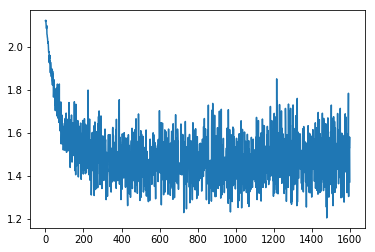

100 1.25% (0.0m 1.511784553527832s) 1.887 / Physics X Computer Science
200 2.5% (0.0m 3.025468587875366s) 1.8 / Physics X Computer Science
300 3.75% (0.0m 4.54011344909668s) 1.874 / Physics X Economics
400 5.0% (0.0m 6.056043863296509s) 2.133 / Physics X Mathematics
500 6.25% (0.0m 7.578492164611816s) 1.45 / Physics V
600 7.5% (0.0m 9.098800659179688s) 1.902 / Physics X Statistics
700 8.75% (0.0m 10.61484980583191s) 1.246 / Physics V
800 10.0% (0.0m 12.140995979309082s) 1.714 / Physics X Computer Science
900 11.25% (0.0m 13.659136295318604s) 1.756 / Physics V
1000 12.5% (0.0m 15.176115989685059s) 1.819 / Physics X Statistics
1100 13.75% (0.0m 16.695070028305054s) 1.202 / Physics V
1200 15.0% (0.0m 18.215373754501343s) 1.495 / Physics X Computer Science
1300 16.25% (0.0m 19.730992078781128s) 1.54 / Physics X Statistics
1400 17.5% (0.0m 21.25385856628418s) 1.388 / Physics V
1500 18.75% (0.0m 22.764315843582153s) 1.853 / Physics X Computer Science
1600 20.0% (0.0m 24.283640384674072s) 1.5

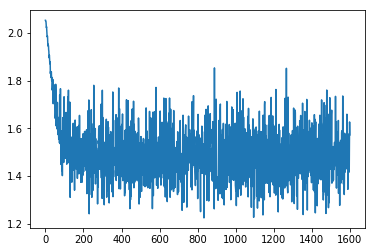

100 1.25% (0.0m 2.7996482849121094s) 1.983 / Physics X Computer Science
200 2.5% (0.0m 5.365861415863037s) 1.923 / Physics X Mathematics
300 3.75% (0.0m 7.927543878555298s) 1.6 / Physics V
400 5.0% (0.0m 10.488734722137451s) 1.692 / Physics X Computer Science
500 6.25% (0.0m 13.06561541557312s) 1.568 / Physics X Computer Science
600 7.5% (0.0m 15.62239384651184s) 1.406 / Physics X Computer Science
700 8.75% (0.0m 18.18602466583252s) 1.225 / Physics X Mathematics
800 10.0% (0.0m 20.755016326904297s) 1.443 / Physics V
900 11.25% (0.0m 23.32604455947876s) 1.529 / Physics X Computer Science
1000 12.5% (0.0m 25.892904043197632s) 1.232 / Physics X Mathematics
1100 13.75% (0.0m 28.470252752304077s) 1.426 / Physics X Computer Science
1200 15.0% (0.0m 31.039859533309937s) 1.242 / Physics X Computer Science
1300 16.25% (0.0m 33.61136341094971s) 1.491 / Physics X Mathematics
1400 17.5% (0.0m 36.17023682594299s) 1.312 / Physics V
1500 18.75% (0.0m 38.74065637588501s) 1.412 / Physics V
1600 20.0% (

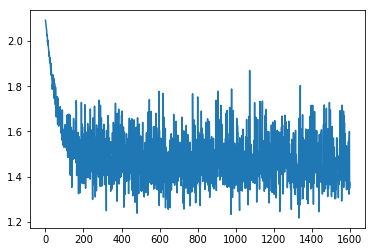

100 1.25% (0.0m 3.649672269821167s) 1.964 / Physics X Computer Science
200 2.5% (0.0m 7.275684118270874s) 1.828 / Physics V
300 3.75% (0.0m 10.895218849182129s) 1.763 / Physics X Computer Science
400 5.0% (0.0m 14.521075963973999s) 1.66 / Physics X Computer Science
500 6.25% (0.0m 18.168646812438965s) 1.584 / Physics X Mathematics
600 7.5% (0.0m 21.80498456954956s) 1.557 / Physics V
700 8.75% (0.0m 25.611865520477295s) 1.329 / Physics X Mathematics
800 10.0% (0.0m 29.62701439857483s) 1.575 / Physics X Computer Science
900 11.25% (0.0m 33.64682364463806s) 1.611 / Physics V
1000 12.5% (0.0m 37.3448052406311s) 1.379 / Physics V
1100 13.75% (0.0m 40.99122452735901s) 1.21 / Physics X Mathematics
1200 15.0% (0.0m 44.64350461959839s) 1.281 / Physics X Mathematics
1300 16.25% (0.0m 48.27711248397827s) 1.629 / Physics X Mathematics
1400 17.5% (0.0m 51.93456768989563s) 1.871 / Physics X Mathematics
1500 18.75% (0.0m 55.56915903091431s) 1.471 / Physics V
1600 20.0% (0.0m 59.21617603302002s) 1.27 

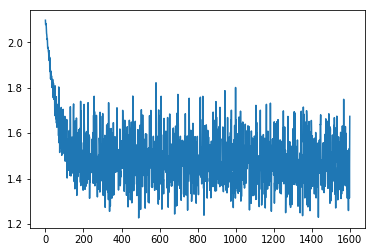

100 1.25% (0.0m 4.722177982330322s) 1.934 / Physics X Computer Science
200 2.5% (0.0m 9.360158681869507s) 1.87 / Physics V
300 3.75% (0.0m 14.023160457611084s) 1.679 / Physics X Computer Science
400 5.0% (0.0m 18.72432279586792s) 1.59 / Physics X Mathematics
500 6.25% (0.0m 23.403478622436523s) 1.598 / Physics V
600 7.5% (0.0m 28.134411334991455s) 1.396 / Physics V
700 8.75% (0.0m 32.821433782577515s) 1.263 / Physics V
800 10.0% (0.0m 37.394813537597656s) 1.499 / Physics V
900 11.25% (0.0m 42.16963171958923s) 1.499 / Physics X Mathematics
1000 12.5% (0.0m 46.89563512802124s) 1.294 / Physics X Computer Science
1100 13.75% (0.0m 51.891568422317505s) 1.216 / Physics X Mathematics
1200 15.0% (0.0m 57.12557792663574s) 1.58 / Physics V
1300 16.25% (1.0m 2.0442922115325928s) 1.419 / Physics X Computer Science
1400 17.5% (1.0m 6.812165975570679s) 1.19 / Physics X Computer Science
1500 18.75% (1.0m 11.50543212890625s) 1.263 / Physics X Mathematics
1600 20.0% (1.0m 16.246793270111084s) 1.354 / P

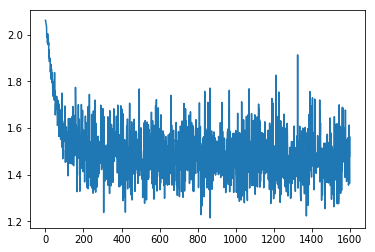

100 1.25% (0.0m 5.704309701919556s) 1.975 / Physics X Mathematics
200 2.5% (0.0m 11.427260398864746s) 1.842 / Physics V
300 3.75% (0.0m 17.158619165420532s) 1.716 / Physics X Mathematics
400 5.0% (0.0m 22.8304226398468s) 1.719 / Physics V
500 6.25% (0.0m 29.041764736175537s) 1.32 / Physics V
600 7.5% (0.0m 35.23064470291138s) 1.541 / Physics X Quantitative Biology
700 8.75% (0.0m 41.770716428756714s) 1.595 / Physics X Quantitative Biology
800 10.0% (0.0m 47.56611132621765s) 1.621 / Physics V
900 11.25% (0.0m 53.28723955154419s) 1.265 / Physics V
1000 12.5% (0.0m 58.92032742500305s) 1.487 / Physics V
1100 13.75% (1.0m 4.666553497314453s) 1.241 / Physics V
1200 15.0% (1.0m 10.561486721038818s) 1.199 / Physics V
1300 16.25% (1.0m 17.04108691215515s) 1.499 / Physics V
1400 17.5% (1.0m 23.00351095199585s) 1.684 / Physics X Quantitative Biology
1500 18.75% (1.0m 28.715099811553955s) 1.415 / Physics V
1600 20.0% (1.0m 34.50648212432861s) 1.65 / Physics X Computer Science
1700 21.25% (1.0m 40.

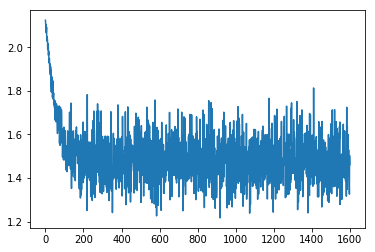

100 1.25% (0.0m 7.282310962677002s) 1.896 / Physics V
200 2.5% (0.0m 14.853486061096191s) 1.858 / Physics X Mathematics
300 3.75% (0.0m 21.811180353164673s) 1.567 / Physics X Mathematics
400 5.0% (0.0m 28.764193058013916s) 1.393 / Physics X Mathematics
500 6.25% (0.0m 35.71183180809021s) 1.836 / Physics X Computer Science
600 7.5% (0.0m 42.72258114814758s) 1.915 / Physics V
700 8.75% (0.0m 49.70238256454468s) 1.733 / Physics X Computer Science
800 10.0% (0.0m 56.71061182022095s) 1.281 / Physics V
900 11.25% (1.0m 3.661484479904175s) 1.343 / Physics V
1000 12.5% (1.0m 10.653019666671753s) 1.529 / Physics X Quantitative Biology
1100 13.75% (1.0m 17.606820344924927s) 1.971 / Physics X Statistics
1200 15.0% (1.0m 24.610385179519653s) 1.474 / Physics V
1300 16.25% (1.0m 32.32276940345764s) 1.711 / Physics X Computer Science
1400 17.5% (1.0m 39.49545073509216s) 1.76 / Physics X Mathematics
1500 18.75% (1.0m 46.485520362854004s) 1.999 / Physics X Computer Science
1600 20.0% (1.0m 53.469295024

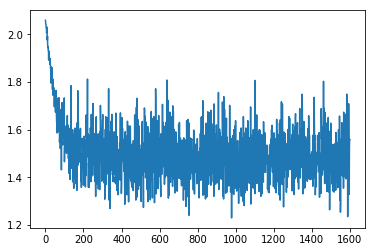

100 1.25% (0.0m 9.004631757736206s) 1.904 / Computer Science X Physics
200 2.5% (0.0m 16.86381244659424s) 1.756 / Physics X Computer Science
300 3.75% (0.0m 24.676536321640015s) 1.512 / Physics V
400 5.0% (0.0m 32.417163372039795s) 1.676 / Physics V
500 6.25% (0.0m 40.20512294769287s) 1.935 / Physics V
600 7.5% (0.0m 47.995689153671265s) 1.466 / Physics V
700 8.75% (0.0m 55.87446069717407s) 1.555 / Physics V
800 10.0% (1.0m 3.707040309906006s) 1.333 / Physics V
900 11.25% (1.0m 11.6606764793396s) 1.409 / Physics X Computer Science
1000 12.5% (1.0m 19.54630994796753s) 1.372 / Physics X Mathematics
1100 13.75% (1.0m 28.361950397491455s) 1.602 / Physics X Computer Science
1200 15.0% (1.0m 36.285484313964844s) 1.284 / Physics X Computer Science
1300 16.25% (1.0m 44.12073278427124s) 1.771 / Physics X Quantitative Biology
1400 17.5% (1.0m 51.9182288646698s) 2.007 / Physics X Mathematics
1500 18.75% (1.0m 59.660420656204224s) 1.963 / Physics V
1600 20.0% (2.0m 7.5044050216674805s) 1.409 / Phy

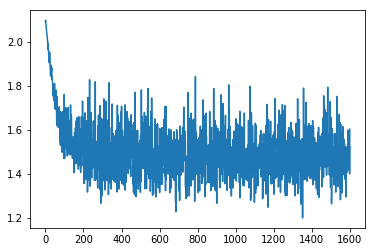

100 1.25% (0.0m 9.489451885223389s) 1.911 / Physics X Computer Science
200 2.5% (0.0m 19.166967153549194s) 1.842 / Physics X Quantitative Biology
300 3.75% (0.0m 28.27271866798401s) 1.546 / Physics V
400 5.0% (0.0m 37.239253997802734s) 1.563 / Physics X Quantitative Finance
500 6.25% (0.0m 46.20922327041626s) 1.615 / Physics X Mathematics
600 7.5% (0.0m 55.29879093170166s) 1.644 / Physics X Computer Science
700 8.75% (1.0m 4.39100456237793s) 1.46 / Physics X Computer Science
800 10.0% (1.0m 13.265155792236328s) 1.552 / Physics X Quantitative Biology
900 11.25% (1.0m 22.358964443206787s) 1.591 / Physics V
1000 12.5% (1.0m 32.11307072639465s) 1.46 / Physics V
1100 13.75% (1.0m 41.69751024246216s) 1.464 / Physics V
1200 15.0% (1.0m 50.5858850479126s) 1.528 / Physics X Computer Science
1300 16.25% (1.0m 59.69030213356018s) 1.268 / Physics V
1400 17.5% (2.0m 8.655807971954346s) 1.244 / Physics X Computer Science
1500 18.75% (2.0m 17.688053131103516s) 1.34 / Physics X Mathematics
1600 20.0% 

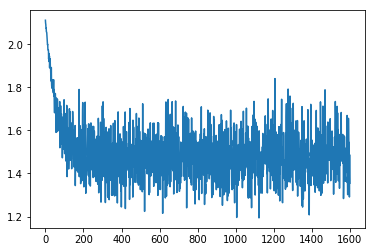

100 1.25% (0.0m 10.706544160842896s) 1.909 / Physics V
200 2.5% (0.0m 21.21736240386963s) 1.682 / Physics V
300 3.75% (0.0m 31.748127937316895s) 1.796 / Physics X Quantitative Biology
400 5.0% (0.0m 42.30560088157654s) 1.633 / Physics V
500 6.25% (0.0m 52.82732152938843s) 1.625 / Physics V
600 7.5% (1.0m 3.889434337615967s) 1.57 / Physics X Computer Science
700 8.75% (1.0m 14.744760990142822s) 1.373 / Physics X Mathematics
800 10.0% (1.0m 26.020034313201904s) 1.18 / Physics V
900 11.25% (1.0m 36.57410669326782s) 1.612 / Physics V
1000 12.5% (1.0m 47.431183099746704s) 1.489 / Physics V
1100 13.75% (1.0m 58.88041400909424s) 1.529 / Physics X Computer Science
1200 15.0% (2.0m 9.509855270385742s) 1.508 / Physics V
1300 16.25% (2.0m 20.079560041427612s) 1.254 / Physics V
1400 17.5% (2.0m 30.716975212097168s) 1.74 / Physics V
1500 18.75% (2.0m 42.20624136924744s) 1.445 / Physics V
1600 20.0% (2.0m 52.7432644367218s) 1.16 / Physics V
1700 21.25% (3.0m 3.2950053215026855s) 1.374 / Physics V
18

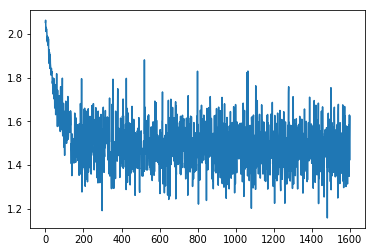

100 1.25% (0.0m 11.732925653457642s) 1.866 / Physics V
200 2.5% (0.0m 24.41397213935852s) 1.813 / Physics X Quantitative Biology
300 3.75% (0.0m 36.111083984375s) 1.706 / Physics X Mathematics
400 5.0% (0.0m 47.76847577095032s) 1.511 / Physics V
500 6.25% (0.0m 59.51706266403198s) 1.494 / Physics V
600 7.5% (1.0m 11.273841857910156s) 1.527 / Physics X Mathematics
700 8.75% (1.0m 23.03474712371826s) 1.222 / Physics V
800 10.0% (1.0m 34.96047902107239s) 1.482 / Physics X Quantitative Biology
900 11.25% (1.0m 47.455817222595215s) 1.328 / Physics X Computer Science
1000 12.5% (1.0m 59.639787435531616s) 1.84 / Physics X Quantitative Biology
1100 13.75% (2.0m 11.325014114379883s) 1.474 / Physics X Computer Science
1200 15.0% (2.0m 23.09105348587036s) 1.564 / Physics V
1300 16.25% (2.0m 34.65316987037659s) 1.761 / Physics X Mathematics
1400 17.5% (2.0m 46.52244019508362s) 1.605 / Physics X Computer Science
1500 18.75% (2.0m 58.960413455963135s) 1.514 / Physics X Computer Science
1600 20.0% (3

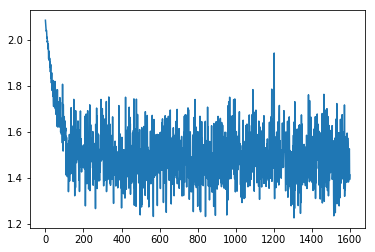

100 1.25% (0.0m 12.576862335205078s) 1.93 / Physics X Quantitative Biology
200 2.5% (0.0m 25.16504192352295s) 1.986 / Physics X Electrical Engineering and Systems Science
300 3.75% (0.0m 38.97138237953186s) 1.756 / Physics X Mathematics
400 5.0% (0.0m 51.760101079940796s) 1.801 / Physics V
500 6.25% (1.0m 4.3843677043914795s) 1.835 / Physics X Quantitative Biology
600 7.5% (1.0m 17.514050722122192s) 1.501 / Physics V
700 8.75% (1.0m 30.061156511306763s) 1.505 / Physics X Computer Science
800 10.0% (1.0m 42.69489288330078s) 1.443 / Physics X Computer Science
900 11.25% (1.0m 56.19213914871216s) 1.258 / Physics V
1000 12.5% (2.0m 9.261543035507202s) 1.645 / Physics X Quantitative Biology
1100 13.75% (2.0m 21.721047401428223s) 1.736 / Physics X Mathematics
1200 15.0% (2.0m 34.66389489173889s) 1.681 / Physics V
1300 16.25% (2.0m 48.25247859954834s) 1.791 / Physics V
1400 17.5% (3.0m 0.8987910747528076s) 1.508 / Physics X Quantitative Finance
1500 18.75% (3.0m 14.1253502368927s) 1.595 / Phy

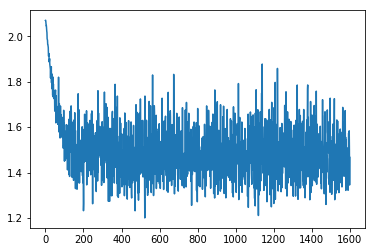

100 1.25% (0.0m 13.769163846969604s) 2.024 / Physics X Quantitative Biology
200 2.5% (0.0m 27.63181781768799s) 1.933 / Physics X Computer Science
300 3.75% (0.0m 41.91837453842163s) 1.564 / Physics X Computer Science
400 5.0% (0.0m 57.99401807785034s) 1.422 / Physics V
500 6.25% (1.0m 11.736480951309204s) 1.511 / Physics V
600 7.5% (1.0m 25.78122878074646s) 1.707 / Physics X Electrical Engineering and Systems Science
700 8.75% (1.0m 39.58998990058899s) 1.323 / Physics X Computer Science
800 10.0% (1.0m 53.41582179069519s) 1.626 / Physics X Mathematics
900 11.25% (2.0m 8.442253589630127s) 1.441 / Physics X Computer Science
1000 12.5% (2.0m 22.618919849395752s) 1.491 / Physics V
1100 13.75% (2.0m 36.5826575756073s) 1.353 / Physics X Computer Science
1200 15.0% (2.0m 50.73542523384094s) 1.749 / Physics X Quantitative Finance
1300 16.25% (3.0m 4.738318681716919s) 1.521 / Physics X Computer Science
1400 17.5% (3.0m 18.557384967803955s) 1.133 / Physics V
1500 18.75% (3.0m 33.47497773170471s)

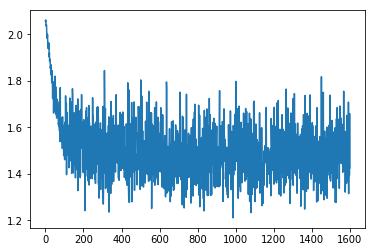

100 1.25% (0.0m 15.353405237197876s) 1.889 / Physics V
200 2.5% (0.0m 30.78248381614685s) 1.826 / Physics V
300 3.75% (0.0m 47.07480549812317s) 1.705 / Physics X Computer Science
400 5.0% (1.0m 2.380415439605713s) 1.76 / Physics X Computer Science
500 6.25% (1.0m 17.750763177871704s) 1.813 / Physics V
600 7.5% (1.0m 33.293182134628296s) 1.582 / Physics V
700 8.75% (1.0m 48.35740780830383s) 1.297 / Physics X Computer Science
800 10.0% (2.0m 5.455656290054321s) 1.425 / Physics X Computer Science
900 11.25% (2.0m 20.827058792114258s) 1.517 / Physics X Computer Science
1000 12.5% (2.0m 36.977885007858276s) 1.418 / Physics V
1100 13.75% (2.0m 53.11469388008118s) 1.254 / Physics V
1200 15.0% (3.0m 8.38692307472229s) 1.674 / Physics X Mathematics
1300 16.25% (3.0m 25.241990327835083s) 1.227 / Physics X Computer Science
1400 17.5% (3.0m 40.363004207611084s) 1.731 / Physics X Computer Science
1500 18.75% (3.0m 56.03388857841492s) 1.518 / Physics X Computer Science
1600 20.0% (4.0m 11.8234078884

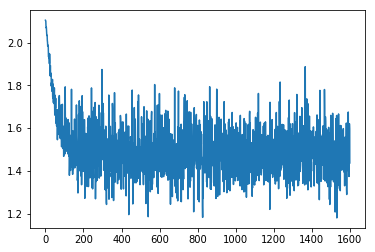

100 1.25% (0.0m 17.48773694038391s) 1.926 / Physics V
200 2.5% (0.0m 34.32808327674866s) 1.729 / Physics X Quantitative Biology
300 3.75% (0.0m 51.56710338592529s) 1.712 / Physics X Mathematics
400 5.0% (1.0m 10.254620790481567s) 1.593 / Physics V
500 6.25% (1.0m 27.357513189315796s) 1.818 / Physics X Mathematics
600 7.5% (1.0m 44.21647596359253s) 1.513 / Physics X Mathematics
700 8.75% (2.0m 1.4849627017974854s) 1.633 / Physics X Computer Science
800 10.0% (2.0m 20.523476600646973s) 1.391 / Physics X Mathematics
900 11.25% (2.0m 37.86916470527649s) 1.472 / Physics X Computer Science
1000 12.5% (2.0m 54.98030376434326s) 1.703 / Physics V
1100 13.75% (3.0m 12.412327527999878s) 1.617 / Physics V
1200 15.0% (3.0m 29.774536848068237s) 2.181 / Physics X Quantitative Finance
1300 16.25% (3.0m 48.3276309967041s) 1.551 / Physics V
1400 17.5% (4.0m 5.266399621963501s) 0.9961 / Physics X Computer Science
1500 18.75% (4.0m 21.85574746131897s) 1.747 / Physics V
1600 20.0% (4.0m 39.42508912086487s)

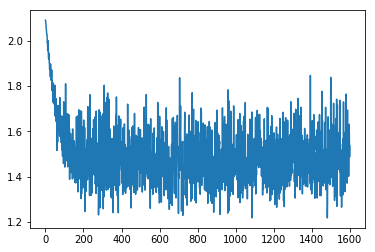

100 1.25% (0.0m 20.647884845733643s) 1.929 / Physics X Mathematics
200 2.5% (0.0m 40.04881739616394s) 1.866 / Physics X Computer Science
300 3.75% (0.0m 59.24874544143677s) 1.518 / Physics V
400 5.0% (1.0m 18.843919277191162s) 1.36 / Physics V
500 6.25% (1.0m 39.36914038658142s) 1.507 / Physics V
600 7.5% (1.0m 59.29357957839966s) 1.57 / Physics X Mathematics
700 8.75% (2.0m 18.561584949493408s) 1.307 / Physics X Computer Science
800 10.0% (2.0m 37.46616888046265s) 1.697 / Physics X Mathematics
900 11.25% (2.0m 57.72977352142334s) 1.573 / Physics X Mathematics
1000 12.5% (3.0m 17.313535690307617s) 1.426 / Physics V
1100 13.75% (3.0m 36.839789628982544s) 1.677 / Physics V
1200 15.0% (3.0m 56.41040587425232s) 1.198 / Physics V
1300 16.25% (4.0m 17.178542613983154s) 1.392 / Physics V
1400 17.5% (4.0m 37.75439715385437s) 1.51 / Physics V
1500 18.75% (4.0m 58.15958213806152s) 1.115 / Physics X Computer Science
1600 20.0% (5.0m 17.47755265235901s) 1.485 / Physics V
1700 21.25% (5.0m 37.61341

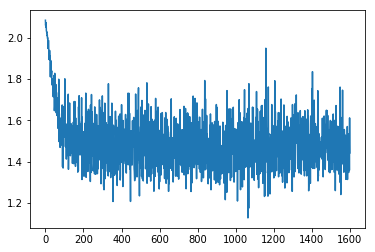

100 1.25% (0.0m 21.381844997406006s) 1.959 / Physics X Quantitative Biology
200 2.5% (0.0m 44.31607508659363s) 1.716 / Physics V


KeyboardInterrupt: ignored

In [0]:
#DO NOT RUN THIS



#EXPERIMENT VARYING INPUT LENGTH with randomWeightedTrainingExample
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=10;               #this is the minimum abstract length we are testing our model on
max_length=1000
print_every = 100
plot_every = 5


for use_first_characters in range (minimum, max_length, 50):

  rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
  optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []

  start = time.time()

  for it in range(1, n_iters+1):

    optimizer.zero_grad()

    training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
    category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    batch = 0
    while batch < batch_size:
      category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
      if len(abstract) < use_first_characters:
          # do this nasty "trick" to guarantee all the tensors have the same size
        continue

      training_batch[:, batch, :] = abstract_tensor[:, 0, :]
      category_batch[batch] = category_tensor[:]
      batch += 1

    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()


    if not (it % print_every):
      guess, guess_i = categoryFromOutput(output)
      correct = "V" if guess == category else "X {}".format(category)
      print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

    if not (it % plot_every):
      all_losses.append(current_loss / plot_every)
      current_loss = 0
        
  print("characters used: ", use_first_characters)      
  plot_losses(all_losses)
  

100 1.25% (0.0m 0.45727014541625977s) 2.08 / Quantitative Biology V
200 2.5% (0.0m 0.9022557735443115s) 2.089 / Computer Science V
300 3.75% (0.0m 1.3391282558441162s) 2.08 / Computer Science X Quantitative Finance
400 5.0% (0.0m 1.7852914333343506s) 2.079 / Computer Science X Economics
500 6.25% (0.0m 2.222930669784546s) 2.084 / Economics V
600 7.5% (0.0m 2.6755993366241455s) 2.089 / Computer Science X Electrical Engineering and Systems Science
700 8.75% (0.0m 3.114203929901123s) 2.076 / Statistics X Computer Science
800 10.0% (0.0m 3.5661518573760986s) 2.073 / Statistics X Quantitative Finance
900 11.25% (0.0m 4.010301113128662s) 2.084 / Statistics X Mathematics
1000 12.5% (0.0m 4.449819564819336s) 2.082 / Economics X Quantitative Biology
1100 13.75% (0.0m 4.893819332122803s) 2.07 / Electrical Engineering and Systems Science V
1200 15.0% (0.0m 5.328777551651001s) 2.072 / Electrical Engineering and Systems Science V
1300 16.25% (0.0m 5.773284196853638s) 2.071 / Electrical Engineering 

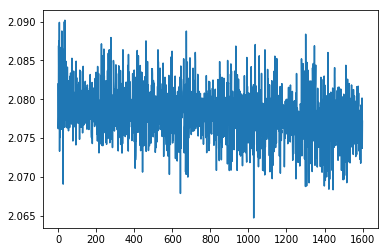

100 1.25% (0.0m 1.4968154430389404s) 2.089 / Statistics X Quantitative Finance
200 2.5% (0.0m 3.1534550189971924s) 2.063 / Quantitative Biology V
300 3.75% (0.0m 4.801275968551636s) 2.096 / Statistics X Electrical Engineering and Systems Science
400 5.0% (0.0m 6.465542554855347s) 2.085 / Statistics X Mathematics
500 6.25% (0.0m 8.128616094589233s) 2.083 / Statistics X Electrical Engineering and Systems Science
600 7.5% (0.0m 9.777700662612915s) 2.069 / Statistics X Physics
700 8.75% (0.0m 11.4343101978302s) 2.074 / Computer Science X Economics
800 10.0% (0.0m 12.933101654052734s) 2.088 / Computer Science X Mathematics
900 11.25% (0.0m 14.425442457199097s) 2.078 / Computer Science X Quantitative Biology
1000 12.5% (0.0m 15.908485651016235s) 2.093 / Computer Science X Electrical Engineering and Systems Science
1100 13.75% (0.0m 17.397449016571045s) 2.086 / Statistics X Mathematics
1200 15.0% (0.0m 18.8818199634552s) 2.087 / Statistics X Mathematics
1300 16.25% (0.0m 20.369529962539673s) 

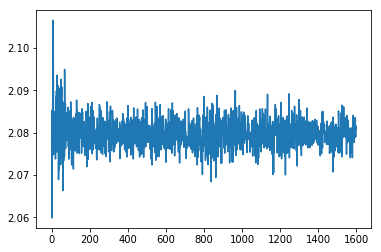

100 1.25% (0.0m 2.5755209922790527s) 2.078 / Electrical Engineering and Systems Science X Mathematics
200 2.5% (0.0m 5.1195387840271s) 2.105 / Electrical Engineering and Systems Science X Quantitative Finance
300 3.75% (0.0m 7.676227331161499s) 2.076 / Electrical Engineering and Systems Science X Economics
400 5.0% (0.0m 10.224998235702515s) 2.068 / Physics X Mathematics
500 6.25% (0.0m 12.76944088935852s) 2.086 / Physics X Quantitative Biology
600 7.5% (0.0m 15.3167245388031s) 2.09 / Quantitative Biology X Mathematics
700 8.75% (0.0m 17.85872483253479s) 2.073 / Quantitative Biology X Mathematics
800 10.0% (0.0m 20.40699529647827s) 2.061 / Quantitative Biology X Mathematics
900 11.25% (0.0m 22.95098328590393s) 2.075 / Quantitative Biology X Economics
1000 12.5% (0.0m 25.490591049194336s) 2.067 / Quantitative Biology X Computer Science
1100 13.75% (0.0m 28.027281522750854s) 2.093 / Quantitative Biology X Statistics
1200 15.0% (0.0m 30.572168827056885s) 2.084 / Electrical Engineering and

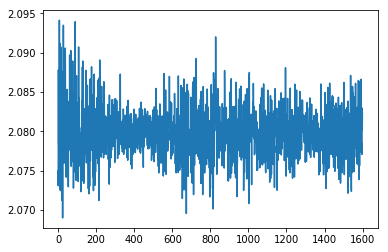

100 1.25% (0.0m 3.982717752456665s) 2.082 / Economics X Mathematics
200 2.5% (0.0m 7.590627431869507s) 2.078 / Computer Science X Physics
300 3.75% (0.0m 11.21863079071045s) 2.087 / Economics X Electrical Engineering and Systems Science
400 5.0% (0.0m 14.827802181243896s) 2.088 / Economics X Electrical Engineering and Systems Science
500 6.25% (0.0m 18.43777084350586s) 2.089 / Economics X Statistics
600 7.5% (0.0m 22.056994438171387s) 2.07 / Economics X Mathematics
700 8.75% (0.0m 25.690372228622437s) 2.081 / Economics X Physics
800 10.0% (0.0m 29.556052207946777s) 2.072 / Economics X Physics
900 11.25% (0.0m 33.578919649124146s) 2.086 / Economics X Mathematics
1000 12.5% (0.0m 37.57383608818054s) 2.087 / Economics X Mathematics
1100 13.75% (0.0m 41.19299244880676s) 2.069 / Computer Science X Statistics
1200 15.0% (0.0m 44.82621669769287s) 2.091 / Physics X Electrical Engineering and Systems Science
1300 16.25% (0.0m 48.43832755088806s) 2.078 / Computer Science V
1400 17.5% (0.0m 52.06

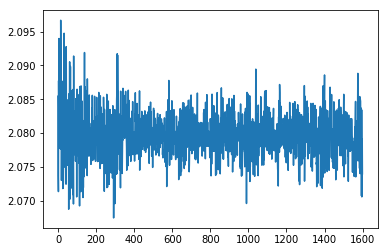

100 1.25% (0.0m 4.672747611999512s) 2.074 / Quantitative Biology X Economics
200 2.5% (0.0m 9.253527879714966s) 2.066 / Mathematics X Quantitative Finance
300 3.75% (0.0m 13.952293157577515s) 2.087 / Statistics X Computer Science
400 5.0% (0.0m 18.54114294052124s) 2.069 / Statistics X Economics
500 6.25% (0.0m 23.383201837539673s) 2.077 / Statistics X Computer Science
600 7.5% (0.0m 28.52839159965515s) 2.075 / Economics X Quantitative Biology
700 8.75% (0.0m 33.41963505744934s) 2.076 / Economics X Quantitative Biology
800 10.0% (0.0m 38.000227212905884s) 2.069 / Statistics X Quantitative Biology
900 11.25% (0.0m 42.6496422290802s) 2.085 / Quantitative Biology X Computer Science
1000 12.5% (0.0m 47.82351231575012s) 2.089 / Quantitative Biology X Mathematics
1100 13.75% (0.0m 53.02854585647583s) 2.072 / Statistics V
1200 15.0% (0.0m 57.73142719268799s) 2.082 / Quantitative Biology X Mathematics
1300 16.25% (1.0m 2.364694595336914s) 2.071 / Quantitative Biology V
1400 17.5% (1.0m 6.997215

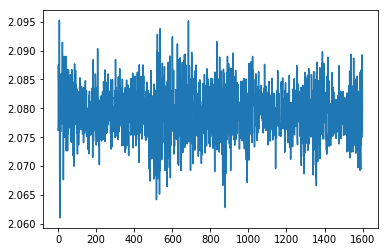

100 1.25% (0.0m 5.660486459732056s) 2.09 / Mathematics V
200 2.5% (0.0m 11.405915260314941s) 2.077 / Physics X Mathematics
300 3.75% (0.0m 17.043051958084106s) 2.075 / Physics X Electrical Engineering and Systems Science
400 5.0% (0.0m 22.625011920928955s) 2.074 / Physics X Quantitative Biology
500 6.25% (0.0m 28.328495979309082s) 2.078 / Mathematics V
600 7.5% (0.0m 34.008882999420166s) 2.07 / Mathematics X Physics
700 8.75% (0.0m 39.626259326934814s) 2.087 / Physics X Mathematics
800 10.0% (0.0m 45.59573674201965s) 2.083 / Physics X Quantitative Finance
900 11.25% (0.0m 51.926605463027954s) 2.079 / Quantitative Biology X Computer Science
1000 12.5% (0.0m 57.631587505340576s) 2.085 / Quantitative Biology X Physics
1100 13.75% (1.0m 3.2594361305236816s) 2.075 / Quantitative Biology X Electrical Engineering and Systems Science
1200 15.0% (1.0m 8.881699323654175s) 2.073 / Quantitative Biology X Electrical Engineering and Systems Science
1300 16.25% (1.0m 14.93672227859497s) 2.076 / Quant

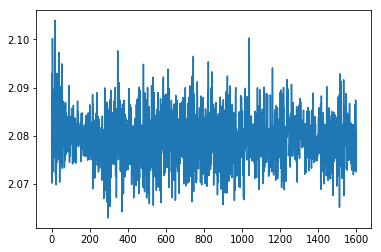

100 1.25% (0.0m 6.802371501922607s) 2.072 / Electrical Engineering and Systems Science X Physics
200 2.5% (0.0m 13.654250383377075s) 2.086 / Electrical Engineering and Systems Science X Economics
300 3.75% (0.0m 20.4868061542511s) 2.08 / Electrical Engineering and Systems Science X Physics
400 5.0% (0.0m 27.31307101249695s) 2.062 / Physics X Computer Science
500 6.25% (0.0m 34.15239977836609s) 2.057 / Computer Science X Mathematics
600 7.5% (0.0m 40.99641942977905s) 2.076 / Physics X Quantitative Finance
700 8.75% (0.0m 47.848511695861816s) 2.077 / Statistics V
800 10.0% (0.0m 54.722593784332275s) 2.083 / Computer Science X Mathematics
900 11.25% (1.0m 1.5554988384246826s) 2.081 / Physics V
1000 12.5% (1.0m 8.663971424102783s) 2.074 / Physics V
1100 13.75% (1.0m 16.175462007522583s) 2.067 / Computer Science X Physics
1200 15.0% (1.0m 23.046947717666626s) 2.083 / Economics X Quantitative Biology
1300 16.25% (1.0m 29.871741771697998s) 2.079 / Economics X Physics
1400 17.5% (1.0m 36.73039

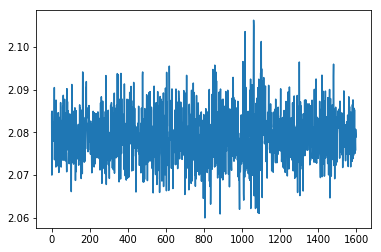

100 1.25% (0.0m 7.882068872451782s) 2.073 / Economics V
200 2.5% (0.0m 15.55321192741394s) 2.063 / Economics V
300 3.75% (0.0m 23.26578402519226s) 2.096 / Economics X Quantitative Biology
400 5.0% (0.0m 30.95271587371826s) 2.103 / Economics X Electrical Engineering and Systems Science
500 6.25% (0.0m 38.65355134010315s) 2.082 / Computer Science X Economics
600 7.5% (0.0m 46.31161594390869s) 2.079 / Economics X Electrical Engineering and Systems Science
700 8.75% (0.0m 53.996203899383545s) 2.086 / Economics X Quantitative Finance
800 10.0% (1.0m 1.6255459785461426s) 2.053 / Economics V
900 11.25% (1.0m 9.2889084815979s) 2.086 / Economics X Statistics
1000 12.5% (1.0m 17.577924251556396s) 2.093 / Economics V
1100 13.75% (1.0m 25.85540461540222s) 2.064 / Statistics X Electrical Engineering and Systems Science
1200 15.0% (1.0m 33.51155376434326s) 2.073 / Statistics X Electrical Engineering and Systems Science
1300 16.25% (1.0m 41.154930114746094s) 2.065 / Electrical Engineering and Systems

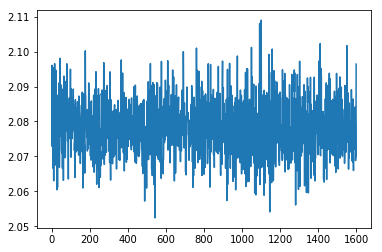

100 1.25% (0.0m 8.903356552124023s) 2.098 / Mathematics X Economics
200 2.5% (0.0m 18.89423680305481s) 2.082 / Mathematics X Computer Science
300 3.75% (0.0m 27.603934049606323s) 2.069 / Electrical Engineering and Systems Science X Statistics
400 5.0% (0.0m 36.43080019950867s) 2.065 / Electrical Engineering and Systems Science V
500 6.25% (0.0m 45.170538902282715s) 2.077 / Electrical Engineering and Systems Science X Physics
600 7.5% (0.0m 53.935126304626465s) 2.081 / Statistics V
700 8.75% (1.0m 2.70272159576416s) 2.069 / Physics X Quantitative Biology
800 10.0% (1.0m 11.42123532295227s) 2.071 / Electrical Engineering and Systems Science V
900 11.25% (1.0m 20.029508352279663s) 2.089 / Electrical Engineering and Systems Science X Mathematics
1000 12.5% (1.0m 28.792234182357788s) 2.079 / Electrical Engineering and Systems Science V
1100 13.75% (1.0m 38.69284772872925s) 2.073 / Electrical Engineering and Systems Science X Mathematics
1200 15.0% (1.0m 47.47697734832764s) 2.067 / Electrica

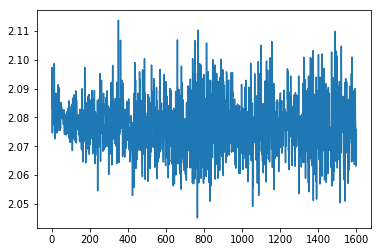

100 1.25% (0.0m 10.462658166885376s) 2.086 / Electrical Engineering and Systems Science X Mathematics
200 2.5% (0.0m 21.440507650375366s) 2.077 / Quantitative Biology X Computer Science
300 3.75% (0.0m 32.1286461353302s) 2.081 / Electrical Engineering and Systems Science X Quantitative Finance
400 5.0% (0.0m 42.477203369140625s) 2.059 / Electrical Engineering and Systems Science X Economics
500 6.25% (0.0m 52.91412281990051s) 2.07 / Electrical Engineering and Systems Science V
600 7.5% (1.0m 3.2771706581115723s) 2.093 / Quantitative Biology X Mathematics
700 8.75% (1.0m 13.695915222167969s) 2.08 / Quantitative Biology X Quantitative Finance
800 10.0% (1.0m 24.056766033172607s) 2.166 / Computer Science X Mathematics
900 11.25% (1.0m 34.46679711341858s) 2.093 / Computer Science X Quantitative Finance
1000 12.5% (1.0m 45.8555121421814s) 2.087 / Computer Science X Statistics
1100 13.75% (1.0m 56.221932888031006s) 2.078 / Statistics X Electrical Engineering and Systems Science
1200 15.0% (2

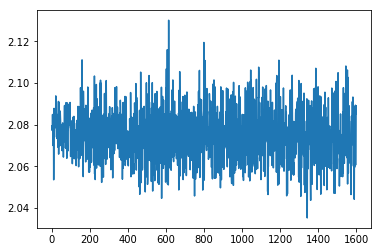

100 1.25% (0.0m 11.487451791763306s) 2.077 / Economics V
200 2.5% (0.0m 22.87231969833374s) 2.091 / Physics X Quantitative Finance
300 3.75% (0.0m 34.1776077747345s) 2.069 / Physics X Electrical Engineering and Systems Science
400 5.0% (0.0m 45.52609443664551s) 2.106 / Physics X Quantitative Biology
500 6.25% (0.0m 56.926308393478394s) 2.041 / Physics X Quantitative Finance
600 7.5% (1.0m 9.157559633255005s) 2.09 / Electrical Engineering and Systems Science X Statistics
700 8.75% (1.0m 20.77917981147766s) 2.093 / Economics X Physics
800 10.0% (1.0m 32.08116602897644s) 2.061 / Electrical Engineering and Systems Science X Computer Science
900 11.25% (1.0m 43.54535269737244s) 2.085 / Electrical Engineering and Systems Science X Quantitative Finance
1000 12.5% (1.0m 54.86605763435364s) 2.043 / Economics X Quantitative Biology
1100 13.75% (2.0m 6.160127639770508s) 2.1 / Electrical Engineering and Systems Science X Physics
1200 15.0% (2.0m 17.560757637023926s) 2.073 / Electrical Engineering 

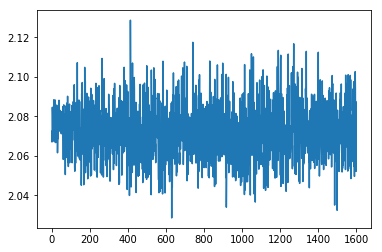

100 1.25% (0.0m 12.304817914962769s) 2.094 / Economics X Electrical Engineering and Systems Science
200 2.5% (0.0m 24.90892481803894s) 2.081 / Economics X Electrical Engineering and Systems Science
300 3.75% (0.0m 37.79377865791321s) 2.044 / Economics X Computer Science
400 5.0% (0.0m 49.95675206184387s) 2.083 / Economics V
500 6.25% (1.0m 2.0561516284942627s) 2.07 / Economics X Statistics
600 7.5% (1.0m 14.099483728408813s) 2.077 / Statistics X Quantitative Biology
700 8.75% (1.0m 26.348809003829956s) 2.059 / Statistics X Economics
800 10.0% (1.0m 38.46496391296387s) 2.037 / Statistics X Quantitative Finance
900 11.25% (1.0m 51.75752329826355s) 2.029 / Quantitative Biology V
1000 12.5% (2.0m 4.033702850341797s) 2.092 / Electrical Engineering and Systems Science X Mathematics
1100 13.75% (2.0m 16.28095030784607s) 2.062 / Electrical Engineering and Systems Science V
1200 15.0% (2.0m 28.5058012008667s) 2.039 / Electrical Engineering and Systems Science V
1300 16.25% (2.0m 40.913690328598

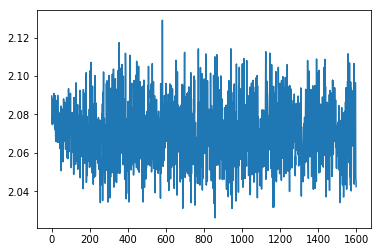

100 1.25% (0.0m 13.109009504318237s) 2.07 / Physics X Statistics
200 2.5% (0.0m 26.446855783462524s) 2.09 / Economics X Statistics
300 3.75% (0.0m 39.92238998413086s) 2.07 / Economics X Statistics
400 5.0% (0.0m 53.235634088516235s) 2.083 / Economics X Electrical Engineering and Systems Science
500 6.25% (1.0m 6.496058940887451s) 2.064 / Economics X Statistics
600 7.5% (1.0m 20.746994495391846s) 2.093 / Economics X Physics
700 8.75% (1.0m 34.19455885887146s) 2.091 / Economics X Electrical Engineering and Systems Science
800 10.0% (1.0m 47.72421622276306s) 2.057 / Electrical Engineering and Systems Science X Quantitative Biology
900 11.25% (2.0m 1.1980993747711182s) 2.024 / Electrical Engineering and Systems Science X Computer Science
1000 12.5% (2.0m 15.81269121170044s) 2.13 / Electrical Engineering and Systems Science X Economics
1100 13.75% (2.0m 29.788635730743408s) 2.058 / Economics X Computer Science
1200 15.0% (2.0m 44.40406513214111s) 2.089 / Electrical Engineering and Systems S

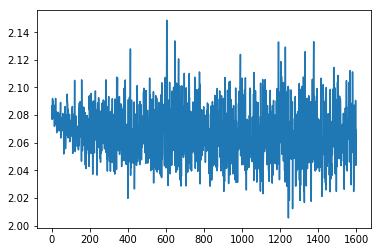

100 1.25% (0.0m 14.749595880508423s) 2.098 / Quantitative Finance X Statistics
200 2.5% (0.0m 29.429719924926758s) 2.081 / Physics X Statistics
300 3.75% (0.0m 45.17021179199219s) 2.071 / Electrical Engineering and Systems Science X Quantitative Biology
400 5.0% (0.0m 59.87650728225708s) 2.051 / Economics X Electrical Engineering and Systems Science
500 6.25% (1.0m 14.808781862258911s) 2.069 / Computer Science X Economics
600 7.5% (1.0m 29.472514867782593s) 2.036 / Quantitative Biology X Electrical Engineering and Systems Science
700 8.75% (1.0m 44.2928626537323s) 2.072 / Electrical Engineering and Systems Science X Statistics
800 10.0% (2.0m 0.5753798484802246s) 2.075 / Statistics X Quantitative Biology
900 11.25% (2.0m 15.661684513092041s) 2.026 / Statistics X Quantitative Biology
1000 12.5% (2.0m 30.366432189941406s) 2.022 / Computer Science X Statistics
1100 13.75% (2.0m 45.18928384780884s) 2.132 / Electrical Engineering and Systems Science X Economics
1200 15.0% (3.0m 0.2922589778

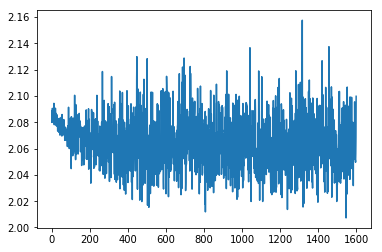

100 1.25% (0.0m 17.930995225906372s) 2.077 / Mathematics X Electrical Engineering and Systems Science
200 2.5% (0.0m 35.8338348865509s) 2.078 / Statistics X Computer Science
300 3.75% (0.0m 52.971689224243164s) 2.083 / Statistics X Computer Science
400 5.0% (1.0m 10.074738025665283s) 2.061 / Statistics X Quantitative Biology
500 6.25% (1.0m 26.815242052078247s) 2.063 / Computer Science V
600 7.5% (1.0m 43.45257878303528s) 2.066 / Statistics X Quantitative Biology
700 8.75% (2.0m 1.5210556983947754s) 2.019 / Computer Science X Quantitative Biology
800 10.0% (2.0m 18.385751962661743s) 2.112 / Quantitative Biology X Computer Science
900 11.25% (2.0m 35.690049171447754s) 2.09 / Quantitative Biology X Physics
1000 12.5% (2.0m 52.491963386535645s) 2.074 / Quantitative Biology X Computer Science
1100 13.75% (3.0m 9.76466178894043s) 2.02 / Electrical Engineering and Systems Science X Economics
1200 15.0% (3.0m 27.155463933944702s) 2.017 / Electrical Engineering and Systems Science X Computer S

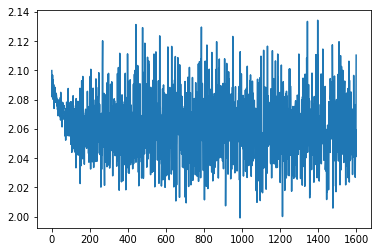

100 1.25% (0.0m 18.586843967437744s) 2.086 / Quantitative Biology X Physics
200 2.5% (0.0m 38.51785326004028s) 2.066 / Quantitative Biology V
300 3.75% (0.0m 57.25570559501648s) 2.059 / Quantitative Biology X Computer Science
400 5.0% (1.0m 16.271830081939697s) 2.048 / Quantitative Biology X Quantitative Finance
500 6.25% (1.0m 35.21388912200928s) 2.046 / Quantitative Biology V
600 7.5% (1.0m 54.68440890312195s) 2.078 / Quantitative Biology X Economics
700 8.75% (2.0m 14.1422598361969s) 2.091 / Quantitative Biology X Physics
800 10.0% (2.0m 33.39684700965881s) 2.057 / Quantitative Biology X Computer Science
900 11.25% (2.0m 51.77116274833679s) 2.059 / Electrical Engineering and Systems Science X Quantitative Finance
1000 12.5% (3.0m 10.846531629562378s) 2.047 / Electrical Engineering and Systems Science X Computer Science
1100 13.75% (3.0m 30.35334062576294s) 2.041 / Electrical Engineering and Systems Science X Statistics
1200 15.0% (3.0m 49.52898621559143s) 1.986 / Electrical Engineer

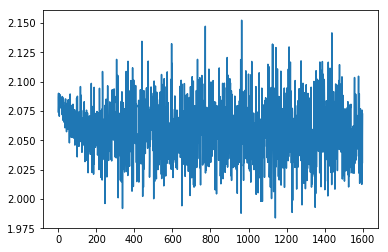

100 1.25% (0.0m 20.999947786331177s) 2.107 / Quantitative Biology X Physics
200 2.5% (0.0m 42.95736002922058s) 2.056 / Quantitative Biology X Economics
300 3.75% (1.0m 4.610558271408081s) 2.063 / Quantitative Biology X Statistics
400 5.0% (1.0m 25.346930027008057s) 2.01 / Quantitative Biology X Quantitative Finance
500 6.25% (1.0m 47.11277651786804s) 2.023 / Quantitative Biology V
600 7.5% (2.0m 9.31607174873352s) 2.058 / Quantitative Biology X Electrical Engineering and Systems Science
700 8.75% (2.0m 30.8600115776062s) 2.116 / Quantitative Biology X Economics
800 10.0% (2.0m 51.71440672874451s) 2.141 / Quantitative Biology X Mathematics
900 11.25% (3.0m 12.657897472381592s) 2.044 / Electrical Engineering and Systems Science X Quantitative Biology
1000 12.5% (3.0m 34.70533752441406s) 2.028 / Electrical Engineering and Systems Science X Economics
1100 13.75% (3.0m 56.234639167785645s) 2.018 / Quantitative Biology X Statistics
1200 15.0% (4.0m 17.027859926223755s) 2.033 / Quantitative B

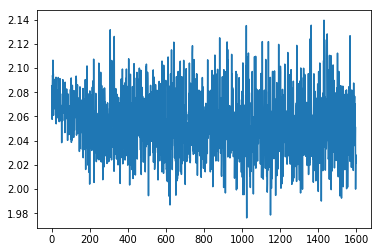

100 1.25% (0.0m 23.320809841156006s) 2.09 / Computer Science X Physics
200 2.5% (0.0m 46.25153136253357s) 2.084 / Electrical Engineering and Systems Science X Physics
300 3.75% (1.0m 10.155601263046265s) 2.05 / Quantitative Biology X Computer Science
400 5.0% (1.0m 33.63064765930176s) 2.033 / Quantitative Biology X Physics
500 6.25% (1.0m 56.53485059738159s) 2.05 / Electrical Engineering and Systems Science X Quantitative Biology
600 7.5% (2.0m 19.538822174072266s) 2.016 / Quantitative Biology X Physics
700 8.75% (2.0m 43.15967082977295s) 2.101 / Quantitative Biology V
800 10.0% (3.0m 7.423651218414307s) 2.07 / Quantitative Biology X Electrical Engineering and Systems Science
900 11.25% (3.0m 30.29165291786194s) 2.115 / Quantitative Biology X Statistics
1000 12.5% (3.0m 53.663578033447266s) 1.977 / Quantitative Biology X Computer Science
1100 13.75% (4.0m 17.493232011795044s) 1.98 / Statistics V
1200 15.0% (4.0m 40.71854257583618s) 2.11 / Quantitative Biology X Economics
1300 16.25% (5

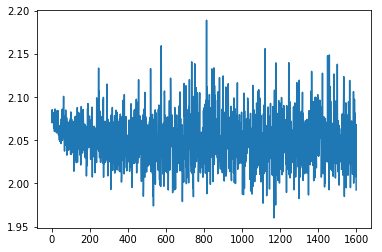

100 1.25% (0.0m 25.436144590377808s) 2.074 / Quantitative Biology X Statistics
200 2.5% (0.0m 50.82098054885864s) 2.062 / Quantitative Biology V
300 3.75% (1.0m 16.096657514572144s) 2.066 / Statistics X Electrical Engineering and Systems Science
400 5.0% (1.0m 41.54313564300537s) 2.081 / Economics X Statistics
500 6.25% (2.0m 6.381367444992065s) 2.013 / Quantitative Biology X Statistics
600 7.5% (2.0m 31.49041509628296s) 2.059 / Quantitative Biology X Electrical Engineering and Systems Science
700 8.75% (2.0m 57.339890480041504s) 2.068 / Electrical Engineering and Systems Science X Quantitative Biology
800 10.0% (3.0m 22.69641375541687s) 2.005 / Quantitative Biology X Physics
900 11.25% (3.0m 47.97592806816101s) 2.093 / Quantitative Biology X Quantitative Finance
1000 12.5% (4.0m 13.507689952850342s) 2.083 / Electrical Engineering and Systems Science X Quantitative Biology
1100 13.75% (4.0m 39.107661485672s) 2.094 / Quantitative Biology X Physics
1200 15.0% (5.0m 4.608417510986328s) 2.

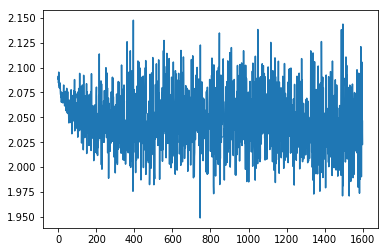

100 1.25% (0.0m 27.59293794631958s) 2.075 / Electrical Engineering and Systems Science X Statistics
200 2.5% (0.0m 56.200196743011475s) 2.071 / Electrical Engineering and Systems Science X Economics
300 3.75% (1.0m 23.997965574264526s) 2.042 / Electrical Engineering and Systems Science X Quantitative Finance
400 5.0% (1.0m 52.1647310256958s) 2.059 / Electrical Engineering and Systems Science X Economics
500 6.25% (2.0m 19.513608694076538s) 2.083 / Electrical Engineering and Systems Science X Computer Science
600 7.5% (2.0m 47.98719668388367s) 2.045 / Quantitative Biology X Physics
700 8.75% (3.0m 16.072757720947266s) 2.09 / Quantitative Biology X Electrical Engineering and Systems Science
800 10.0% (3.0m 44.298540353775024s) 2.073 / Quantitative Biology X Physics
900 11.25% (4.0m 11.848238468170166s) 1.996 / Quantitative Biology X Electrical Engineering and Systems Science
1000 12.5% (4.0m 39.484052419662476s) 2.067 / Quantitative Biology X Economics
1100 13.75% (5.0m 7.374659776687622

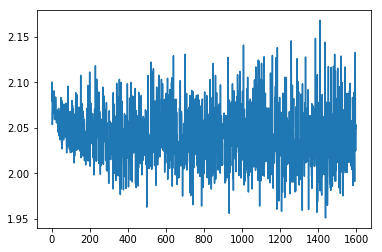

In [0]:
#DO NOT RUN THIS



#EXPERIMENT VARYING INPUT LENGTH with randomTrainingExample



learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=10;               #this is the minimum abstract length we are testing our model on
max_length=1000
print_every = 100
plot_every = 5


for use_first_characters in range (minimum, max_length, 50):

  rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
  optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []

  start = time.time()

  for it in range(1, n_iters+1):

    optimizer.zero_grad()

    training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
    category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    batch = 0
    while batch < batch_size:
      category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
      if len(abstract) < use_first_characters:
          # do this nasty "trick" to guarantee all the tensors have the same size
        continue

      training_batch[:, batch, :] = abstract_tensor[:, 0, :]
      category_batch[batch] = category_tensor[:]
      batch += 1

    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()


    if not (it % print_every):
      guess, guess_i = categoryFromOutput(output)
      correct = "V" if guess == category else "X {}".format(category)
      print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

    if not (it % plot_every):
      all_losses.append(current_loss / plot_every)
      current_loss = 0
        
  print("characters used: ", use_first_characters)      
  plot_losses(all_losses)
  

1000 12.5% (0.0m 12.89957070350647s) 2.096 / Quantitative Finance X Economics
2000 25.0% (0.0m 25.826667547225952s) 2.069 / Electrical Engineering and Systems Science X Economics
3000 37.5% (0.0m 38.685516119003296s) 2.072 / Quantitative Biology X Quantitative Finance
4000 50.0% (0.0m 51.5091495513916s) 2.099 / Electrical Engineering and Systems Science X Mathematics
5000 62.5% (1.0m 4.397140264511108s) 2.078 / Quantitative Biology X Economics
6000 75.0% (1.0m 17.236942291259766s) 2.073 / Quantitative Biology X Physics
7000 87.5% (1.0m 30.111334562301636s) 2.082 / Quantitative Biology X Economics
8000 100.0% (1.0m 43.055644512176514s) 2.087 / Quantitative Finance X Electrical Engineering and Systems Science
learning rate and characters used: 0.0001 50


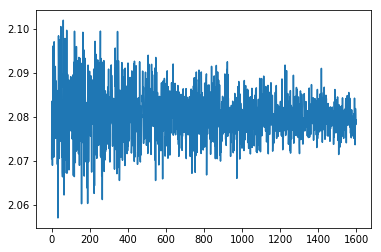

1000 12.5% (0.0m 23.589154720306396s) 2.099 / Quantitative Finance X Economics
2000 25.0% (0.0m 47.176466941833496s) 2.095 / Quantitative Finance X Computer Science
3000 37.5% (1.0m 10.933614492416382s) 2.09 / Quantitative Finance V
4000 50.0% (1.0m 34.605173110961914s) 2.07 / Quantitative Finance X Physics
5000 62.5% (1.0m 58.190497159957886s) 2.072 / Quantitative Finance X Quantitative Biology
6000 75.0% (2.0m 21.779772758483887s) 2.069 / Quantitative Finance X Physics
7000 87.5% (2.0m 45.41846299171448s) 2.076 / Quantitative Finance X Electrical Engineering and Systems Science
8000 100.0% (3.0m 8.968127965927124s) 2.079 / Quantitative Finance X Economics
learning rate and characters used: 0.0001 100


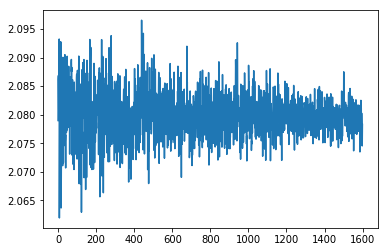

1000 12.5% (0.0m 34.15434384346008s) 2.1 / Electrical Engineering and Systems Science X Physics
2000 25.0% (1.0m 8.475643873214722s) 2.065 / Computer Science V
3000 37.5% (1.0m 42.75817108154297s) 2.082 / Electrical Engineering and Systems Science X Quantitative Biology
4000 50.0% (2.0m 17.059053897857666s) 2.082 / Electrical Engineering and Systems Science X Computer Science
5000 62.5% (2.0m 51.34705638885498s) 2.081 / Electrical Engineering and Systems Science X Physics
6000 75.0% (3.0m 25.742738723754883s) 2.08 / Electrical Engineering and Systems Science X Economics
7000 87.5% (3.0m 59.96465826034546s) 2.086 / Computer Science X Mathematics
8000 100.0% (4.0m 34.17202687263489s) 2.073 / Electrical Engineering and Systems Science X Quantitative Biology
learning rate and characters used: 0.0001 150


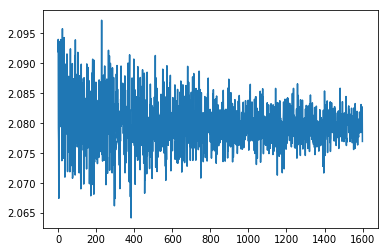

1000 12.5% (0.0m 44.81717491149902s) 2.089 / Quantitative Biology X Economics
2000 25.0% (1.0m 29.59801173210144s) 2.074 / Quantitative Biology X Computer Science
3000 37.5% (2.0m 14.471875667572021s) 2.087 / Quantitative Biology X Statistics
4000 50.0% (2.0m 59.41039228439331s) 2.078 / Quantitative Biology V
5000 62.5% (3.0m 44.35710787773132s) 2.08 / Quantitative Biology X Computer Science
6000 75.0% (4.0m 29.287827968597412s) 2.092 / Quantitative Biology X Quantitative Finance
7000 87.5% (5.0m 13.9976327419281s) 2.08 / Quantitative Biology V
8000 100.0% (5.0m 59.041000843048096s) 2.085 / Quantitative Biology X Electrical Engineering and Systems Science
learning rate and characters used: 0.0001 200


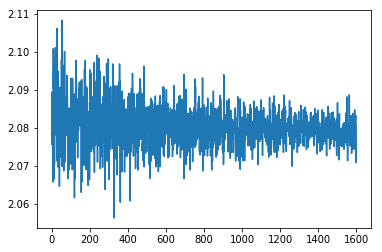

1000 12.5% (0.0m 55.823399782180786s) 2.057 / Physics V
2000 25.0% (1.0m 51.402443170547485s) 2.074 / Physics X Mathematics
3000 37.5% (2.0m 47.14807939529419s) 2.076 / Statistics X Electrical Engineering and Systems Science
4000 50.0% (3.0m 43.01314353942871s) 2.087 / Electrical Engineering and Systems Science X Mathematics
5000 62.5% (4.0m 38.68754816055298s) 2.083 / Physics X Quantitative Finance
6000 75.0% (5.0m 34.54566216468811s) 2.072 / Statistics X Physics
7000 87.5% (6.0m 30.310179233551025s) 2.078 / Electrical Engineering and Systems Science X Computer Science
8000 100.0% (7.0m 25.908225774765015s) 2.065 / Economics X Computer Science
learning rate and characters used: 0.0001 250


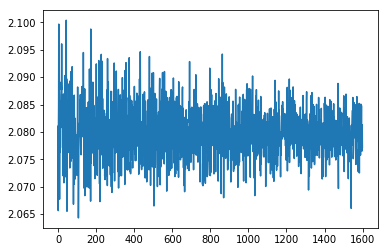

1000 12.5% (1.0m 7.362351179122925s) 2.084 / Computer Science X Physics
2000 25.0% (2.0m 14.561982154846191s) 2.075 / Computer Science X Quantitative Finance
3000 37.5% (3.0m 21.831236124038696s) 2.089 / Computer Science X Quantitative Finance
4000 50.0% (4.0m 29.115728855133057s) 2.095 / Computer Science X Quantitative Finance
5000 62.5% (5.0m 36.49645113945007s) 2.072 / Computer Science X Quantitative Biology
6000 75.0% (6.0m 43.9617486000061s) 2.082 / Computer Science X Statistics
7000 87.5% (7.0m 51.35473299026489s) 2.074 / Computer Science X Statistics
8000 100.0% (8.0m 58.6577353477478s) 2.074 / Physics V
learning rate and characters used: 0.0001 300


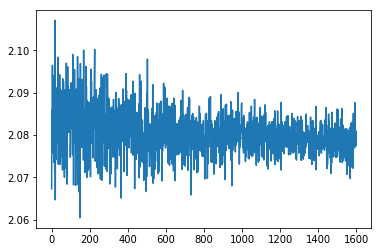

1000 12.5% (1.0m 16.320514678955078s) 2.042 / Physics X Economics
2000 25.0% (2.0m 32.577033042907715s) 2.072 / Physics X Quantitative Finance
3000 37.5% (3.0m 48.77420949935913s) 2.063 / Physics V
4000 50.0% (5.0m 4.918605089187622s) 2.072 / Physics X Statistics
5000 62.5% (6.0m 20.980151176452637s) 2.086 / Physics X Electrical Engineering and Systems Science
6000 75.0% (7.0m 37.482786655426025s) 2.071 / Physics V
7000 87.5% (8.0m 53.7139630317688s) 2.059 / Physics X Statistics
8000 100.0% (10.0m 10.165493965148926s) 2.122 / Physics X Quantitative Finance
learning rate and characters used: 0.0001 350


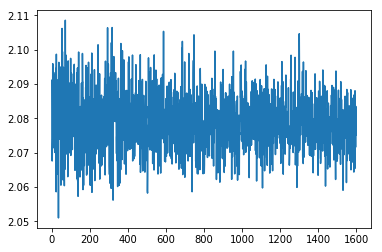

1000 12.5% (1.0m 26.693602085113525s) 2.068 / Quantitative Biology V
2000 25.0% (2.0m 52.65750813484192s) 2.092 / Quantitative Biology X Physics
3000 37.5% (4.0m 18.797125101089478s) 2.079 / Quantitative Biology X Mathematics
4000 50.0% (5.0m 44.47534680366516s) 2.098 / Quantitative Biology X Computer Science
5000 62.5% (7.0m 10.738858699798584s) 2.064 / Quantitative Biology X Quantitative Finance
6000 75.0% (8.0m 36.815656900405884s) 2.057 / Quantitative Biology X Economics
7000 87.5% (10.0m 3.1121013164520264s) 2.082 / Quantitative Biology X Quantitative Finance
8000 100.0% (11.0m 28.850536346435547s) 2.095 / Quantitative Biology X Computer Science
learning rate and characters used: 0.0001 400


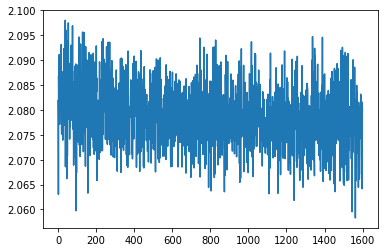

1000 12.5% (1.0m 41.52603220939636s) 2.095 / Computer Science X Economics
2000 25.0% (3.0m 23.424269676208496s) 2.078 / Economics X Computer Science
3000 37.5% (5.0m 5.378863096237183s) 2.075 / Economics X Electrical Engineering and Systems Science
4000 50.0% (6.0m 47.766258239746094s) 2.049 / Economics X Statistics
5000 62.5% (8.0m 29.927292585372925s) 2.085 / Economics V
6000 75.0% (10.0m 12.378447532653809s) 2.068 / Economics X Statistics
7000 87.5% (11.0m 55.10609722137451s) 2.053 / Economics V
8000 100.0% (13.0m 37.3764374256134s) 2.082 / Economics X Physics
learning rate and characters used: 0.0001 450


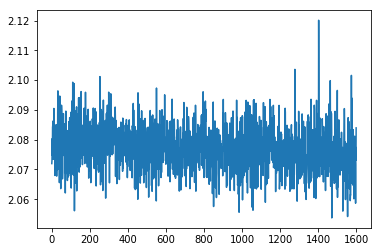

1000 12.5% (1.0m 54.50635480880737s) 2.091 / Electrical Engineering and Systems Science X Quantitative Biology
2000 25.0% (3.0m 49.41869020462036s) 2.082 / Electrical Engineering and Systems Science X Economics
3000 37.5% (5.0m 44.339263916015625s) 2.077 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (7.0m 38.96204447746277s) 2.061 / Electrical Engineering and Systems Science V
5000 62.5% (9.0m 34.360068798065186s) 2.081 / Quantitative Biology X Economics
6000 75.0% (11.0m 29.694438457489014s) 2.09 / Electrical Engineering and Systems Science X Economics
7000 87.5% (13.0m 25.142343521118164s) 2.061 / Electrical Engineering and Systems Science X Economics
8000 100.0% (15.0m 21.00519108772278s) 2.118 / Electrical Engineering and Systems Science X Computer Science
learning rate and characters used: 0.0001 500


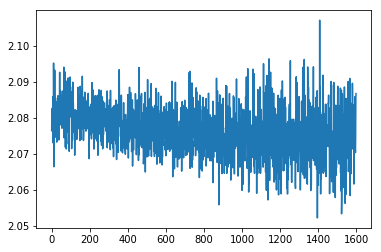

1000 12.5% (2.0m 2.411583423614502s) 2.057 / Electrical Engineering and Systems Science X Quantitative Finance
2000 25.0% (4.0m 4.8122782707214355s) 2.07 / Electrical Engineering and Systems Science X Physics
3000 37.5% (6.0m 7.6464784145355225s) 2.063 / Electrical Engineering and Systems Science X Statistics
4000 50.0% (8.0m 10.582992315292358s) 2.068 / Electrical Engineering and Systems Science X Quantitative Finance
5000 62.5% (10.0m 13.54097056388855s) 2.093 / Electrical Engineering and Systems Science X Quantitative Biology
6000 75.0% (12.0m 16.560218334197998s) 2.067 / Electrical Engineering and Systems Science V
7000 87.5% (14.0m 19.60191774368286s) 2.06 / Electrical Engineering and Systems Science X Physics
8000 100.0% (16.0m 22.804085969924927s) 2.092 / Electrical Engineering and Systems Science X Physics
learning rate and characters used: 0.0001 550


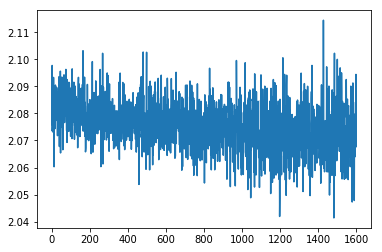

1000 12.5% (2.0m 14.765499353408813s) 2.077 / Economics X Computer Science
2000 25.0% (4.0m 29.20092797279358s) 2.07 / Economics X Statistics
3000 37.5% (6.0m 43.58604431152344s) 2.086 / Economics X Statistics
4000 50.0% (8.0m 58.31660795211792s) 2.06 / Economics X Quantitative Biology
5000 62.5% (11.0m 11.858947515487671s) 2.054 / Economics X Physics
6000 75.0% (13.0m 25.834144115447998s) 2.087 / Economics X Quantitative Biology
7000 87.5% (15.0m 39.367252826690674s) 2.053 / Economics X Statistics
8000 100.0% (17.0m 54.12151288986206s) 2.069 / Economics X Quantitative Finance
learning rate and characters used: 0.0001 600


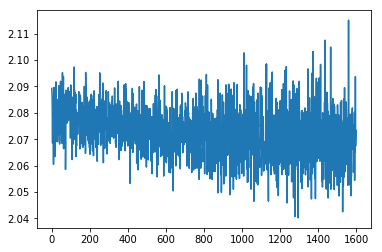

1000 12.5% (2.0m 28.917881727218628s) 2.091 / Computer Science X Mathematics
2000 25.0% (4.0m 58.21375894546509s) 2.074 / Computer Science X Physics
3000 37.5% (7.0m 27.4390971660614s) 2.058 / Computer Science X Electrical Engineering and Systems Science
4000 50.0% (9.0m 55.909538984298706s) 2.072 / Computer Science V
5000 62.5% (12.0m 24.01537275314331s) 2.076 / Electrical Engineering and Systems Science V
6000 75.0% (14.0m 51.28082895278931s) 2.036 / Electrical Engineering and Systems Science V
7000 87.5% (17.0m 19.43353843688965s) 2.055 / Electrical Engineering and Systems Science X Economics
8000 100.0% (19.0m 47.05968475341797s) 2.119 / Electrical Engineering and Systems Science X Mathematics
learning rate and characters used: 0.0001 650


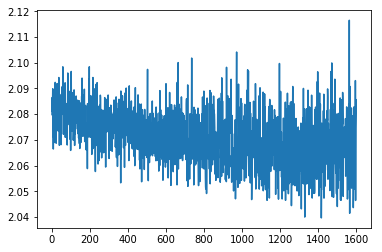

1000 12.5% (0.0m 12.81196141242981s) 2.065 / Economics V
2000 25.0% (0.0m 25.70810890197754s) 2.08 / Economics X Quantitative Biology
3000 37.5% (0.0m 38.74852228164673s) 2.076 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (0.0m 51.741424322128296s) 2.078 / Quantitative Finance X Mathematics
5000 62.5% (1.0m 4.638625860214233s) 2.074 / Economics X Computer Science
6000 75.0% (1.0m 17.532641887664795s) 2.081 / Computer Science X Physics
7000 87.5% (1.0m 30.4413423538208s) 2.083 / Computer Science X Economics
8000 100.0% (1.0m 43.323516607284546s) 2.078 / Mathematics V
learning rate and characters used: 0.0005 50


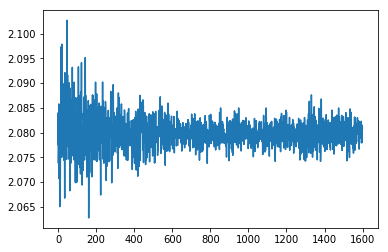

1000 12.5% (0.0m 23.74215054512024s) 2.078 / Economics X Mathematics
2000 25.0% (0.0m 47.32364058494568s) 2.07 / Statistics X Physics
3000 37.5% (1.0m 10.931783437728882s) 2.093 / Physics X Quantitative Finance
4000 50.0% (1.0m 34.62517309188843s) 2.085 / Statistics X Electrical Engineering and Systems Science
5000 62.5% (1.0m 58.31200122833252s) 2.073 / Economics X Quantitative Finance
6000 75.0% (2.0m 22.04023575782776s) 2.064 / Mathematics X Economics
7000 87.5% (2.0m 45.69891953468323s) 2.069 / Physics X Quantitative Biology
8000 100.0% (3.0m 9.473472356796265s) 2.075 / Physics X Economics
learning rate and characters used: 0.0005 100


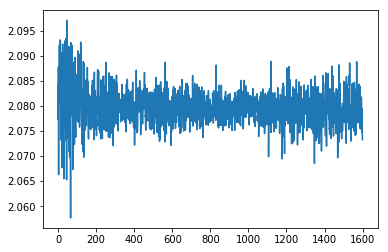

1000 12.5% (0.0m 34.435391426086426s) 2.078 / Quantitative Finance V
2000 25.0% (1.0m 9.037827491760254s) 2.079 / Quantitative Biology X Physics
3000 37.5% (1.0m 43.34955310821533s) 2.079 / Mathematics X Electrical Engineering and Systems Science
4000 50.0% (2.0m 17.721853017807007s) 2.063 / Physics X Mathematics
5000 62.5% (2.0m 52.295960426330566s) 2.086 / Economics X Quantitative Biology
6000 75.0% (3.0m 26.631306886672974s) 2.087 / Statistics X Quantitative Biology
7000 87.5% (4.0m 1.0493547916412354s) 2.083 / Electrical Engineering and Systems Science X Physics
8000 100.0% (4.0m 35.522892475128174s) 2.069 / Quantitative Finance X Economics
learning rate and characters used: 0.0005 150


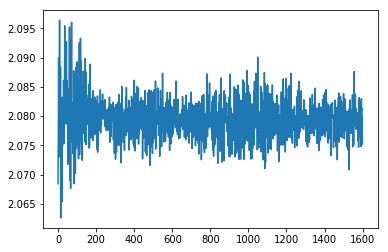

1000 12.5% (0.0m 44.891000270843506s) 2.084 / Statistics X Quantitative Finance
2000 25.0% (1.0m 29.777801990509033s) 2.08 / Statistics X Quantitative Finance
3000 37.5% (2.0m 14.73509693145752s) 2.066 / Statistics X Physics
4000 50.0% (2.0m 59.551939487457275s) 2.076 / Statistics X Quantitative Biology
5000 62.5% (3.0m 44.55709910392761s) 2.076 / Computer Science X Quantitative Biology
6000 75.0% (4.0m 29.622206687927246s) 2.076 / Quantitative Biology X Electrical Engineering and Systems Science
7000 87.5% (5.0m 14.945121765136719s) 2.091 / Quantitative Biology X Quantitative Finance
8000 100.0% (6.0m 0.10892629623413086s) 2.082 / Electrical Engineering and Systems Science X Statistics
learning rate and characters used: 0.0005 200


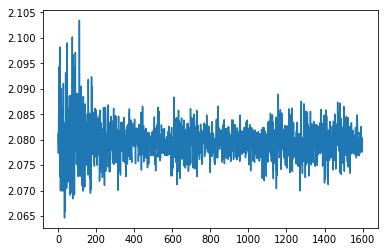

1000 12.5% (0.0m 56.248401165008545s) 2.08 / Quantitative Finance X Statistics
2000 25.0% (1.0m 52.35392737388611s) 2.087 / Quantitative Finance X Mathematics
3000 37.5% (2.0m 48.30668306350708s) 2.08 / Economics X Statistics
4000 50.0% (3.0m 44.11734390258789s) 2.066 / Statistics X Electrical Engineering and Systems Science
5000 62.5% (4.0m 40.09937524795532s) 2.083 / Statistics X Economics
6000 75.0% (5.0m 36.023621797561646s) 2.081 / Quantitative Biology X Physics
7000 87.5% (6.0m 31.88950514793396s) 2.085 / Quantitative Biology X Computer Science
8000 100.0% (7.0m 27.827853441238403s) 2.079 / Quantitative Finance X Economics
learning rate and characters used: 0.0005 250


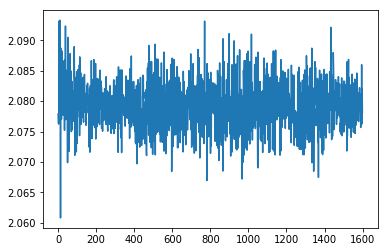

1000 12.5% (1.0m 7.275249242782593s) 2.092 / Physics X Economics
2000 25.0% (2.0m 14.66825532913208s) 2.086 / Statistics X Physics
3000 37.5% (3.0m 21.87209153175354s) 2.082 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (4.0m 29.089805364608765s) 2.081 / Statistics X Quantitative Biology
5000 62.5% (5.0m 36.09184265136719s) 2.079 / Electrical Engineering and Systems Science X Physics
6000 75.0% (6.0m 43.34467554092407s) 2.072 / Physics X Statistics
7000 87.5% (7.0m 50.377548694610596s) 2.079 / Electrical Engineering and Systems Science X Quantitative Biology
8000 100.0% (8.0m 57.70051908493042s) 2.082 / Economics X Mathematics
learning rate and characters used: 0.0005 300


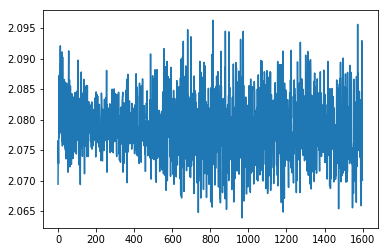

1000 12.5% (1.0m 16.289923667907715s) 2.099 / Economics X Physics
2000 25.0% (2.0m 32.28214430809021s) 2.07 / Quantitative Biology X Physics
3000 37.5% (3.0m 48.583844900131226s) 2.072 / Economics X Quantitative Biology
4000 50.0% (5.0m 4.643480062484741s) 2.075 / Economics X Physics
5000 62.5% (6.0m 21.144285917282104s) 2.082 / Electrical Engineering and Systems Science X Economics
6000 75.0% (7.0m 37.03437161445618s) 2.106 / Statistics X Mathematics
7000 87.5% (8.0m 53.2937753200531s) 2.09 / Electrical Engineering and Systems Science X Mathematics
8000 100.0% (10.0m 9.698363304138184s) 2.078 / Statistics X Economics
learning rate and characters used: 0.0005 350


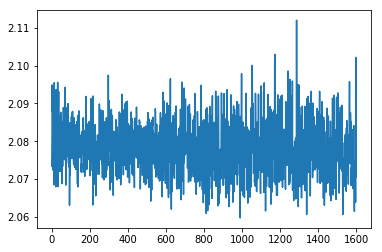

1000 12.5% (1.0m 26.16553020477295s) 2.039 / Economics V
2000 25.0% (2.0m 53.15835380554199s) 2.128 / Quantitative Biology X Economics
3000 37.5% (4.0m 20.25278115272522s) 2.074 / Electrical Engineering and Systems Science V
4000 50.0% (5.0m 47.887516021728516s) 2.071 / Electrical Engineering and Systems Science X Computer Science
5000 62.5% (7.0m 14.572810649871826s) 2.055 / Economics X Quantitative Biology
6000 75.0% (8.0m 41.52597212791443s) 2.063 / Physics X Quantitative Biology
7000 87.5% (10.0m 8.147644281387329s) 2.052 / Quantitative Biology V
8000 100.0% (11.0m 34.59844994544983s) 2.114 / Statistics X Mathematics
learning rate and characters used: 0.0005 400


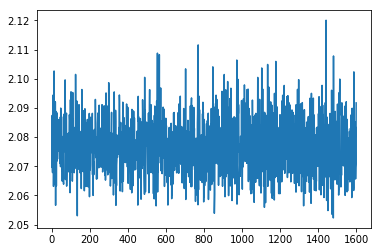

1000 12.5% (1.0m 41.9054811000824s) 2.058 / Economics X Physics
2000 25.0% (3.0m 24.062464952468872s) 2.1 / Electrical Engineering and Systems Science X Mathematics
3000 37.5% (5.0m 6.39847207069397s) 2.055 / Electrical Engineering and Systems Science X Computer Science
4000 50.0% (6.0m 48.633705139160156s) 2.077 / Quantitative Biology V
5000 62.5% (8.0m 30.66213321685791s) 2.093 / Quantitative Biology X Computer Science
6000 75.0% (10.0m 12.67563247680664s) 2.114 / Electrical Engineering and Systems Science V
7000 87.5% (11.0m 54.91318154335022s) 2.088 / Economics X Quantitative Biology
8000 100.0% (13.0m 37.12138247489929s) 2.114 / Quantitative Biology X Quantitative Finance
learning rate and characters used: 0.0005 450


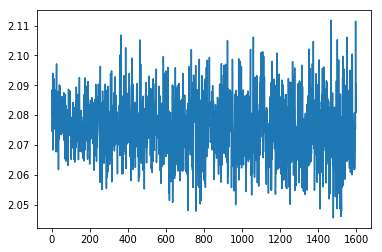

1000 12.5% (1.0m 55.50274968147278s) 2.065 / Computer Science X Economics
2000 25.0% (3.0m 51.221043825149536s) 2.049 / Economics X Electrical Engineering and Systems Science
3000 37.5% (5.0m 46.547622203826904s) 2.094 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (7.0m 42.05008268356323s) 2.107 / Electrical Engineering and Systems Science X Mathematics
5000 62.5% (9.0m 37.35338568687439s) 2.067 / Economics X Statistics
6000 75.0% (11.0m 33.41412663459778s) 2.04 / Economics X Computer Science
7000 87.5% (13.0m 28.67710304260254s) 2.069 / Electrical Engineering and Systems Science X Economics
8000 100.0% (15.0m 23.427141427993774s) 2.034 / Electrical Engineering and Systems Science X Computer Science
learning rate and characters used: 0.0005 500


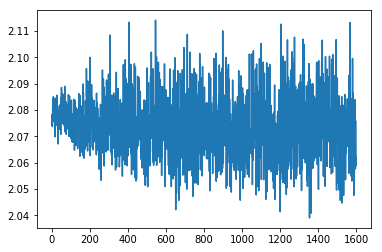

1000 12.5% (2.0m 1.8363091945648193s) 2.074 / Physics X Quantitative Finance
2000 25.0% (4.0m 3.680651903152466s) 2.073 / Electrical Engineering and Systems Science V
3000 37.5% (6.0m 6.24403715133667s) 2.079 / Electrical Engineering and Systems Science X Economics
4000 50.0% (8.0m 8.831049919128418s) 2.079 / Electrical Engineering and Systems Science X Physics
5000 62.5% (10.0m 11.28961730003357s) 2.07 / Statistics X Physics
6000 75.0% (12.0m 14.61082410812378s) 2.073 / Electrical Engineering and Systems Science X Mathematics
7000 87.5% (14.0m 17.300940990447998s) 2.034 / Electrical Engineering and Systems Science X Physics
8000 100.0% (16.0m 20.452507495880127s) 2.043 / Electrical Engineering and Systems Science X Economics
learning rate and characters used: 0.0005 550


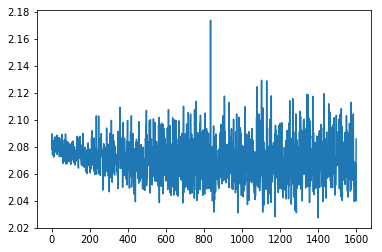

1000 12.5% (2.0m 15.276352405548096s) 2.062 / Statistics X Quantitative Finance
2000 25.0% (4.0m 30.30611538887024s) 2.022 / Economics X Statistics
3000 37.5% (6.0m 45.47899270057678s) 2.005 / Electrical Engineering and Systems Science X Economics
4000 50.0% (9.0m 0.7508237361907959s) 2.083 / Statistics X Quantitative Finance
5000 62.5% (11.0m 15.341639995574951s) 2.154 / Statistics X Mathematics
6000 75.0% (13.0m 29.60565495491028s) 2.039 / Electrical Engineering and Systems Science X Statistics
7000 87.5% (15.0m 43.704676389694214s) 2.052 / Electrical Engineering and Systems Science X Mathematics
8000 100.0% (17.0m 58.09975981712341s) 2.157 / Economics X Quantitative Biology
learning rate and characters used: 0.0005 600


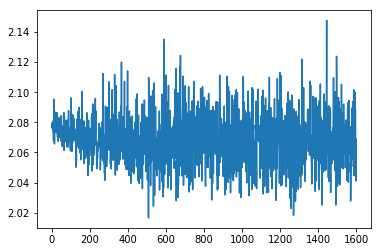

1000 12.5% (2.0m 27.809860229492188s) 2.08 / Electrical Engineering and Systems Science X Statistics
2000 25.0% (4.0m 57.285178899765015s) 2.035 / Quantitative Biology X Quantitative Finance
3000 37.5% (7.0m 25.106210231781006s) 2.094 / Electrical Engineering and Systems Science X Statistics
4000 50.0% (9.0m 53.25034165382385s) 2.098 / Electrical Engineering and Systems Science X Mathematics
5000 62.5% (12.0m 20.671298027038574s) 2.088 / Statistics X Economics
6000 75.0% (14.0m 48.63736176490784s) 2.13 / Electrical Engineering and Systems Science X Economics
7000 87.5% (17.0m 15.572336673736572s) 2.035 / Electrical Engineering and Systems Science X Mathematics
8000 100.0% (19.0m 42.12358260154724s) 2.134 / Quantitative Biology X Quantitative Finance
learning rate and characters used: 0.0005 650


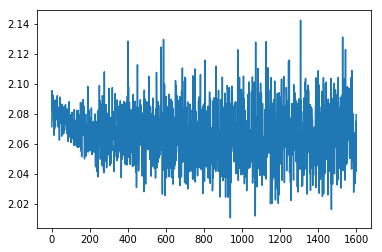

1000 12.5% (0.0m 12.881471633911133s) 2.09 / Computer Science X Quantitative Finance
2000 25.0% (0.0m 25.77340793609619s) 2.079 / Quantitative Biology X Computer Science
3000 37.5% (0.0m 38.7170729637146s) 2.08 / Physics X Mathematics
4000 50.0% (0.0m 51.73109793663025s) 2.078 / Mathematics X Statistics
5000 62.5% (1.0m 4.6700499057769775s) 2.096 / Physics X Statistics
6000 75.0% (1.0m 17.601791381835938s) 2.064 / Mathematics X Statistics
7000 87.5% (1.0m 30.53598666191101s) 2.057 / Computer Science X Electrical Engineering and Systems Science
8000 100.0% (1.0m 43.43433451652527s) 2.075 / Physics X Computer Science
learning rate and characters used: 0.005 50


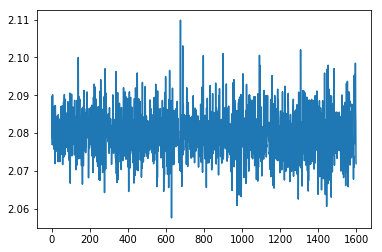

1000 12.5% (0.0m 23.793802976608276s) 2.072 / Quantitative Finance X Mathematics
2000 25.0% (0.0m 47.59167194366455s) 2.087 / Quantitative Biology X Economics
3000 37.5% (1.0m 11.366981744766235s) 2.081 / Physics X Electrical Engineering and Systems Science
4000 50.0% (1.0m 35.11984300613403s) 2.092 / Quantitative Biology X Quantitative Finance
5000 62.5% (1.0m 59.072359561920166s) 2.073 / Mathematics X Computer Science
6000 75.0% (2.0m 22.90224266052246s) 2.095 / Quantitative Biology X Electrical Engineering and Systems Science
7000 87.5% (2.0m 46.73011541366577s) 2.087 / Physics X Electrical Engineering and Systems Science
8000 100.0% (3.0m 10.663534879684448s) 2.073 / Quantitative Biology V
learning rate and characters used: 0.005 100


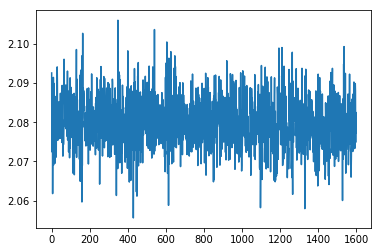

1000 12.5% (0.0m 34.39459586143494s) 2.085 / Statistics V
2000 25.0% (1.0m 8.769869565963745s) 2.059 / Quantitative Finance V
3000 37.5% (1.0m 43.21253037452698s) 2.081 / Computer Science X Economics
4000 50.0% (2.0m 17.589476585388184s) 2.072 / Quantitative Biology X Mathematics
5000 62.5% (2.0m 52.116299629211426s) 2.068 / Physics X Electrical Engineering and Systems Science
6000 75.0% (3.0m 26.528167009353638s) 2.09 / Quantitative Finance X Electrical Engineering and Systems Science
7000 87.5% (4.0m 1.082873821258545s) 2.067 / Electrical Engineering and Systems Science X Statistics
8000 100.0% (4.0m 35.48749828338623s) 2.077 / Physics X Quantitative Finance
learning rate and characters used: 0.005 150


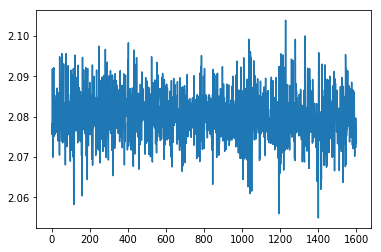

1000 12.5% (0.0m 45.37939167022705s) 2.07 / Physics X Mathematics
2000 25.0% (1.0m 30.511808156967163s) 2.064 / Quantitative Finance X Mathematics
3000 37.5% (2.0m 15.668150901794434s) 2.076 / Electrical Engineering and Systems Science X Economics
4000 50.0% (3.0m 0.7861843109130859s) 2.079 / Economics X Electrical Engineering and Systems Science
5000 62.5% (3.0m 46.02717423439026s) 2.069 / Quantitative Biology X Physics
6000 75.0% (4.0m 31.127482175827026s) 2.081 / Physics X Quantitative Biology
7000 87.5% (5.0m 16.432578325271606s) 2.078 / Statistics X Computer Science
8000 100.0% (6.0m 1.5328657627105713s) 2.065 / Physics X Computer Science
learning rate and characters used: 0.005 200


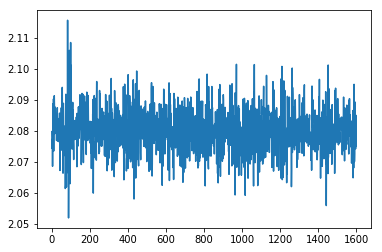

1000 12.5% (0.0m 56.002485275268555s) 2.093 / Economics X Statistics
2000 25.0% (1.0m 51.88927888870239s) 2.085 / Computer Science X Statistics
3000 37.5% (2.0m 47.89107012748718s) 2.067 / Physics X Computer Science
4000 50.0% (3.0m 43.896445512771606s) 2.11 / Electrical Engineering and Systems Science X Quantitative Finance
5000 62.5% (4.0m 39.83629894256592s) 2.06 / Computer Science V
6000 75.0% (5.0m 35.64443588256836s) 2.102 / Computer Science X Economics
7000 87.5% (6.0m 31.284651041030884s) 2.082 / Economics X Quantitative Biology
8000 100.0% (7.0m 27.137348175048828s) 2.055 / Computer Science V
learning rate and characters used: 0.005 250


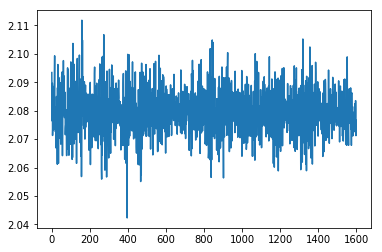

1000 12.5% (1.0m 7.312216281890869s) 2.076 / Electrical Engineering and Systems Science X Computer Science
2000 25.0% (2.0m 14.815125465393066s) 2.088 / Economics X Physics
3000 37.5% (3.0m 22.198882818222046s) 2.061 / Quantitative Biology X Computer Science
4000 50.0% (4.0m 29.56402063369751s) 2.073 / Economics X Electrical Engineering and Systems Science
5000 62.5% (5.0m 38.871025800704956s) 2.051 / Statistics V
6000 75.0% (6.0m 47.28229808807373s) 2.08 / Quantitative Finance X Quantitative Biology
7000 87.5% (7.0m 55.59305286407471s) 2.099 / Economics V
8000 100.0% (9.0m 3.6793999671936035s) 2.099 / Statistics X Electrical Engineering and Systems Science
learning rate and characters used: 0.005 300


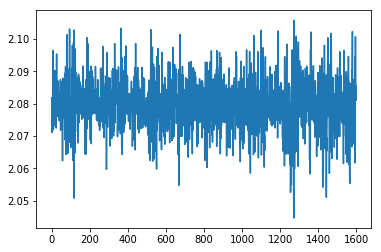

1000 12.5% (1.0m 17.51748824119568s) 2.089 / Physics X Economics
2000 25.0% (2.0m 34.48280096054077s) 2.071 / Economics X Statistics
3000 37.5% (3.0m 52.1277117729187s) 2.097 / Statistics X Quantitative Biology
4000 50.0% (5.0m 8.842666864395142s) 2.045 / Computer Science V
5000 62.5% (6.0m 25.655718564987183s) 2.038 / Quantitative Biology X Economics
6000 75.0% (7.0m 42.382702589035034s) 2.098 / Electrical Engineering and Systems Science X Computer Science
7000 87.5% (8.0m 59.69005465507507s) 2.073 / Electrical Engineering and Systems Science X Statistics
8000 100.0% (10.0m 17.009772777557373s) 2.168 / Computer Science X Mathematics
learning rate and characters used: 0.005 350


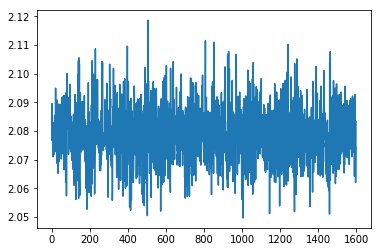

1000 12.5% (1.0m 27.973918676376343s) 2.066 / Physics X Computer Science
2000 25.0% (2.0m 55.32104444503784s) 2.059 / Quantitative Biology X Physics
3000 37.5% (4.0m 22.623311758041382s) 2.047 / Quantitative Biology X Economics
4000 50.0% (5.0m 50.80595898628235s) 2.07 / Statistics X Physics
5000 62.5% (7.0m 18.2415132522583s) 2.086 / Statistics V
6000 75.0% (8.0m 46.48125410079956s) 2.106 / Electrical Engineering and Systems Science X Quantitative Finance
7000 87.5% (10.0m 14.007917642593384s) 2.038 / Computer Science X Economics
8000 100.0% (11.0m 41.842459201812744s) 2.087 / Physics X Quantitative Finance
learning rate and characters used: 0.005 400


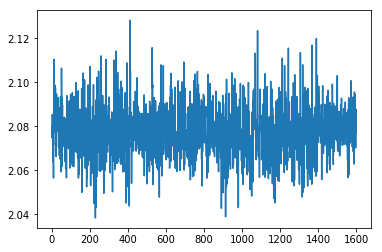

1000 12.5% (1.0m 42.7729115486145s) 2.067 / Electrical Engineering and Systems Science X Computer Science
2000 25.0% (3.0m 25.406676054000854s) 2.068 / Economics X Mathematics
3000 37.5% (5.0m 7.783794641494751s) 2.082 / Physics X Electrical Engineering and Systems Science
4000 50.0% (6.0m 50.553850173950195s) 2.105 / Economics X Electrical Engineering and Systems Science
5000 62.5% (8.0m 32.88981866836548s) 2.076 / Economics X Quantitative Biology
6000 75.0% (10.0m 15.691091537475586s) 2.052 / Economics V
7000 87.5% (11.0m 58.8484787940979s) 2.027 / Physics X Electrical Engineering and Systems Science
8000 100.0% (13.0m 41.57603335380554s) 2.084 / Electrical Engineering and Systems Science X Computer Science
learning rate and characters used: 0.005 450


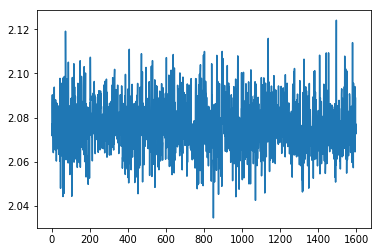

1000 12.5% (1.0m 55.211440563201904s) 2.034 / Economics X Physics
2000 25.0% (3.0m 51.115622758865356s) 2.135 / Quantitative Biology X Economics
3000 37.5% (5.0m 46.25092315673828s) 2.03 / Quantitative Biology X Quantitative Finance
4000 50.0% (7.0m 41.07912850379944s) 2.08 / Electrical Engineering and Systems Science X Quantitative Finance
5000 62.5% (9.0m 35.93502879142761s) 2.027 / Electrical Engineering and Systems Science X Economics
6000 75.0% (11.0m 31.260308980941772s) 2.087 / Economics X Computer Science
7000 87.5% (13.0m 26.17014169692993s) 2.056 / Economics X Quantitative Biology
8000 100.0% (15.0m 21.313449382781982s) 2.051 / Physics X Quantitative Finance
learning rate and characters used: 0.005 500


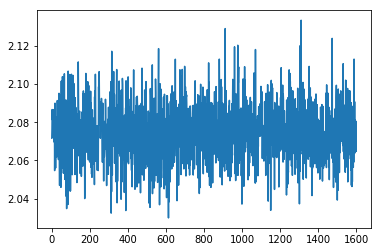

1000 12.5% (2.0m 3.2004454135894775s) 2.027 / Quantitative Biology X Computer Science
2000 25.0% (4.0m 7.261502981185913s) 2.021 / Computer Science X Quantitative Biology
3000 37.5% (6.0m 10.97597336769104s) 2.11 / Economics V
4000 50.0% (8.0m 15.259309768676758s) 2.028 / Electrical Engineering and Systems Science X Quantitative Biology
5000 62.5% (10.0m 19.033818006515503s) 2.076 / Computer Science X Quantitative Biology
6000 75.0% (12.0m 22.316688299179077s) 2.055 / Economics V
7000 87.5% (14.0m 25.662976264953613s) 2.064 / Electrical Engineering and Systems Science V
8000 100.0% (16.0m 28.87307858467102s) 2.087 / Statistics X Quantitative Biology
learning rate and characters used: 0.005 550


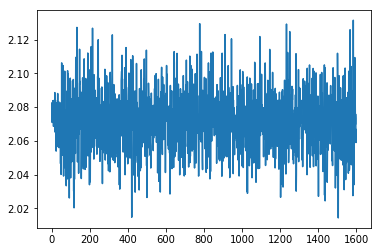

1000 12.5% (2.0m 15.176348447799683s) 2.008 / Quantitative Biology V
2000 25.0% (4.0m 29.701545476913452s) 2.075 / Electrical Engineering and Systems Science X Economics
3000 37.5% (6.0m 44.39619541168213s) 2.088 / Economics X Computer Science
4000 50.0% (8.0m 59.36982011795044s) 2.033 / Statistics X Computer Science
5000 62.5% (11.0m 13.930723905563354s) 2.047 / Electrical Engineering and Systems Science X Quantitative Biology
6000 75.0% (13.0m 28.95948553085327s) 2.049 / Statistics X Computer Science
7000 87.5% (15.0m 43.163856983184814s) 2.055 / Electrical Engineering and Systems Science V
8000 100.0% (17.0m 57.46065616607666s) 2.021 / Physics X Quantitative Biology
learning rate and characters used: 0.005 600


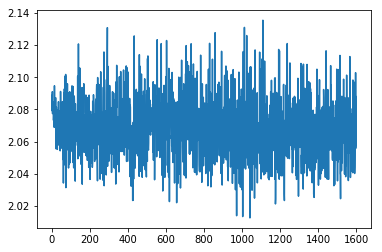

1000 12.5% (2.0m 28.967337608337402s) 2.029 / Economics X Statistics
2000 25.0% (4.0m 56.850799322128296s) 2.056 / Electrical Engineering and Systems Science X Physics
3000 37.5% (7.0m 24.67434310913086s) 2.199 / Quantitative Biology X Quantitative Finance
4000 50.0% (9.0m 53.1583456993103s) 2.061 / Electrical Engineering and Systems Science X Mathematics
5000 62.5% (12.0m 20.116429328918457s) 2.018 / Quantitative Biology X Statistics
6000 75.0% (14.0m 48.05675721168518s) 1.999 / Economics X Electrical Engineering and Systems Science
7000 87.5% (17.0m 14.869073390960693s) 1.99 / Electrical Engineering and Systems Science X Quantitative Biology
8000 100.0% (19.0m 42.53535866737366s) 2.139 / Electrical Engineering and Systems Science X Computer Science
learning rate and characters used: 0.005 650


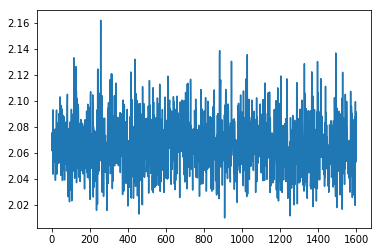

1000 12.5% (0.0m 12.905349493026733s) 2.063 / Physics X Economics
2000 25.0% (0.0m 25.95621609687805s) 2.062 / Statistics V
3000 37.5% (0.0m 38.9950737953186s) 2.088 / Quantitative Finance X Statistics
4000 50.0% (0.0m 51.98199820518494s) 2.053 / Quantitative Finance X Computer Science
5000 62.5% (1.0m 5.116796016693115s) 2.102 / Mathematics V
6000 75.0% (1.0m 18.139018774032593s) 2.1 / Statistics X Quantitative Biology
7000 87.5% (1.0m 31.113309144973755s) 2.058 / Economics X Quantitative Finance
8000 100.0% (1.0m 44.11865854263306s) 2.08 / Quantitative Finance V
learning rate and characters used: 0.01 50


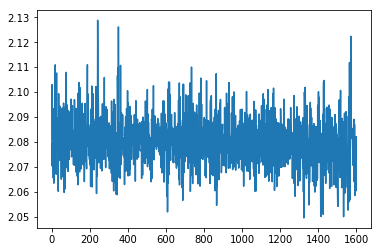

1000 12.5% (0.0m 23.877098321914673s) 2.114 / Mathematics X Electrical Engineering and Systems Science
2000 25.0% (0.0m 47.64671802520752s) 2.074 / Electrical Engineering and Systems Science X Economics
3000 37.5% (1.0m 11.3633291721344s) 2.129 / Mathematics X Statistics
4000 50.0% (1.0m 35.23550796508789s) 2.082 / Quantitative Biology X Physics
5000 62.5% (1.0m 58.98845934867859s) 2.067 / Quantitative Finance X Quantitative Biology
6000 75.0% (2.0m 22.800912141799927s) 2.063 / Economics X Mathematics
7000 87.5% (2.0m 46.68334722518921s) 2.099 / Quantitative Finance X Mathematics
8000 100.0% (3.0m 10.58563780784607s) 2.113 / Quantitative Biology X Statistics
learning rate and characters used: 0.01 100


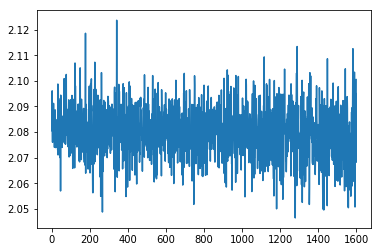

1000 12.5% (0.0m 34.67028260231018s) 2.079 / Electrical Engineering and Systems Science V
2000 25.0% (1.0m 9.354740142822266s) 2.098 / Electrical Engineering and Systems Science X Computer Science
3000 37.5% (1.0m 44.09607410430908s) 2.062 / Statistics X Physics
4000 50.0% (2.0m 18.769638538360596s) 2.063 / Physics V
5000 62.5% (2.0m 53.391146659851074s) 2.086 / Economics X Electrical Engineering and Systems Science
6000 75.0% (3.0m 28.0140860080719s) 2.064 / Mathematics X Economics
7000 87.5% (4.0m 2.657806634902954s) 2.071 / Physics V
8000 100.0% (4.0m 37.269267559051514s) 2.087 / Economics X Electrical Engineering and Systems Science
learning rate and characters used: 0.01 150


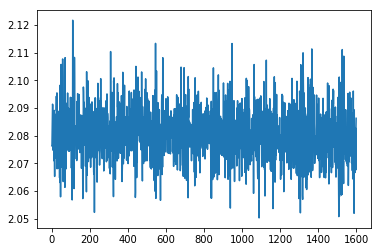

1000 12.5% (0.0m 45.19064426422119s) 2.048 / Statistics X Economics
2000 25.0% (1.0m 30.172850847244263s) 2.06 / Quantitative Biology X Quantitative Finance
3000 37.5% (2.0m 15.544255018234253s) 2.121 / Economics X Computer Science
4000 50.0% (3.0m 0.6324737071990967s) 2.083 / Computer Science V
5000 62.5% (3.0m 45.645390033721924s) 2.065 / Physics V
6000 75.0% (4.0m 30.683512210845947s) 2.083 / Computer Science X Statistics
7000 87.5% (5.0m 15.826816082000732s) 2.063 / Electrical Engineering and Systems Science X Mathematics
8000 100.0% (6.0m 1.0934762954711914s) 2.104 / Quantitative Finance X Computer Science
learning rate and characters used: 0.01 200


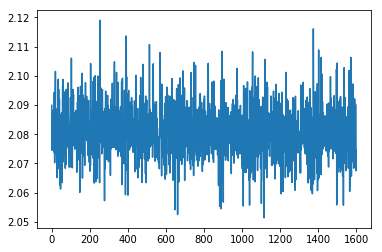

1000 12.5% (0.0m 55.86821269989014s) 2.072 / Electrical Engineering and Systems Science V
2000 25.0% (1.0m 51.93787932395935s) 2.077 / Quantitative Finance X Quantitative Biology
3000 37.5% (2.0m 47.887606620788574s) 2.095 / Computer Science X Physics
4000 50.0% (3.0m 43.757229804992676s) 2.093 / Electrical Engineering and Systems Science X Quantitative Biology


In [0]:
#DO NOT RUN



#EXPERIMENT CHANGING INPUT SIZE AND LEARNING RATE


learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=50;               #this is the minimum abstract length we are testing our model on
max_length=700
print_every = 1000
plot_every = 5

for learning_rate in (0.0001, 0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in range (minimum, max_length, 50):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 12.5% (0.0m 12.768283367156982s) 1.812 / Physics X Computer Science
2000 25.0% (0.0m 25.567087650299072s) 1.772 / Physics X Computer Science
3000 37.5% (0.0m 38.570292234420776s) 1.572 / Physics X Computer Science
4000 50.0% (0.0m 51.51450848579407s) 1.728 / Physics X Mathematics
5000 62.5% (1.0m 4.2734153270721436s) 1.518 / Physics V
6000 75.0% (1.0m 17.072675943374634s) 1.335 / Physics X Computer Science
7000 87.5% (1.0m 29.849340200424194s) 1.756 / Physics X Mathematics
8000 100.0% (1.0m 42.661773681640625s) 1.423 / Physics V
learning rate and characters used: 0.0001 50


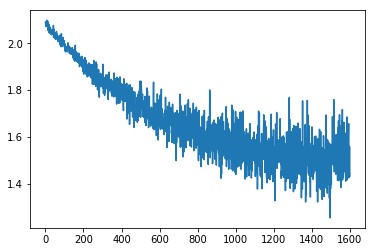

1000 12.5% (0.0m 23.788732528686523s) 1.86 / Physics X Computer Science
2000 25.0% (0.0m 47.710771799087524s) 1.725 / Physics V
3000 37.5% (1.0m 11.783061504364014s) 1.721 / Physics X Computer Science
4000 50.0% (1.0m 35.53752946853638s) 1.472 / Physics V
5000 62.5% (1.0m 59.077834367752075s) 1.438 / Physics X Computer Science
6000 75.0% (2.0m 22.767276763916016s) 1.386 / Physics X Mathematics
7000 87.5% (2.0m 46.372190952301025s) 1.587 / Physics X Computer Science
8000 100.0% (3.0m 10.35542917251587s) 1.268 / Physics V
learning rate and characters used: 0.0001 100


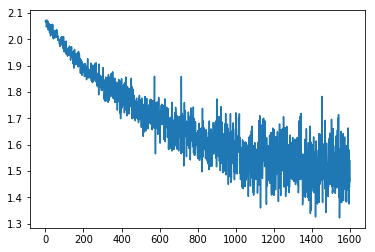

1000 12.5% (0.0m 34.28247094154358s) 1.904 / Mathematics X Physics
2000 25.0% (1.0m 8.963751077651978s) 1.763 / Physics X Mathematics
3000 37.5% (1.0m 43.32454991340637s) 1.559 / Physics X Mathematics
4000 50.0% (2.0m 17.597256898880005s) 1.699 / Physics X Computer Science
5000 62.5% (2.0m 52.0833797454834s) 1.792 / Physics X Computer Science
6000 75.0% (3.0m 26.44588327407837s) 1.52 / Physics V
7000 87.5% (4.0m 1.0299577713012695s) 1.279 / Physics X Computer Science
8000 100.0% (4.0m 35.563380002975464s) 1.364 / Physics X Quantitative Biology
learning rate and characters used: 0.0001 150


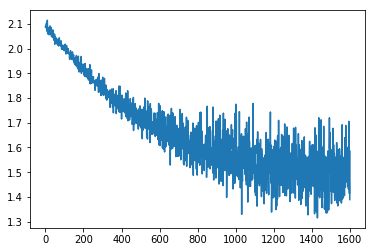

1000 12.5% (0.0m 44.99758839607239s) 1.902 / Physics X Mathematics
2000 25.0% (1.0m 29.97223973274231s) 1.702 / Physics V
3000 37.5% (2.0m 14.72684383392334s) 1.8 / Physics V
4000 50.0% (2.0m 59.74181652069092s) 1.44 / Physics V
5000 62.5% (3.0m 44.722100496292114s) 1.367 / Physics V
6000 75.0% (4.0m 29.766916036605835s) 1.614 / Physics V
7000 87.5% (5.0m 15.175164699554443s) 1.462 / Physics X Computer Science
8000 100.0% (6.0m 0.1831662654876709s) 1.384 / Physics X Quantitative Biology
learning rate and characters used: 0.0001 200


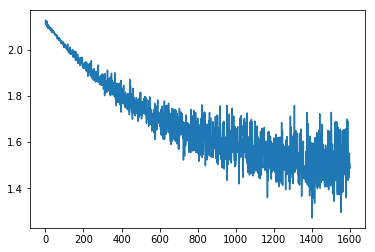

1000 12.5% (0.0m 55.88667392730713s) 1.908 / Physics X Computer Science
2000 25.0% (1.0m 51.824004888534546s) 1.674 / Physics V
3000 37.5% (2.0m 47.45016837120056s) 1.692 / Physics V
4000 50.0% (3.0m 43.44594955444336s) 1.398 / Physics X Computer Science
5000 62.5% (4.0m 39.692116022109985s) 1.539 / Physics X Quantitative Finance
6000 75.0% (5.0m 35.76118040084839s) 1.63 / Physics X Computer Science
7000 87.5% (6.0m 31.93968176841736s) 1.351 / Physics V
8000 100.0% (7.0m 28.137226819992065s) 1.546 / Physics X Computer Science
learning rate and characters used: 0.0001 250


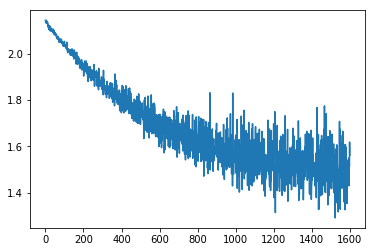

1000 12.5% (1.0m 7.399461984634399s) 1.947 / Physics X Computer Science
2000 25.0% (2.0m 15.133790016174316s) 1.692 / Physics X Mathematics
3000 37.5% (3.0m 22.541590690612793s) 1.835 / Physics X Mathematics
4000 50.0% (4.0m 30.0663058757782s) 1.503 / Physics X Computer Science
5000 62.5% (5.0m 37.88774228096008s) 1.542 / Physics X Mathematics
6000 75.0% (6.0m 45.49494385719299s) 1.677 / Physics X Mathematics
7000 87.5% (7.0m 53.16464924812317s) 1.652 / Physics V
8000 100.0% (9.0m 0.9253380298614502s) 1.488 / Physics V
learning rate and characters used: 0.0001 300


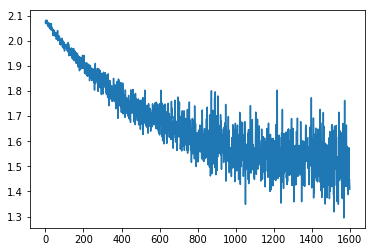

1000 12.5% (1.0m 16.823881149291992s) 1.956 / Physics X Mathematics
2000 25.0% (2.0m 33.437058448791504s) 1.766 / Physics V
3000 37.5% (3.0m 50.118470668792725s) 1.824 / Physics X Mathematics
4000 50.0% (5.0m 6.851890802383423s) 1.692 / Physics X Computer Science
5000 62.5% (6.0m 23.50476908683777s) 1.455 / Physics X Computer Science
6000 75.0% (7.0m 40.435622453689575s) 1.572 / Physics X Computer Science
7000 87.5% (8.0m 57.28799796104431s) 1.274 / Physics V
8000 100.0% (10.0m 14.008728742599487s) 1.481 / Physics X Mathematics
learning rate and characters used: 0.0001 350


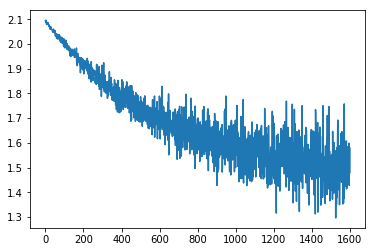

1000 12.5% (1.0m 27.390601634979248s) 1.899 / Physics X Mathematics
2000 25.0% (2.0m 55.10608196258545s) 1.629 / Physics X Mathematics
3000 37.5% (4.0m 22.075459718704224s) 1.74 / Physics V
4000 50.0% (5.0m 50.181477785110474s) 1.491 / Physics V
5000 62.5% (7.0m 18.794665336608887s) 1.525 / Physics X Computer Science
6000 75.0% (8.0m 48.38725233078003s) 1.437 / Physics V
7000 87.5% (10.0m 16.75681471824646s) 1.684 / Physics X Quantitative Biology
8000 100.0% (11.0m 44.62898588180542s) 1.681 / Physics V
learning rate and characters used: 0.0001 400


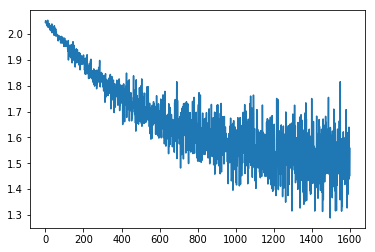

1000 12.5% (1.0m 43.103257179260254s) 1.925 / Physics V
2000 25.0% (3.0m 26.112563133239746s) 1.794 / Physics V
3000 37.5% (5.0m 9.208289861679077s) 1.648 / Physics X Mathematics
4000 50.0% (6.0m 52.58321261405945s) 1.674 / Physics X Mathematics
5000 62.5% (8.0m 36.190382957458496s) 1.704 / Physics X Mathematics
6000 75.0% (10.0m 19.436233520507812s) 1.719 / Physics X Statistics
7000 87.5% (12.0m 3.132748603820801s) 1.314 / Physics X Mathematics
8000 100.0% (13.0m 46.65721893310547s) 1.315 / Physics X Computer Science
learning rate and characters used: 0.0001 450


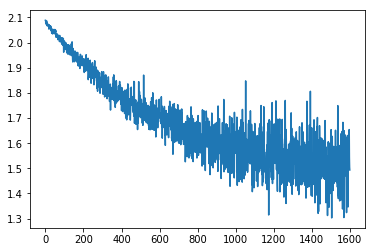

1000 12.5% (1.0m 55.994540214538574s) 1.944 / Physics X Computer Science
2000 25.0% (3.0m 52.36831593513489s) 1.674 / Physics X Statistics
3000 37.5% (5.0m 48.3702757358551s) 1.744 / Physics X Computer Science
4000 50.0% (7.0m 44.88305139541626s) 1.676 / Physics V
5000 62.5% (9.0m 41.391419649124146s) 1.502 / Physics X Computer Science
6000 75.0% (11.0m 38.421266317367554s) 1.724 / Physics X Computer Science
7000 87.5% (13.0m 35.33922815322876s) 1.43 / Physics V
8000 100.0% (15.0m 32.1552836894989s) 1.641 / Physics X Computer Science
learning rate and characters used: 0.0001 500


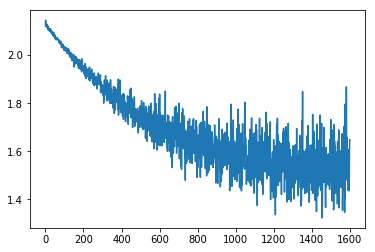

1000 12.5% (2.0m 4.091172218322754s) 1.858 / Physics X Computer Science
2000 25.0% (4.0m 8.684391260147095s) 1.827 / Physics X Quantitative Biology
3000 37.5% (6.0m 12.8240647315979s) 1.763 / Physics X Statistics
4000 50.0% (8.0m 17.396164655685425s) 1.569 / Physics X Statistics
5000 62.5% (10.0m 22.500864505767822s) 1.338 / Physics X Computer Science
6000 75.0% (12.0m 27.64023470878601s) 1.766 / Physics V
7000 87.5% (14.0m 32.915096282958984s) 1.288 / Physics X Mathematics
8000 100.0% (16.0m 37.8727867603302s) 1.513 / Physics X Computer Science
learning rate and characters used: 0.0001 550


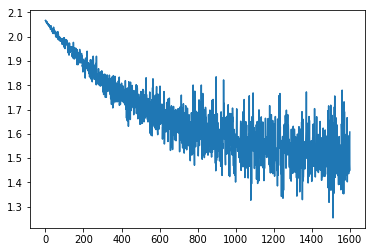

1000 12.5% (2.0m 16.180822610855103s) 1.802 / Physics V
2000 25.0% (4.0m 33.59944415092468s) 1.944 / Physics X Quantitative Biology
3000 37.5% (6.0m 49.80021524429321s) 1.453 / Physics X Computer Science
4000 50.0% (9.0m 6.033725738525391s) 1.792 / Physics X Mathematics
5000 62.5% (11.0m 22.688928365707397s) 1.361 / Physics V
6000 75.0% (13.0m 39.05425715446472s) 1.515 / Physics X Computer Science
7000 87.5% (15.0m 55.319085359573364s) 1.482 / Physics X Computer Science
8000 100.0% (18.0m 12.472151756286621s) 1.118 / Physics X Computer Science
learning rate and characters used: 0.0001 600


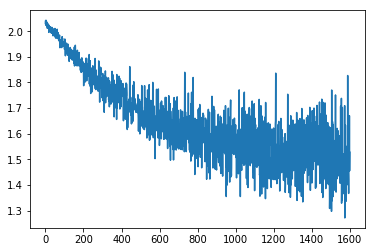

1000 12.5% (2.0m 31.384281873703003s) 1.945 / Physics X Quantitative Finance
2000 25.0% (5.0m 3.6820292472839355s) 1.766 / Physics X Mathematics
3000 37.5% (7.0m 34.47513270378113s) 1.814 / Physics V
4000 50.0% (10.0m 6.869186162948608s) 1.835 / Physics V
5000 62.5% (12.0m 38.434757232666016s) 1.661 / Physics V
6000 75.0% (15.0m 10.527101993560791s) 1.307 / Physics X Computer Science
7000 87.5% (17.0m 41.712849617004395s) 1.655 / Physics X Computer Science
8000 100.0% (20.0m 13.478054523468018s) 1.702 / Physics X Computer Science
learning rate and characters used: 0.0001 650


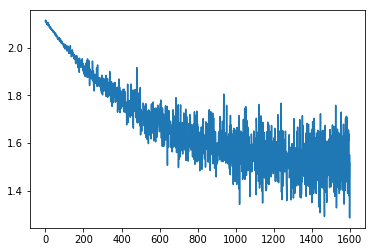

1000 12.5% (0.0m 12.854251146316528s) 1.558 / Physics V
2000 25.0% (0.0m 25.776789665222168s) 1.342 / Physics V
3000 37.5% (0.0m 38.75335144996643s) 1.342 / Physics V
4000 50.0% (0.0m 51.726534843444824s) 1.633 / Physics X Quantitative Finance
5000 62.5% (1.0m 4.803234815597534s) 1.532 / Physics V
6000 75.0% (1.0m 17.77427339553833s) 1.437 / Physics V
7000 87.5% (1.0m 30.759923458099365s) 1.434 / Physics X Statistics
8000 100.0% (1.0m 43.73114371299744s) 2.074 / Physics V
learning rate and characters used: 0.0005 50


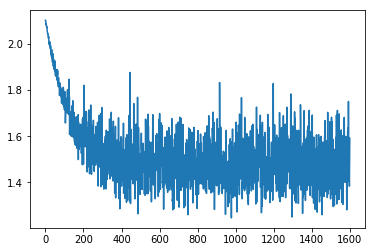

1000 12.5% (0.0m 23.478410243988037s) 1.442 / Physics X Mathematics
2000 25.0% (0.0m 47.220500230789185s) 1.468 / Physics X Mathematics
3000 37.5% (1.0m 10.887423992156982s) 1.463 / Physics X Computer Science
4000 50.0% (1.0m 34.48094129562378s) 1.41 / Physics X Mathematics
5000 62.5% (1.0m 58.21991968154907s) 1.322 / Physics X Mathematics
6000 75.0% (2.0m 22.02963399887085s) 1.396 / Physics X Mathematics
7000 87.5% (2.0m 45.65371870994568s) 1.522 / Physics X Mathematics
8000 100.0% (3.0m 9.26835036277771s) 1.533 / Physics X Mathematics
learning rate and characters used: 0.0005 100


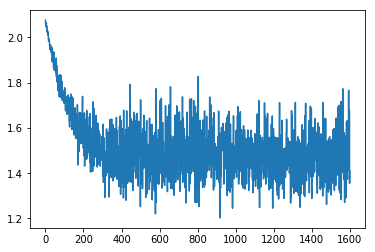

1000 12.5% (0.0m 34.54163479804993s) 1.838 / Physics X Quantitative Biology
2000 25.0% (1.0m 8.92955756187439s) 1.209 / Physics X Mathematics
3000 37.5% (1.0m 44.09275197982788s) 1.224 / Physics V
4000 50.0% (2.0m 18.726417541503906s) 1.672 / Physics X Statistics
5000 62.5% (2.0m 53.8594753742218s) 1.633 / Physics X Mathematics
6000 75.0% (3.0m 28.440951585769653s) 1.413 / Physics X Computer Science
7000 87.5% (4.0m 2.8854236602783203s) 1.284 / Physics V
8000 100.0% (4.0m 37.45790195465088s) 1.4 / Physics V
learning rate and characters used: 0.0005 150


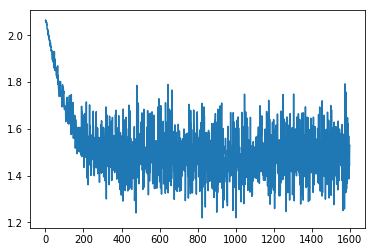

1000 12.5% (0.0m 45.30496025085449s) 1.412 / Physics V
2000 25.0% (1.0m 30.576247215270996s) 1.244 / Physics X Mathematics
3000 37.5% (2.0m 15.866470575332642s) 1.309 / Physics V
4000 50.0% (3.0m 0.9611954689025879s) 1.565 / Physics X Mathematics
5000 62.5% (3.0m 46.33535170555115s) 1.526 / Physics V
6000 75.0% (4.0m 31.475085020065308s) 1.407 / Physics X Mathematics
7000 87.5% (5.0m 16.779930114746094s) 1.353 / Physics X Computer Science
8000 100.0% (6.0m 2.0899298191070557s) 1.612 / Physics V
learning rate and characters used: 0.0005 200


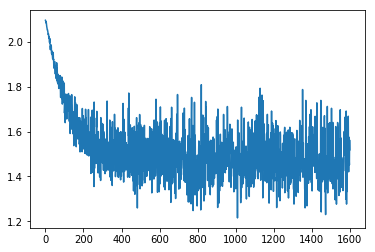

1000 12.5% (0.0m 56.03306174278259s) 1.633 / Physics V
2000 25.0% (1.0m 52.18701386451721s) 1.619 / Physics V
3000 37.5% (2.0m 48.226165533065796s) 1.324 / Physics V
4000 50.0% (3.0m 44.05836200714111s) 1.58 / Physics V
5000 62.5% (4.0m 39.87197780609131s) 1.556 / Physics X Mathematics
6000 75.0% (5.0m 36.099491357803345s) 1.48 / Physics X Computer Science
7000 87.5% (6.0m 31.866949319839478s) 1.513 / Physics V
8000 100.0% (7.0m 28.10948133468628s) 1.747 / Physics X Computer Science
learning rate and characters used: 0.0005 250


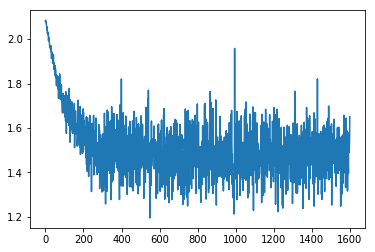

1000 12.5% (1.0m 7.791722059249878s) 1.887 / Physics X Electrical Engineering and Systems Science
2000 25.0% (2.0m 15.461778163909912s) 1.429 / Physics V
3000 37.5% (3.0m 23.408140182495117s) 1.618 / Physics V
4000 50.0% (4.0m 31.553683042526245s) 1.405 / Physics V
5000 62.5% (5.0m 39.60443162918091s) 1.329 / Physics V
6000 75.0% (6.0m 47.494107723236084s) 1.518 / Physics X Computer Science
7000 87.5% (7.0m 55.728689670562744s) 1.187 / Physics V
8000 100.0% (9.0m 3.5369551181793213s) 1.325 / Physics V
learning rate and characters used: 0.0005 300


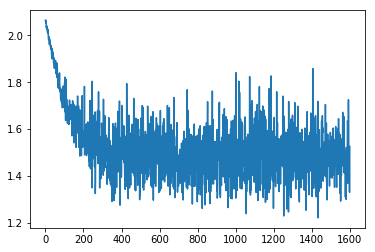

1000 12.5% (1.0m 16.861732006072998s) 1.786 / Physics X Computer Science
2000 25.0% (2.0m 33.47961497306824s) 1.31 / Physics V
3000 37.5% (3.0m 50.384424924850464s) 1.774 / Physics V
4000 50.0% (5.0m 8.042600154876709s) 1.725 / Physics V
5000 62.5% (6.0m 25.21024179458618s) 1.75 / Physics X Statistics
6000 75.0% (7.0m 42.061840295791626s) 1.279 / Physics X Quantitative Biology
7000 87.5% (8.0m 58.81926488876343s) 1.317 / Physics X Mathematics
8000 100.0% (10.0m 15.72788691520691s) 1.25 / Physics X Computer Science
learning rate and characters used: 0.0005 350


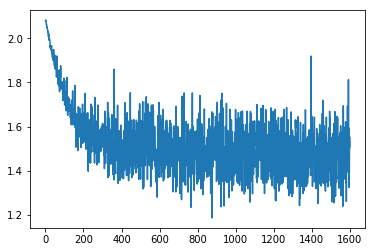

1000 12.5% (1.0m 27.90690016746521s) 1.599 / Physics X Mathematics
2000 25.0% (2.0m 55.01493239402771s) 1.611 / Physics X Electrical Engineering and Systems Science
3000 37.5% (4.0m 23.138035535812378s) 1.446 / Physics V
4000 50.0% (5.0m 50.70121932029724s) 1.456 / Physics X Computer Science
5000 62.5% (7.0m 18.013854265213013s) 1.239 / Physics X Mathematics
6000 75.0% (8.0m 45.63445425033569s) 1.766 / Physics X Quantitative Finance
7000 87.5% (10.0m 13.203584909439087s) 1.735 / Physics X Statistics
8000 100.0% (11.0m 42.061943769454956s) 2.216 / Physics X Mathematics
learning rate and characters used: 0.0005 400


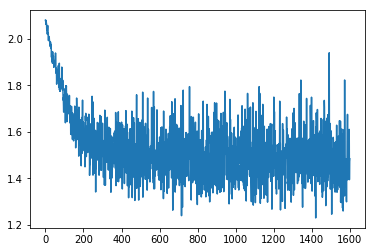

1000 12.5% (1.0m 43.27792191505432s) 1.836 / Physics X Quantitative Biology
2000 25.0% (3.0m 27.470815181732178s) 1.247 / Physics V
3000 37.5% (5.0m 11.460077047348022s) 1.331 / Physics X Mathematics
4000 50.0% (6.0m 55.109965324401855s) 1.776 / Physics X Computer Science
5000 62.5% (8.0m 39.363388776779175s) 1.316 / Physics V
6000 75.0% (10.0m 25.179519176483154s) 1.407 / Physics X Mathematics
7000 87.5% (12.0m 10.429354190826416s) 1.395 / Physics V
8000 100.0% (13.0m 56.17705464363098s) 1.539 / Physics V
learning rate and characters used: 0.0005 450


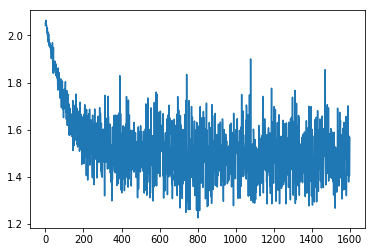

1000 12.5% (1.0m 57.570833683013916s) 1.566 / Physics V
2000 25.0% (3.0m 54.5236759185791s) 1.405 / Physics X Computer Science
3000 37.5% (5.0m 51.52239274978638s) 1.754 / Physics X Mathematics
4000 50.0% (7.0m 48.066282749176025s) 1.437 / Physics X Computer Science
5000 62.5% (9.0m 44.93402290344238s) 1.566 / Physics V
6000 75.0% (11.0m 42.11541175842285s) 1.274 / Physics V
7000 87.5% (13.0m 40.55728030204773s) 1.19 / Physics V
8000 100.0% (15.0m 38.498228311538696s) 1.643 / Physics X Computer Science
learning rate and characters used: 0.0005 500


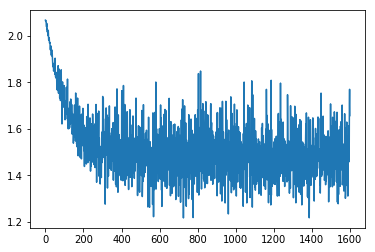

1000 12.5% (2.0m 6.208141803741455s) 1.823 / Physics X Computer Science
2000 25.0% (4.0m 13.09242296218872s) 1.415 / Physics X Statistics
3000 37.5% (6.0m 21.190031051635742s) 1.387 / Physics X Computer Science
4000 50.0% (8.0m 28.8405442237854s) 1.822 / Physics X Mathematics
5000 62.5% (10.0m 37.058759927749634s) 1.645 / Physics V
6000 75.0% (12.0m 45.215378761291504s) 1.375 / Physics X Computer Science
7000 87.5% (14.0m 52.476296186447144s) 1.441 / Physics V
8000 100.0% (16.0m 59.07444953918457s) 1.643 / Physics X Computer Science
learning rate and characters used: 0.0005 550


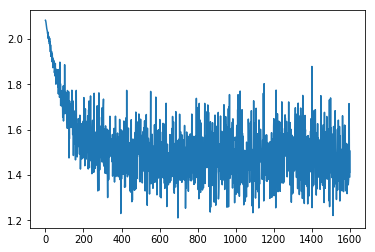

1000 12.5% (2.0m 18.17213463783264s) 1.549 / Physics V
2000 25.0% (4.0m 37.58078098297119s) 1.928 / Physics X Quantitative Biology
3000 37.5% (6.0m 55.772008657455444s) 1.583 / Physics X Computer Science
4000 50.0% (9.0m 14.514522552490234s) 1.285 / Physics X Computer Science
5000 62.5% (11.0m 32.4883189201355s) 1.597 / Physics X Statistics
6000 75.0% (13.0m 50.36863350868225s) 1.41 / Physics X Computer Science
7000 87.5% (16.0m 9.48914361000061s) 1.337 / Physics X Computer Science
8000 100.0% (18.0m 28.570915699005127s) 1.178 / Physics X Computer Science
learning rate and characters used: 0.0005 600


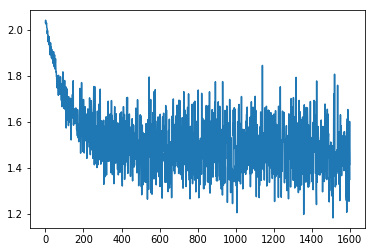

1000 12.5% (2.0m 32.22055220603943s) 1.557 / Physics V
2000 25.0% (5.0m 4.351780652999878s) 1.312 / Physics X Computer Science
3000 37.5% (7.0m 37.03824734687805s) 1.512 / Physics V
4000 50.0% (10.0m 8.661256551742554s) 1.302 / Physics V
5000 62.5% (12.0m 41.65179252624512s) 1.717 / Physics X Quantitative Finance
6000 75.0% (15.0m 13.40982723236084s) 1.454 / Physics V
7000 87.5% (17.0m 45.920713901519775s) 1.405 / Physics V
8000 100.0% (20.0m 17.866395235061646s) 1.454 / Physics V
learning rate and characters used: 0.0005 650


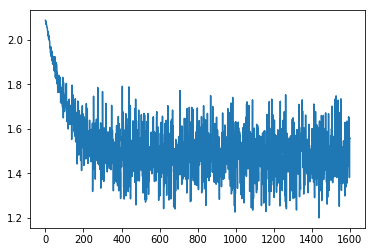

1000 12.5% (0.0m 13.093069791793823s) 1.68 / Physics X Quantitative Biology
2000 25.0% (0.0m 26.06913733482361s) 1.499 / Physics X Mathematics
3000 37.5% (0.0m 39.02308702468872s) 1.255 / Physics X Mathematics
4000 50.0% (0.0m 52.08478093147278s) 2.119 / Physics V
5000 62.5% (1.0m 5.104200124740601s) 1.095 / Physics X Computer Science
6000 75.0% (1.0m 18.14558696746826s) 1.379 / Physics X Mathematics
7000 87.5% (1.0m 31.07683229446411s) 1.713 / Physics V
8000 100.0% (1.0m 44.0169243812561s) 1.364 / Physics X Computer Science
learning rate and characters used: 0.005 50


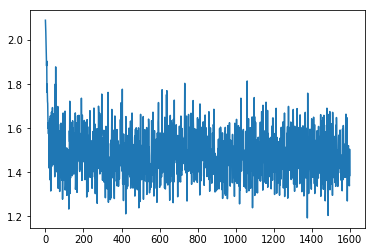

1000 12.5% (0.0m 23.618301391601562s) 1.612 / Physics X Mathematics
2000 25.0% (0.0m 47.37850499153137s) 1.665 / Physics X Mathematics
3000 37.5% (1.0m 10.98446011543274s) 1.519 / Physics X Quantitative Finance
4000 50.0% (1.0m 34.62070965766907s) 1.281 / Physics X Statistics
5000 62.5% (1.0m 58.261343240737915s) 1.596 / Physics X Quantitative Finance
6000 75.0% (2.0m 21.992905616760254s) 1.522 / Physics X Mathematics
7000 87.5% (2.0m 45.615772008895874s) 1.371 / Physics X Mathematics
8000 100.0% (3.0m 9.23954725265503s) 1.606 / Physics V
learning rate and characters used: 0.005 100


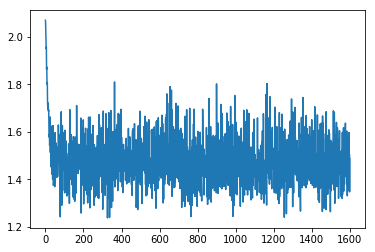

1000 12.5% (0.0m 34.852033376693726s) 1.526 / Physics X Computer Science
2000 25.0% (1.0m 9.384037256240845s) 1.832 / Physics X Computer Science
3000 37.5% (1.0m 44.0441472530365s) 1.553 / Physics V
4000 50.0% (2.0m 18.48961329460144s) 2.053 / Physics X Mathematics
5000 62.5% (2.0m 52.90969371795654s) 1.893 / Physics X Statistics
6000 75.0% (3.0m 27.392489910125732s) 1.216 / Physics X Computer Science
7000 87.5% (4.0m 1.7365028858184814s) 1.415 / Physics X Computer Science
8000 100.0% (4.0m 36.236703634262085s) 1.443 / Physics X Mathematics
learning rate and characters used: 0.005 150


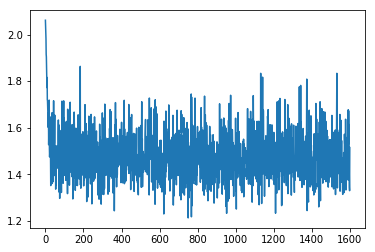

1000 12.5% (0.0m 45.0129816532135s) 1.436 / Physics X Mathematics
2000 25.0% (1.0m 30.51846671104431s) 1.394 / Physics X Mathematics
3000 37.5% (2.0m 15.643827438354492s) 1.311 / Physics X Computer Science
4000 50.0% (3.0m 0.8423745632171631s) 1.616 / Physics X Quantitative Biology
5000 62.5% (3.0m 46.044647216796875s) 1.199 / Physics V
6000 75.0% (4.0m 31.145453929901123s) 1.986 / Physics V
7000 87.5% (5.0m 16.361950874328613s) 1.502 / Physics V
8000 100.0% (6.0m 1.5414693355560303s) 1.519 / Physics X Mathematics
learning rate and characters used: 0.005 200


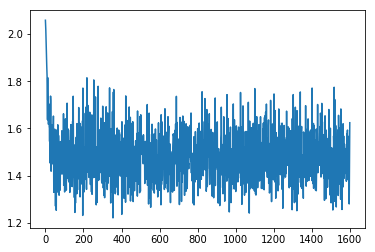

1000 12.5% (0.0m 56.42413258552551s) 1.328 / Physics X Quantitative Biology
2000 25.0% (1.0m 52.6388475894928s) 1.611 / Physics V
3000 37.5% (2.0m 48.56968545913696s) 1.778 / Physics X Computer Science
4000 50.0% (3.0m 44.68558692932129s) 1.198 / Physics V
5000 62.5% (4.0m 40.92896842956543s) 1.362 / Physics X Mathematics
6000 75.0% (5.0m 37.131622076034546s) 1.541 / Physics V
7000 87.5% (6.0m 33.23440337181091s) 1.129 / Physics X Computer Science
8000 100.0% (7.0m 29.44889736175537s) 1.365 / Physics X Computer Science
learning rate and characters used: 0.005 250


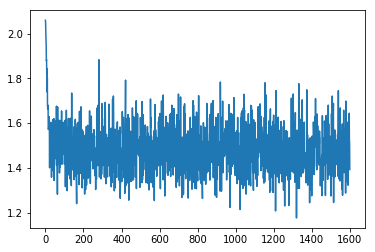

1000 12.5% (1.0m 7.844902038574219s) 1.745 / Physics X Mathematics
2000 25.0% (2.0m 15.86971664428711s) 1.561 / Physics X Mathematics
3000 37.5% (3.0m 24.037938833236694s) 1.342 / Physics V
4000 50.0% (4.0m 31.986608028411865s) 1.657 / Physics V
5000 62.5% (5.0m 39.903724670410156s) 1.431 / Physics X Mathematics
6000 75.0% (6.0m 47.81039094924927s) 1.574 / Physics X Computer Science
7000 87.5% (7.0m 55.69698238372803s) 1.581 / Physics X Computer Science
8000 100.0% (9.0m 3.8025901317596436s) 1.468 / Physics X Mathematics
learning rate and characters used: 0.005 300


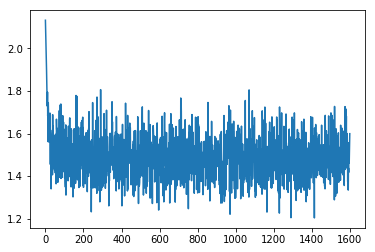

1000 12.5% (1.0m 16.984025955200195s) 1.265 / Physics V
2000 25.0% (2.0m 33.8839852809906s) 1.444 / Physics V
3000 37.5% (3.0m 51.02703619003296s) 1.605 / Physics V
4000 50.0% (5.0m 8.102495431900024s) 1.404 / Physics X Computer Science
5000 62.5% (6.0m 24.995121717453003s) 1.288 / Physics V
6000 75.0% (7.0m 41.60973000526428s) 1.536 / Physics X Computer Science
7000 87.5% (8.0m 58.513097286224365s) 1.592 / Physics X Mathematics
8000 100.0% (10.0m 15.481304168701172s) 1.502 / Physics X Statistics
learning rate and characters used: 0.005 350


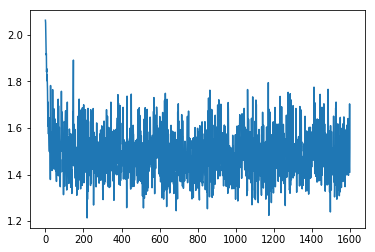

1000 12.5% (1.0m 27.600021600723267s) 1.543 / Physics X Mathematics
2000 25.0% (2.0m 55.3169960975647s) 1.478 / Physics X Mathematics
3000 37.5% (4.0m 23.336669921875s) 1.779 / Physics V
4000 50.0% (5.0m 51.433696269989014s) 1.672 / Physics X Mathematics
5000 62.5% (7.0m 19.440134048461914s) 1.226 / Physics X Computer Science
6000 75.0% (8.0m 46.76837754249573s) 1.376 / Physics X Computer Science
7000 87.5% (10.0m 14.870835542678833s) 1.084 / Physics V
8000 100.0% (11.0m 42.20048928260803s) 1.564 / Physics X Computer Science
learning rate and characters used: 0.005 400


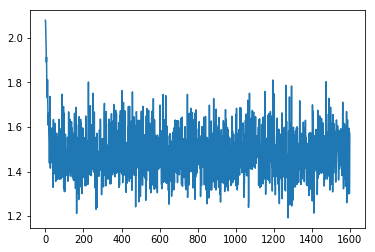

1000 12.5% (1.0m 43.6756546497345s) 1.476 / Physics V
2000 25.0% (3.0m 28.03886079788208s) 1.658 / Physics X Mathematics
3000 37.5% (5.0m 12.015247344970703s) 1.779 / Physics X Statistics
4000 50.0% (6.0m 55.66330313682556s) 1.76 / Physics V
5000 62.5% (8.0m 39.77480101585388s) 1.278 / Physics X Computer Science
6000 75.0% (10.0m 23.4293954372406s) 1.699 / Physics X Electrical Engineering and Systems Science
7000 87.5% (12.0m 6.884449481964111s) 1.777 / Physics X Statistics
8000 100.0% (13.0m 50.86690282821655s) 1.369 / Physics X Mathematics
learning rate and characters used: 0.005 450


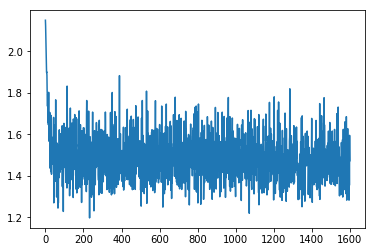

1000 12.5% (1.0m 56.26688742637634s) 1.642 / Physics X Mathematics
2000 25.0% (3.0m 52.090378284454346s) 1.449 / Physics V
3000 37.5% (5.0m 48.667351961135864s) 1.366 / Physics V
4000 50.0% (7.0m 44.97945594787598s) 1.321 / Physics V
5000 62.5% (9.0m 40.72476267814636s) 1.496 / Physics X Mathematics
6000 75.0% (11.0m 36.541136026382446s) 1.686 / Physics X Quantitative Finance
7000 87.5% (13.0m 32.597357988357544s) 1.351 / Physics X Computer Science
8000 100.0% (15.0m 28.501442193984985s) 1.632 / Physics X Mathematics
learning rate and characters used: 0.005 500


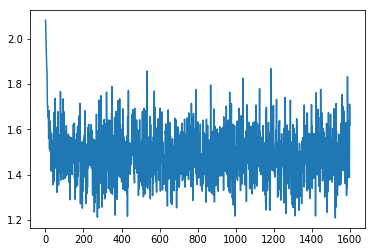

1000 12.5% (2.0m 4.397063255310059s) 1.444 / Physics V
2000 25.0% (4.0m 9.963482856750488s) 1.594 / Physics X Statistics
3000 37.5% (6.0m 15.014285802841187s) 1.172 / Physics V
4000 50.0% (8.0m 20.32032585144043s) 2.167 / Physics X Electrical Engineering and Systems Science
5000 62.5% (10.0m 26.3738055229187s) 1.378 / Physics V
6000 75.0% (12.0m 31.74574899673462s) 1.502 / Physics V
7000 87.5% (14.0m 37.56212091445923s) 1.754 / Physics X Computer Science
8000 100.0% (16.0m 43.97182750701904s) 1.417 / Physics X Computer Science
learning rate and characters used: 0.005 550


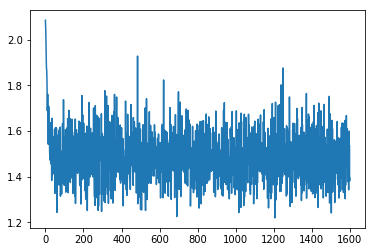

1000 12.5% (2.0m 17.203192949295044s) 1.322 / Physics V
2000 25.0% (4.0m 35.58112120628357s) 1.273 / Physics X Computer Science
3000 37.5% (6.0m 53.2905158996582s) 1.102 / Physics X Computer Science
4000 50.0% (9.0m 11.184111833572388s) 1.556 / Physics X Mathematics
5000 62.5% (11.0m 29.14308738708496s) 1.378 / Physics X Computer Science
6000 75.0% (13.0m 46.50468945503235s) 1.704 / Physics V
7000 87.5% (16.0m 3.9468801021575928s) 1.236 / Physics X Mathematics
8000 100.0% (18.0m 21.51703405380249s) 1.679 / Physics V
learning rate and characters used: 0.005 600


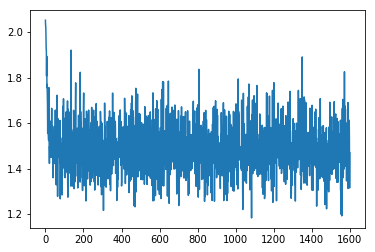

1000 12.5% (2.0m 32.23319697380066s) 1.264 / Physics V
2000 25.0% (5.0m 3.7274584770202637s) 1.445 / Physics X Mathematics
3000 37.5% (7.0m 35.03732085227966s) 1.178 / Physics X Computer Science
4000 50.0% (10.0m 6.734400272369385s) 1.384 / Physics V
5000 62.5% (12.0m 38.855865478515625s) 1.51 / Physics X Computer Science
6000 75.0% (15.0m 10.731191635131836s) 1.356 / Physics X Computer Science
7000 87.5% (17.0m 42.366212368011475s) 1.816 / Physics X Mathematics
8000 100.0% (20.0m 14.070836544036865s) 1.665 / Physics X Computer Science
learning rate and characters used: 0.005 650


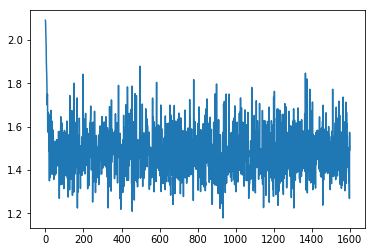

1000 12.5% (0.0m 12.931258916854858s) 1.426 / Physics X Computer Science
2000 25.0% (0.0m 25.856046438217163s) 1.542 / Physics X Statistics
3000 37.5% (0.0m 38.92167901992798s) 1.67 / Physics V
4000 50.0% (0.0m 51.84483242034912s) 1.631 / Physics X Mathematics
5000 62.5% (1.0m 4.7022576332092285s) 1.456 / Physics X Mathematics
6000 75.0% (1.0m 17.843079328536987s) 1.439 / Physics X Mathematics
7000 87.5% (1.0m 30.726215362548828s) 1.482 / Physics V
8000 100.0% (1.0m 43.62407112121582s) 1.56 / Physics V
learning rate and characters used: 0.01 50


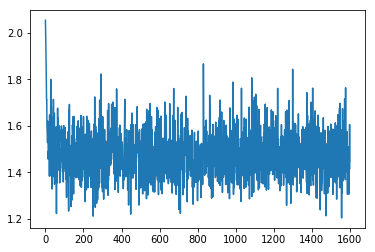

1000 12.5% (0.0m 23.83291006088257s) 1.908 / Physics X Computer Science
2000 25.0% (0.0m 47.48300504684448s) 1.397 / Physics V
3000 37.5% (1.0m 11.090134859085083s) 1.547 / Physics X Mathematics
4000 50.0% (1.0m 34.79694581031799s) 1.748 / Physics V
5000 62.5% (1.0m 58.39907383918762s) 1.375 / Physics V
6000 75.0% (2.0m 21.924648761749268s) 1.544 / Physics V
7000 87.5% (2.0m 45.47435927391052s) 1.569 / Physics X Computer Science
8000 100.0% (3.0m 9.219234943389893s) 1.829 / Physics V
learning rate and characters used: 0.01 100


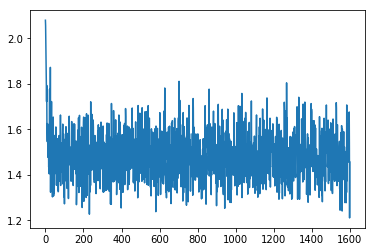

1000 12.5% (0.0m 34.525792837142944s) 1.41 / Physics X Computer Science
2000 25.0% (1.0m 9.401062488555908s) 1.428 / Physics V
3000 37.5% (1.0m 44.11827754974365s) 1.48 / Physics V
4000 50.0% (2.0m 18.46708035469055s) 1.577 / Physics V
5000 62.5% (2.0m 52.91926050186157s) 1.703 / Physics X Mathematics
6000 75.0% (3.0m 27.20767641067505s) 1.596 / Physics V
7000 87.5% (4.0m 1.9264428615570068s) 1.431 / Physics X Computer Science
8000 100.0% (4.0m 36.31199884414673s) 1.456 / Physics X Mathematics
learning rate and characters used: 0.01 150


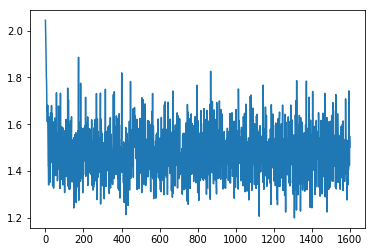

1000 12.5% (0.0m 45.50527572631836s) 1.242 / Physics X Mathematics
2000 25.0% (1.0m 30.62888216972351s) 1.673 / Physics V
3000 37.5% (2.0m 16.294243574142456s) 1.889 / Physics X Mathematics
4000 50.0% (3.0m 1.3251235485076904s) 1.286 / Physics X Computer Science
5000 62.5% (3.0m 46.488858699798584s) 1.458 / Physics X Mathematics
6000 75.0% (4.0m 31.486866235733032s) 1.717 / Physics X Computer Science
7000 87.5% (5.0m 16.50407361984253s) 1.59 / Physics V
8000 100.0% (6.0m 1.8082749843597412s) 1.435 / Physics X Computer Science
learning rate and characters used: 0.01 200


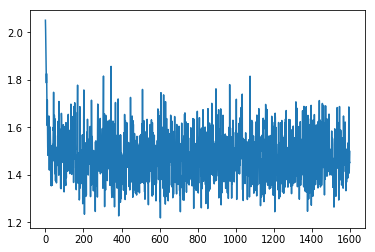

1000 12.5% (0.0m 56.02724003791809s) 1.542 / Physics V
2000 25.0% (1.0m 52.34634280204773s) 1.86 / Physics V
3000 37.5% (2.0m 48.470826625823975s) 1.214 / Physics X Computer Science
4000 50.0% (3.0m 44.36623287200928s) 1.251 / Physics X Computer Science
5000 62.5% (4.0m 40.67214918136597s) 1.128 / Physics X Computer Science
6000 75.0% (5.0m 36.73944115638733s) 1.405 / Physics V
7000 87.5% (6.0m 32.97231602668762s) 1.988 / Physics X Computer Science
8000 100.0% (7.0m 29.102511405944824s) 1.613 / Physics X Mathematics
learning rate and characters used: 0.01 250


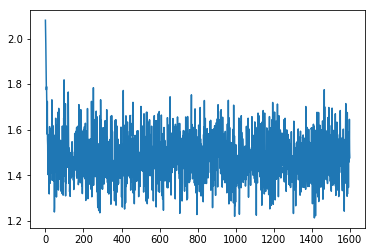

1000 12.5% (1.0m 7.901335954666138s) 1.883 / Physics X Electrical Engineering and Systems Science
2000 25.0% (2.0m 16.34997320175171s) 1.442 / Physics V
3000 37.5% (3.0m 24.295266151428223s) 1.692 / Physics V
4000 50.0% (4.0m 32.527101039886475s) 1.372 / Physics V
5000 62.5% (5.0m 40.358081579208374s) 1.697 / Physics X Quantitative Biology
6000 75.0% (6.0m 48.19870638847351s) 1.591 / Physics X Computer Science
7000 87.5% (7.0m 56.01992583274841s) 1.262 / Physics X Computer Science
8000 100.0% (9.0m 3.6976280212402344s) 1.711 / Physics X Quantitative Finance
learning rate and characters used: 0.01 300


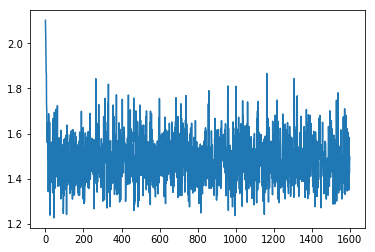

1000 12.5% (1.0m 17.772530555725098s) 1.7 / Physics X Quantitative Biology
2000 25.0% (2.0m 35.41925549507141s) 1.168 / Physics V
3000 37.5% (3.0m 52.927151679992676s) 1.498 / Physics V
4000 50.0% (5.0m 9.946774959564209s) 1.17 / Physics X Computer Science
5000 62.5% (6.0m 28.037686824798584s) 1.829 / Physics X Computer Science
6000 75.0% (7.0m 45.88726592063904s) 1.849 / Physics X Quantitative Finance
7000 87.5% (9.0m 3.386491298675537s) 1.291 / Physics X Mathematics
8000 100.0% (10.0m 20.811365604400635s) 1.363 / Physics V
learning rate and characters used: 0.01 350


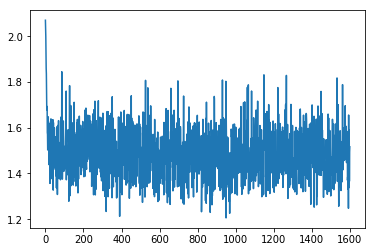

1000 12.5% (1.0m 28.28566575050354s) 1.723 / Physics X Statistics
2000 25.0% (2.0m 56.94884538650513s) 1.497 / Physics X Computer Science
3000 37.5% (4.0m 25.406471490859985s) 1.426 / Physics V
4000 50.0% (5.0m 54.37004089355469s) 1.659 / Physics V
5000 62.5% (7.0m 22.69726586341858s) 1.293 / Physics X Mathematics
6000 75.0% (8.0m 50.98926663398743s) 1.497 / Physics X Mathematics
7000 87.5% (10.0m 18.320250988006592s) 1.207 / Physics X Computer Science
8000 100.0% (11.0m 47.32319903373718s) 1.68 / Physics V
learning rate and characters used: 0.01 400


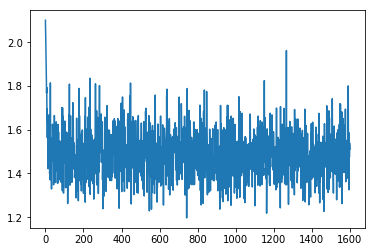

1000 12.5% (1.0m 44.898876428604126s) 1.187 / Physics V
2000 25.0% (3.0m 28.985104084014893s) 1.459 / Physics X Computer Science
3000 37.5% (5.0m 13.266580820083618s) 1.353 / Physics X Computer Science
4000 50.0% (6.0m 57.64049434661865s) 1.716 / Physics X Statistics
5000 62.5% (8.0m 41.31437826156616s) 1.914 / Physics X Quantitative Biology
6000 75.0% (10.0m 24.709115028381348s) 1.46 / Physics X Statistics
7000 87.5% (12.0m 8.108180522918701s) 1.43 / Physics X Computer Science
8000 100.0% (13.0m 51.80415964126587s) 1.154 / Physics V
learning rate and characters used: 0.01 450


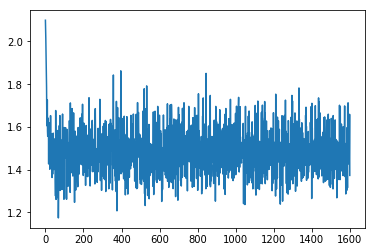

1000 12.5% (1.0m 57.73322939872742s) 1.489 / Physics X Computer Science
2000 25.0% (3.0m 55.08167862892151s) 1.49 / Physics X Mathematics
3000 37.5% (5.0m 52.060481548309326s) 1.545 / Physics X Computer Science
4000 50.0% (7.0m 49.73248052597046s) 1.509 / Physics X Mathematics
5000 62.5% (9.0m 46.729897022247314s) 1.662 / Physics X Statistics
6000 75.0% (11.0m 44.03996443748474s) 1.473 / Physics X Computer Science
7000 87.5% (13.0m 41.09382605552673s) 1.544 / Physics X Computer Science
8000 100.0% (15.0m 37.718024253845215s) 1.164 / Physics X Computer Science
learning rate and characters used: 0.01 500


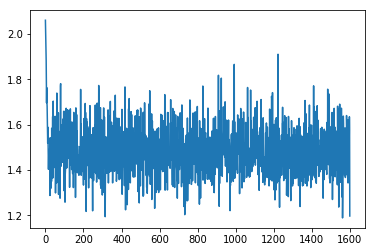

1000 12.5% (2.0m 5.5727903842926025s) 1.116 / Physics V
2000 25.0% (4.0m 10.970988512039185s) 1.445 / Physics X Computer Science
3000 37.5% (6.0m 16.550856828689575s) 1.508 / Physics X Computer Science
4000 50.0% (8.0m 21.33139967918396s) 1.733 / Physics X Quantitative Biology
5000 62.5% (10.0m 25.995169162750244s) 1.244 / Physics V
6000 75.0% (12.0m 31.705270051956177s) 1.57 / Physics V
7000 87.5% (14.0m 37.18753981590271s) 1.977 / Physics X Computer Science
8000 100.0% (16.0m 42.77623915672302s) 1.576 / Physics X Mathematics
learning rate and characters used: 0.01 550


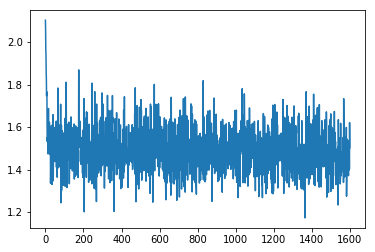

1000 12.5% (2.0m 17.956593990325928s) 1.2 / Physics V
2000 25.0% (4.0m 34.73700451850891s) 1.61 / Physics X Mathematics
3000 37.5% (6.0m 52.260433197021484s) 1.777 / Physics X Computer Science
4000 50.0% (9.0m 9.54590129852295s) 1.407 / Physics X Mathematics
5000 62.5% (11.0m 26.88620138168335s) 1.208 / Physics V
6000 75.0% (13.0m 44.637582778930664s) 1.286 / Physics X Mathematics
7000 87.5% (16.0m 4.281475067138672s) 1.605 / Physics X Quantitative Biology
8000 100.0% (18.0m 21.36092495918274s) 1.796 / Physics X Mathematics
learning rate and characters used: 0.01 600


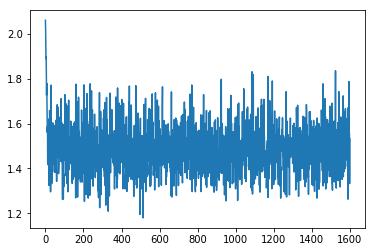

1000 12.5% (2.0m 31.80457043647766s) 1.558 / Physics X Mathematics
2000 25.0% (5.0m 5.018583536148071s) 1.511 / Physics V
3000 37.5% (7.0m 35.70066452026367s) 1.706 / Physics X Mathematics
4000 50.0% (10.0m 7.008621692657471s) 1.516 / Physics V
5000 62.5% (12.0m 39.027857065200806s) 1.317 / Physics V
6000 75.0% (15.0m 12.485814571380615s) 1.256 / Physics X Computer Science
7000 87.5% (17.0m 44.72573137283325s) 1.534 / Physics V
8000 100.0% (20.0m 17.24824070930481s) 1.197 / Physics V
learning rate and characters used: 0.01 650


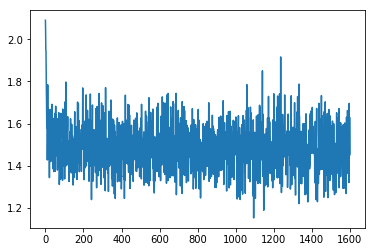

1000 12.5% (0.0m 12.852905511856079s) 1.279 / Mathematics V
2000 25.0% (0.0m 25.708741664886475s) 1.627 / Physics X Mathematics
3000 37.5% (0.0m 38.56870150566101s) 1.409 / Physics V
4000 50.0% (0.0m 51.434805154800415s) 1.815 / Physics X Mathematics
5000 62.5% (1.0m 4.379841566085815s) 1.643 / Physics X Electrical Engineering and Systems Science
6000 75.0% (1.0m 17.329514265060425s) 1.71 / Physics X Quantitative Biology
7000 87.5% (1.0m 30.178616046905518s) 1.739 / Computer Science X Quantitative Finance
8000 100.0% (1.0m 43.00943350791931s) 1.469 / Physics V
learning rate and characters used: 0.05 50


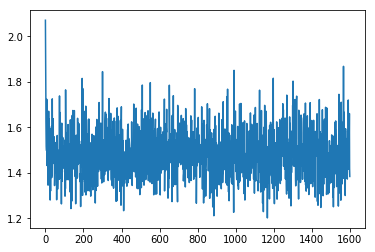

1000 12.5% (0.0m 23.794710397720337s) 1.526 / Physics X Quantitative Finance
2000 25.0% (0.0m 47.58275556564331s) 1.154 / Physics X Mathematics
3000 37.5% (1.0m 11.30755877494812s) 1.988 / Mathematics X Physics
4000 50.0% (1.0m 35.02790880203247s) 1.452 / Physics X Electrical Engineering and Systems Science
5000 62.5% (1.0m 58.6533317565918s) 1.373 / Physics V
6000 75.0% (2.0m 22.41459012031555s) 1.234 / Physics X Mathematics
7000 87.5% (2.0m 46.05583596229553s) 1.308 / Mathematics X Physics
8000 100.0% (3.0m 9.709203958511353s) 1.406 / Physics X Mathematics
learning rate and characters used: 0.05 100


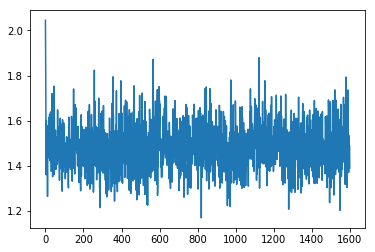

1000 12.5% (0.0m 34.50750732421875s) 1.38 / Mathematics V
2000 25.0% (1.0m 8.822232246398926s) 1.365 / Physics V
3000 37.5% (1.0m 43.25521183013916s) 1.57 / Physics V
4000 50.0% (2.0m 17.784847259521484s) 1.926 / Physics X Quantitative Biology
5000 62.5% (2.0m 52.08297324180603s) 1.477 / Physics V
6000 75.0% (3.0m 26.511003494262695s) 1.423 / Physics X Mathematics
7000 87.5% (4.0m 0.7737858295440674s) 1.432 / Physics X Mathematics
8000 100.0% (4.0m 35.83114528656006s) 1.057 / Physics X Computer Science
learning rate and characters used: 0.05 150


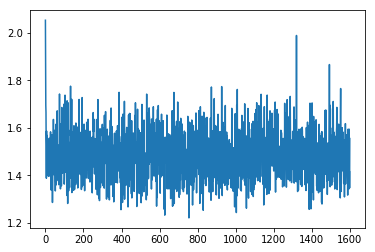

1000 12.5% (0.0m 45.89163827896118s) 1.479 / Physics V
2000 25.0% (1.0m 31.517667055130005s) 2.004 / Physics V
3000 37.5% (2.0m 17.726622104644775s) 1.633 / Physics X Mathematics
4000 50.0% (3.0m 3.3677408695220947s) 1.781 / Physics X Quantitative Biology
5000 62.5% (3.0m 48.88586711883545s) 1.253 / Physics V
6000 75.0% (4.0m 34.37945580482483s) 1.359 / Physics X Mathematics
7000 87.5% (5.0m 19.59565567970276s) 1.579 / Physics X Mathematics
8000 100.0% (6.0m 4.579921245574951s) 1.484 / Physics X Quantitative Biology
learning rate and characters used: 0.05 200


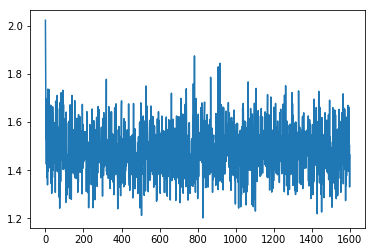

1000 12.5% (0.0m 56.26615262031555s) 1.257 / Computer Science V
2000 25.0% (1.0m 52.706361055374146s) 1.994 / Physics X Computer Science
3000 37.5% (2.0m 49.00589871406555s) 1.59 / Physics V
4000 50.0% (3.0m 44.858304262161255s) 1.723 / Mathematics V
5000 62.5% (4.0m 40.662590742111206s) 1.437 / Physics X Computer Science
6000 75.0% (5.0m 38.00729036331177s) 1.428 / Physics V
7000 87.5% (6.0m 34.5524365901947s) 1.746 / Physics X Quantitative Biology
8000 100.0% (7.0m 30.71858525276184s) 1.539 / Physics X Computer Science
learning rate and characters used: 0.05 250


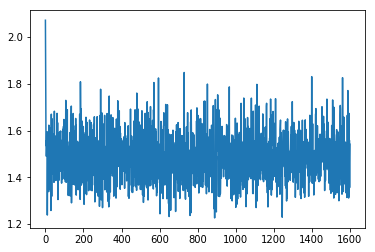

1000 12.5% (1.0m 7.673418760299683s) 1.503 / Physics X Statistics
2000 25.0% (2.0m 15.140312910079956s) 1.36 / Mathematics X Computer Science
3000 37.5% (3.0m 22.529865741729736s) 1.734 / Computer Science V
4000 50.0% (4.0m 29.833468675613403s) 1.622 / Computer Science X Mathematics
5000 62.5% (5.0m 38.55626821517944s) 1.211 / Physics X Computer Science
6000 75.0% (6.0m 46.06485843658447s) 1.385 / Physics X Mathematics
7000 87.5% (7.0m 54.35628151893616s) 1.252 / Physics X Mathematics
8000 100.0% (9.0m 1.7866160869598389s) 1.572 / Physics X Mathematics
learning rate and characters used: 0.05 300


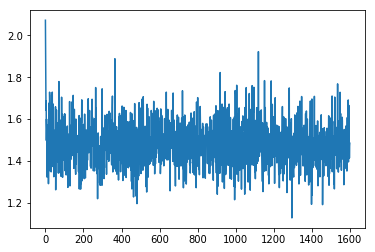

1000 12.5% (1.0m 17.502034425735474s) 1.224 / Physics V


In [0]:
#DO NOT RUN



#EXPERIMENT CHANGING INPUT SIZE AND LEARNING RATE, and weighted data


learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=50;               #this is the minimum abstract length we are testing our model on
max_length=700
print_every = 1000
plot_every = 5

for learning_rate in (0.0001, 0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in range (minimum, max_length, 50):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 12.5% (0.0m 16.73292088508606s) 1.948 / Physics X Mathematics
2000 25.0% (0.0m 33.26172947883606s) 1.843 / Physics X Statistics
3000 37.5% (0.0m 50.036301374435425s) 1.633 / Physics X Mathematics
4000 50.0% (1.0m 6.706040620803833s) 1.839 / Physics X Computer Science
5000 62.5% (1.0m 23.183680057525635s) 1.63 / Physics X Computer Science
6000 75.0% (1.0m 39.62342381477356s) 1.599 / Physics X Electrical Engineering and Systems Science
7000 87.5% (1.0m 56.19076657295227s) 1.51 / Physics X Mathematics
8000 100.0% (2.0m 12.841424465179443s) 1.847 / Physics X Mathematics
learning rate and characters used: 0.0001 50


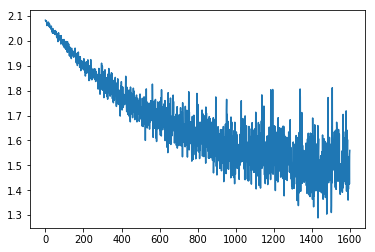

1000 12.5% (0.0m 28.512193202972412s) 1.916 / Physics V
2000 25.0% (0.0m 57.03578472137451s) 1.771 / Physics V
3000 37.5% (1.0m 25.377413034439087s) 1.699 / Physics X Quantitative Biology
4000 50.0% (1.0m 53.64233994483948s) 1.591 / Physics X Computer Science
5000 62.5% (2.0m 21.8858585357666s) 1.684 / Physics X Computer Science
6000 75.0% (2.0m 50.42535948753357s) 1.647 / Physics X Mathematics
7000 87.5% (3.0m 18.46951699256897s) 1.479 / Physics X Computer Science
8000 100.0% (3.0m 46.60278868675232s) 1.468 / Physics X Mathematics
learning rate and characters used: 0.0001 100


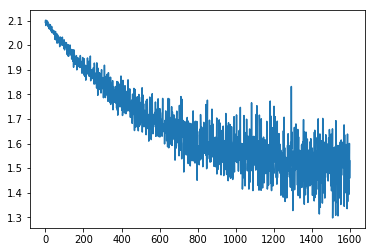

1000 12.5% (0.0m 39.80906796455383s) 1.928 / Physics V
2000 25.0% (1.0m 19.581937551498413s) 1.969 / Physics X Statistics
3000 37.5% (1.0m 59.051509380340576s) 1.576 / Physics V
4000 50.0% (2.0m 38.6345317363739s) 1.457 / Physics V
5000 62.5% (3.0m 18.26893949508667s) 1.441 / Physics V
6000 75.0% (3.0m 57.726585149765015s) 1.82 / Physics X Computer Science
7000 87.5% (4.0m 37.17575812339783s) 1.874 / Physics X Quantitative Biology
8000 100.0% (5.0m 16.44188642501831s) 1.475 / Physics X Quantitative Finance
learning rate and characters used: 0.0001 150


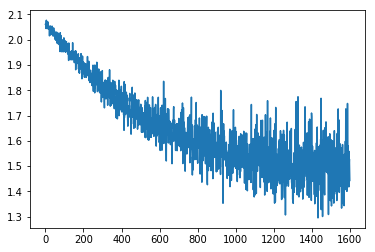

1000 12.5% (0.0m 51.10759782791138s) 1.878 / Physics X Mathematics
2000 25.0% (1.0m 42.13622546195984s) 1.716 / Physics V
3000 37.5% (2.0m 33.0046660900116s) 1.563 / Physics X Mathematics
4000 50.0% (3.0m 23.96772813796997s) 1.824 / Physics V
5000 62.5% (4.0m 15.086406707763672s) 1.349 / Physics X Mathematics
6000 75.0% (5.0m 5.805947780609131s) 1.151 / Physics X Mathematics
7000 87.5% (5.0m 56.558387756347656s) 1.831 / Physics V
8000 100.0% (6.0m 46.90666127204895s) 1.613 / Physics X Mathematics
learning rate and characters used: 0.0001 200


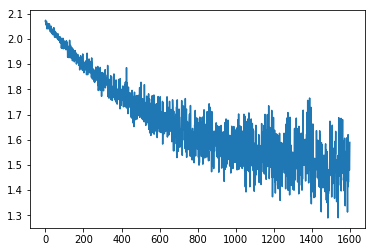

1000 12.5% (1.0m 2.5787155628204346s) 1.838 / Physics V
2000 25.0% (2.0m 4.90744423866272s) 1.835 / Physics X Computer Science
3000 37.5% (3.0m 7.158609867095947s) 1.589 / Physics X Computer Science
4000 50.0% (4.0m 9.103475093841553s) 1.347 / Physics V
5000 62.5% (5.0m 11.360044479370117s) 1.63 / Physics X Computer Science
6000 75.0% (6.0m 13.514191389083862s) 1.732 / Physics X Quantitative Biology
7000 87.5% (7.0m 15.630553245544434s) 1.702 / Physics X Computer Science
8000 100.0% (8.0m 17.552786827087402s) 1.298 / Physics V
learning rate and characters used: 0.0001 250


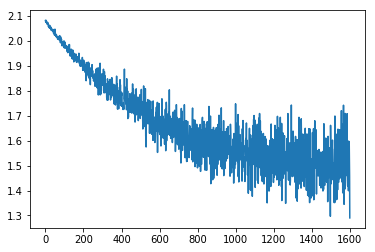

1000 12.5% (1.0m 13.828333377838135s) 1.901 / Physics X Mathematics
2000 25.0% (2.0m 27.62935495376587s) 1.955 / Physics X Quantitative Finance
3000 37.5% (3.0m 41.53846836090088s) 1.448 / Physics V
4000 50.0% (4.0m 55.41247344017029s) 1.656 / Physics X Quantitative Finance
5000 62.5% (6.0m 9.369341373443604s) 1.744 / Physics X Quantitative Biology
6000 75.0% (7.0m 27.71958303451538s) 1.531 / Physics X Statistics
7000 87.5% (8.0m 45.58663868904114s) 1.411 / Physics V
8000 100.0% (10.0m 3.2130465507507324s) 1.467 / Physics V
learning rate and characters used: 0.0001 300


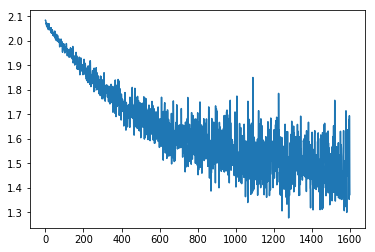

1000 12.5% (1.0m 30.229207515716553s) 1.892 / Physics X Computer Science
2000 25.0% (3.0m 0.5952246189117432s) 1.56 / Physics V
3000 37.5% (4.0m 30.76645302772522s) 1.793 / Physics V
4000 50.0% (6.0m 1.1186363697052002s) 1.435 / Physics X Computer Science
5000 62.5% (7.0m 30.364630699157715s) 1.347 / Physics X Computer Science
6000 75.0% (9.0m 0.009549140930175781s) 1.802 / Physics X Computer Science
7000 87.5% (10.0m 30.175586938858032s) 1.58 / Physics X Computer Science
8000 100.0% (12.0m 0.14560484886169434s) 1.365 / Physics V
learning rate and characters used: 0.0001 350


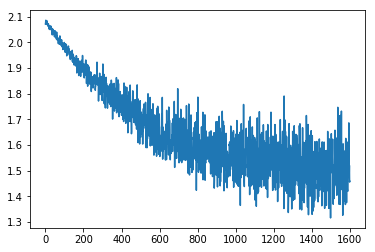

1000 12.5% (1.0m 43.79209518432617s) 1.938 / Physics X Statistics
2000 25.0% (3.0m 28.10405158996582s) 1.704 / Physics V
3000 37.5% (5.0m 12.133183002471924s) 1.808 / Physics V
4000 50.0% (6.0m 54.996800661087036s) 1.737 / Physics V
5000 62.5% (8.0m 37.278557538986206s) 1.41 / Physics X Mathematics
6000 75.0% (10.0m 18.91063094139099s) 1.657 / Physics V
7000 87.5% (12.0m 1.2916169166564941s) 1.524 / Physics X Computer Science
8000 100.0% (13.0m 44.56282091140747s) 1.44 / Physics X Computer Science
learning rate and characters used: 0.0001 400


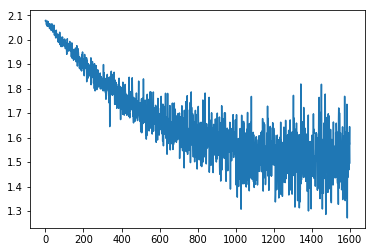

1000 12.5% (1.0m 57.79596710205078s) 1.937 / Physics V
2000 25.0% (3.0m 56.40493202209473s) 1.722 / Physics V
3000 37.5% (5.0m 52.7976279258728s) 1.718 / Physics X Computer Science
4000 50.0% (7.0m 49.991451025009155s) 1.497 / Physics X Computer Science
5000 62.5% (9.0m 47.492347240448s) 1.75 / Physics X Computer Science
6000 75.0% (11.0m 42.742305755615234s) 1.364 / Physics V
7000 87.5% (13.0m 38.324918270111084s) 1.509 / Physics X Mathematics
8000 100.0% (15.0m 34.72947096824646s) 1.624 / Physics V
learning rate and characters used: 0.0001 450


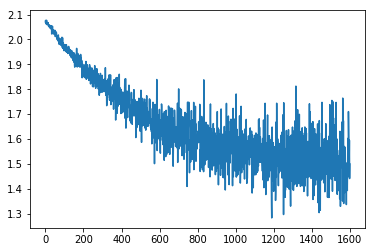

1000 12.5% (2.0m 8.794873237609863s) 1.939 / Physics V
2000 25.0% (4.0m 19.157323360443115s) 1.709 / Physics X Mathematics
3000 37.5% (6.0m 28.742907285690308s) 1.649 / Physics X Computer Science
4000 50.0% (8.0m 38.750327587127686s) 1.614 / Physics X Mathematics
5000 62.5% (10.0m 49.17809295654297s) 1.658 / Physics X Computer Science
6000 75.0% (12.0m 57.67764925956726s) 1.63 / Physics V
7000 87.5% (15.0m 7.357400894165039s) 1.532 / Physics V
8000 100.0% (17.0m 15.832856178283691s) 1.482 / Physics V
learning rate and characters used: 0.0001 500


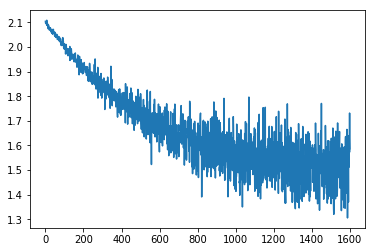

1000 12.5% (2.0m 23.96139621734619s) 1.889 / Physics X Mathematics
2000 25.0% (4.0m 48.25823640823364s) 1.826 / Physics V
3000 37.5% (7.0m 11.134841918945312s) 1.519 / Physics X Computer Science
4000 50.0% (9.0m 34.217050313949585s) 1.636 / Physics X Mathematics
5000 62.5% (11.0m 59.32605528831482s) 1.411 / Physics V
6000 75.0% (14.0m 27.019953727722168s) 1.919 / Physics X Quantitative Biology
7000 87.5% (16.0m 52.181729793548584s) 1.562 / Physics V
8000 100.0% (19.0m 15.666054248809814s) 1.286 / Physics V
learning rate and characters used: 0.0001 550


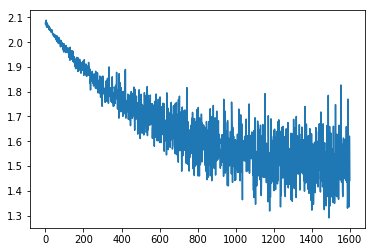

1000 12.5% (2.0m 38.92418622970581s) 1.912 / Physics V
2000 25.0% (5.0m 18.255397081375122s) 1.872 / Physics V
3000 37.5% (7.0m 58.27989745140076s) 1.665 / Physics V
4000 50.0% (10.0m 39.26546382904053s) 1.576 / Physics V
5000 62.5% (13.0m 19.470247507095337s) 1.606 / Physics X Mathematics
6000 75.0% (15.0m 59.60084843635559s) 1.548 / Physics X Computer Science
7000 87.5% (18.0m 41.29614734649658s) 1.992 / Physics X Electrical Engineering and Systems Science
8000 100.0% (21.0m 22.356686115264893s) 1.34 / Physics X Mathematics
learning rate and characters used: 0.0001 600


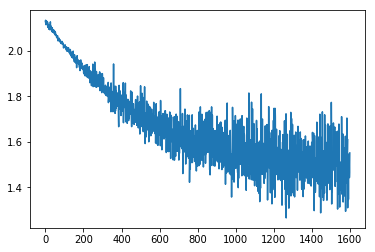

1000 12.5% (3.0m 0.30642056465148926s) 1.845 / Physics X Computer Science
2000 25.0% (6.0m 1.3921315670013428s) 1.753 / Physics V
3000 37.5% (8.0m 59.118367195129395s) 1.636 / Physics V
4000 50.0% (11.0m 59.346726417541504s) 1.506 / Physics X Computer Science
5000 62.5% (14.0m 58.130311250686646s) 1.407 / Physics X Computer Science
6000 75.0% (17.0m 57.51330876350403s) 1.942 / Physics V
7000 87.5% (20.0m 55.86628723144531s) 1.599 / Physics X Quantitative Finance
8000 100.0% (23.0m 54.243605613708496s) 1.321 / Physics X Mathematics
learning rate and characters used: 0.0001 650


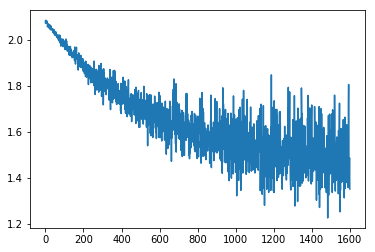

1000 12.5% (0.0m 16.126176834106445s) 1.503 / Physics X Computer Science
2000 25.0% (0.0m 32.29201149940491s) 1.618 / Physics X Statistics
3000 37.5% (0.0m 48.26548957824707s) 1.208 / Physics X Computer Science
4000 50.0% (1.0m 4.2754340171813965s) 1.298 / Physics X Computer Science
5000 62.5% (1.0m 20.44973111152649s) 1.171 / Physics V
6000 75.0% (1.0m 36.52545404434204s) 1.337 / Physics V
7000 87.5% (1.0m 52.71517753601074s) 1.903 / Physics X Computer Science
8000 100.0% (2.0m 8.658027410507202s) 1.915 / Physics X Mathematics
learning rate and characters used: 0.0005 50


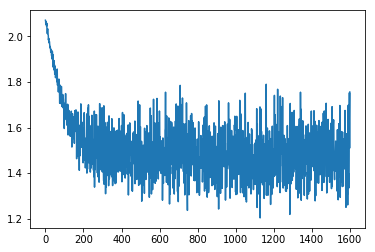

1000 12.5% (0.0m 30.434931993484497s) 1.428 / Physics V
2000 25.0% (1.0m 0.030307292938232422s) 1.685 / Physics X Quantitative Biology
3000 37.5% (1.0m 30.116827726364136s) 1.361 / Physics V
4000 50.0% (2.0m 0.04479360580444336s) 1.179 / Physics X Computer Science
5000 62.5% (2.0m 29.55259609222412s) 1.611 / Physics X Mathematics
6000 75.0% (2.0m 59.12977719306946s) 1.248 / Physics X Mathematics
7000 87.5% (3.0m 29.258570671081543s) 1.927 / Physics V
8000 100.0% (3.0m 58.718374252319336s) 1.383 / Physics V
learning rate and characters used: 0.0005 100


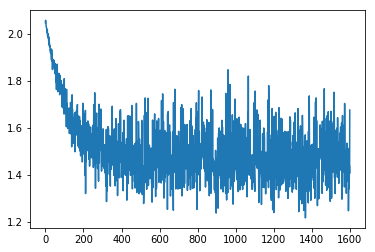

1000 12.5% (0.0m 42.83285474777222s) 1.706 / Physics X Computer Science
2000 25.0% (1.0m 25.01235342025757s) 1.411 / Physics X Computer Science
3000 37.5% (2.0m 7.529109477996826s) 1.45 / Physics V
4000 50.0% (2.0m 49.66794991493225s) 1.199 / Physics V
5000 62.5% (3.0m 32.219616174697876s) 1.792 / Physics X Mathematics
6000 75.0% (4.0m 13.790056467056274s) 1.91 / Physics X Mathematics
7000 87.5% (4.0m 56.070446491241455s) 1.299 / Physics X Mathematics
8000 100.0% (5.0m 38.131062269210815s) 1.387 / Physics X Mathematics
learning rate and characters used: 0.0005 150


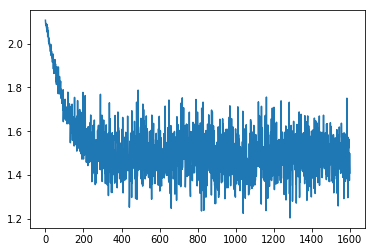

1000 12.5% (0.0m 54.64381504058838s) 1.67 / Physics X Quantitative Biology
2000 25.0% (1.0m 49.96579384803772s) 1.449 / Physics V
3000 37.5% (2.0m 43.21277070045471s) 1.563 / Physics V
4000 50.0% (3.0m 33.79526448249817s) 1.171 / Physics X Mathematics
5000 62.5% (4.0m 24.93788456916809s) 1.888 / Physics X Statistics
6000 75.0% (5.0m 15.650840997695923s) 1.594 / Physics V
7000 87.5% (6.0m 6.632915496826172s) 1.419 / Physics X Computer Science
8000 100.0% (6.0m 57.40142011642456s) 1.393 / Physics X Mathematics
learning rate and characters used: 0.0005 200


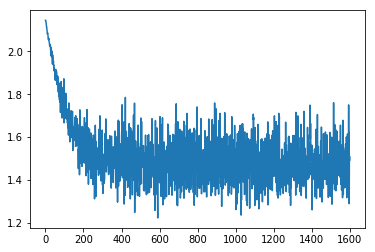

1000 12.5% (1.0m 1.7999296188354492s) 1.491 / Physics X Quantitative Finance
2000 25.0% (2.0m 3.8482935428619385s) 1.713 / Physics X Mathematics
3000 37.5% (3.0m 6.552624464035034s) 1.401 / Physics X Quantitative Biology
4000 50.0% (4.0m 9.056264162063599s) 1.874 / Physics X Statistics
5000 62.5% (5.0m 11.35520887374878s) 1.175 / Physics X Computer Science
6000 75.0% (6.0m 14.22500228881836s) 1.328 / Physics X Mathematics
7000 87.5% (7.0m 17.32357406616211s) 1.59 / Physics V
8000 100.0% (8.0m 20.931814193725586s) 1.286 / Physics V
learning rate and characters used: 0.0005 250


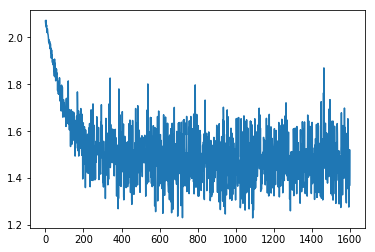

1000 12.5% (1.0m 14.574082374572754s) 1.481 / Physics V
2000 25.0% (2.0m 28.882277488708496s) 1.529 / Physics V
3000 37.5% (3.0m 43.54499912261963s) 1.914 / Physics V
4000 50.0% (4.0m 58.43051242828369s) 1.332 / Physics X Computer Science
5000 62.5% (6.0m 13.3696608543396s) 1.355 / Physics V
6000 75.0% (7.0m 28.64506220817566s) 1.314 / Physics X Quantitative Biology
7000 87.5% (8.0m 44.39516282081604s) 1.565 / Physics X Computer Science
8000 100.0% (9.0m 59.23547863960266s) 1.383 / Physics V
learning rate and characters used: 0.0005 300


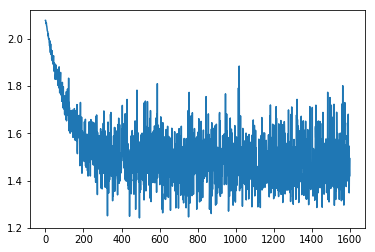

1000 12.5% (1.0m 27.02529001235962s) 1.513 / Physics X Computer Science
2000 25.0% (2.0m 54.81939458847046s) 1.119 / Physics X Computer Science
3000 37.5% (4.0m 22.686381101608276s) 1.476 / Physics V
4000 50.0% (5.0m 50.502275466918945s) 1.52 / Physics V
5000 62.5% (7.0m 18.491674661636353s) 1.597 / Physics X Mathematics
6000 75.0% (8.0m 46.39093065261841s) 1.36 / Physics X Computer Science
7000 87.5% (10.0m 14.449931859970093s) 1.771 / Physics X Computer Science
8000 100.0% (11.0m 42.16910910606384s) 1.403 / Physics V
learning rate and characters used: 0.0005 350


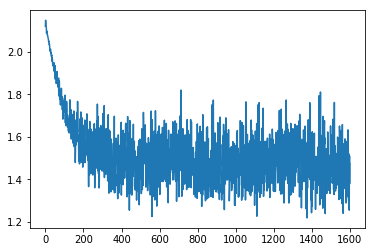

1000 12.5% (1.0m 41.28412914276123s) 1.758 / Physics X Mathematics
2000 25.0% (3.0m 23.50092363357544s) 1.504 / Physics X Computer Science
3000 37.5% (5.0m 4.979928970336914s) 1.403 / Physics V
4000 50.0% (6.0m 46.793909311294556s) 1.422 / Physics X Quantitative Biology
5000 62.5% (8.0m 28.791743993759155s) 1.577 / Physics X Mathematics
6000 75.0% (10.0m 11.372327327728271s) 1.5 / Physics V
7000 87.5% (11.0m 54.532021045684814s) 1.787 / Physics X Mathematics
8000 100.0% (13.0m 37.625181436538696s) 1.256 / Physics V
learning rate and characters used: 0.0005 400


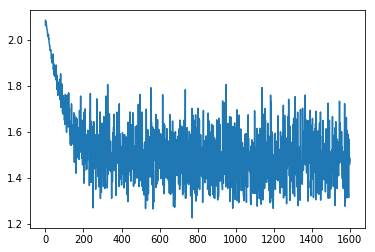

1000 12.5% (1.0m 56.610777378082275s) 1.776 / Physics X Mathematics
2000 25.0% (3.0m 52.699798583984375s) 1.952 / Physics V
3000 37.5% (5.0m 50.5635986328125s) 1.254 / Physics X Mathematics
4000 50.0% (7.0m 50.122779846191406s) 1.804 / Physics X Computer Science
5000 62.5% (9.0m 51.75405788421631s) 1.182 / Physics X Computer Science
6000 75.0% (11.0m 50.72381353378296s) 1.933 / Physics X Computer Science
7000 87.5% (13.0m 45.5559868812561s) 1.25 / Physics V
8000 100.0% (15.0m 39.593849897384644s) 1.474 / Physics V
learning rate and characters used: 0.0005 450


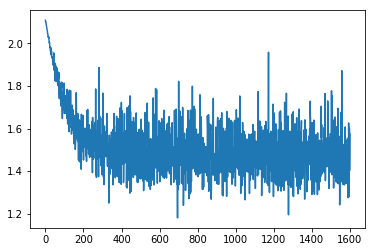

1000 12.5% (2.0m 7.955257892608643s) 1.465 / Physics X Computer Science
2000 25.0% (4.0m 15.70481014251709s) 1.438 / Physics V
3000 37.5% (6.0m 23.946209192276s) 1.676 / Physics X Computer Science
4000 50.0% (8.0m 33.72084093093872s) 1.701 / Physics X Computer Science
5000 62.5% (10.0m 43.11284828186035s) 2.331 / Physics X Quantitative Finance
6000 75.0% (12.0m 51.752686738967896s) 1.559 / Physics V
7000 87.5% (14.0m 59.945098638534546s) 1.86 / Physics X Quantitative Biology
8000 100.0% (17.0m 9.709019899368286s) 1.477 / Physics X Computer Science
learning rate and characters used: 0.0005 500


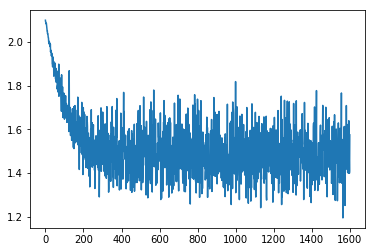

1000 12.5% (2.0m 24.414339303970337s) 1.686 / Physics X Quantitative Biology
2000 25.0% (4.0m 47.614567041397095s) 1.847 / Physics X Computer Science
3000 37.5% (7.0m 11.027454137802124s) 1.633 / Physics V
4000 50.0% (9.0m 35.11229968070984s) 1.715 / Physics X Quantitative Biology
5000 62.5% (11.0m 57.37419104576111s) 1.448 / Physics X Computer Science
6000 75.0% (14.0m 20.716172456741333s) 1.099 / Physics X Computer Science
7000 87.5% (16.0m 42.77145457267761s) 1.185 / Physics V
8000 100.0% (19.0m 4.47955846786499s) 1.668 / Physics V
learning rate and characters used: 0.0005 550


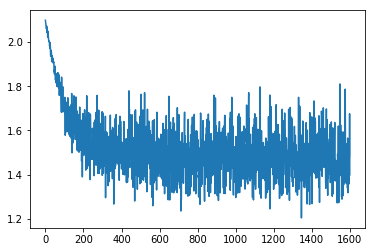

1000 12.5% (2.0m 38.278334856033325s) 1.707 / Physics X Mathematics
2000 25.0% (5.0m 16.38568949699402s) 2.069 / Physics X Quantitative Finance
3000 37.5% (7.0m 58.83928108215332s) 1.701 / Physics X Mathematics
4000 50.0% (10.0m 39.284486055374146s) 1.348 / Physics V
5000 62.5% (13.0m 17.79988718032837s) 2.17 / Physics X Quantitative Biology
6000 75.0% (15.0m 59.756458044052124s) 1.448 / Physics V
7000 87.5% (18.0m 38.5647988319397s) 1.394 / Physics X Mathematics
8000 100.0% (21.0m 18.745816230773926s) 1.329 / Physics X Mathematics
learning rate and characters used: 0.0005 600


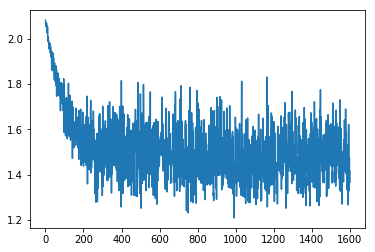

1000 12.5% (2.0m 57.91174364089966s) 1.892 / Physics X Electrical Engineering and Systems Science
2000 25.0% (5.0m 58.811195611953735s) 1.716 / Physics V
3000 37.5% (8.0m 57.36300206184387s) 1.537 / Physics V
4000 50.0% (11.0m 56.50942349433899s) 1.651 / Physics X Computer Science
5000 62.5% (14.0m 54.77381372451782s) 1.846 / Physics X Statistics
6000 75.0% (17.0m 52.26562523841858s) 1.354 / Physics V
7000 87.5% (20.0m 49.617247343063354s) 1.541 / Physics V
8000 100.0% (23.0m 48.07397651672363s) 1.79 / Physics X Statistics
learning rate and characters used: 0.0005 650


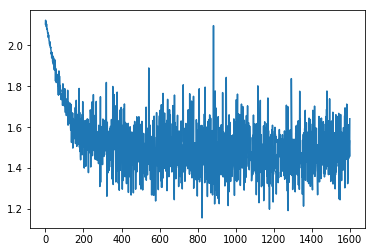

1000 12.5% (0.0m 16.10681986808777s) 1.163 / Physics X Mathematics
2000 25.0% (0.0m 32.232903480529785s) 1.525 / Physics X Computer Science
3000 37.5% (0.0m 48.33174419403076s) 1.348 / Physics X Mathematics
4000 50.0% (1.0m 4.363065481185913s) 1.194 / Physics X Mathematics
5000 62.5% (1.0m 20.580865144729614s) 1.444 / Physics V
6000 75.0% (1.0m 36.81521224975586s) 1.458 / Physics X Mathematics
7000 87.5% (1.0m 52.84546136856079s) 1.579 / Physics V
8000 100.0% (2.0m 8.833305597305298s) 1.535 / Physics X Mathematics
learning rate and characters used: 0.005 50


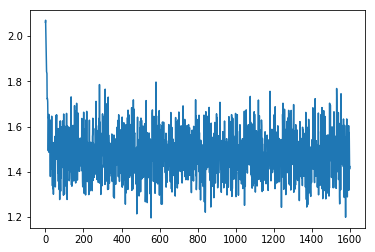

1000 12.5% (0.0m 27.694891214370728s) 1.675 / Physics X Quantitative Finance
2000 25.0% (0.0m 55.738964557647705s) 1.355 / Physics V
3000 37.5% (1.0m 23.703409671783447s) 1.75 / Physics V
4000 50.0% (1.0m 51.72748351097107s) 1.672 / Physics X Quantitative Biology
5000 62.5% (2.0m 19.8932843208313s) 1.404 / Physics X Quantitative Biology
6000 75.0% (2.0m 48.07715368270874s) 1.965 / Physics X Mathematics
7000 87.5% (3.0m 16.35451579093933s) 1.223 / Physics V
8000 100.0% (3.0m 44.65946960449219s) 1.162 / Physics V
learning rate and characters used: 0.005 100


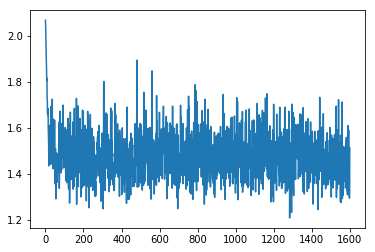

1000 12.5% (0.0m 40.08134055137634s) 2.094 / Physics X Quantitative Biology
2000 25.0% (1.0m 19.64013981819153s) 1.662 / Physics V
3000 37.5% (1.0m 59.34597396850586s) 1.4 / Physics X Quantitative Biology
4000 50.0% (2.0m 39.644185066223145s) 1.507 / Physics X Computer Science
5000 62.5% (3.0m 19.4979031085968s) 1.55 / Physics V
6000 75.0% (3.0m 59.28144192695618s) 1.451 / Physics X Computer Science
7000 87.5% (4.0m 39.26361417770386s) 1.446 / Physics V
8000 100.0% (5.0m 19.43708610534668s) 1.827 / Physics X Mathematics
learning rate and characters used: 0.005 150


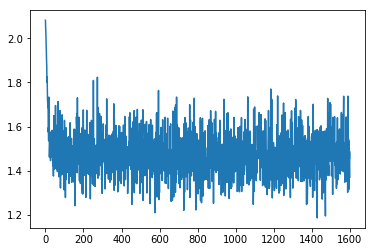

1000 12.5% (0.0m 52.55627226829529s) 1.473 / Physics V
2000 25.0% (1.0m 44.080607652664185s) 1.443 / Physics X Quantitative Biology
3000 37.5% (2.0m 35.91948175430298s) 1.251 / Physics V
4000 50.0% (3.0m 27.5454363822937s) 1.269 / Physics X Mathematics
5000 62.5% (4.0m 19.432419061660767s) 1.524 / Physics V
6000 75.0% (5.0m 11.385539054870605s) 1.217 / Physics V
7000 87.5% (6.0m 3.6148037910461426s) 1.586 / Physics V
8000 100.0% (6.0m 55.791512966156006s) 1.232 / Physics X Mathematics
learning rate and characters used: 0.005 200


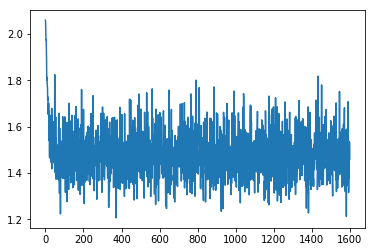

1000 12.5% (1.0m 4.152995586395264s) 1.973 / Physics X Statistics
2000 25.0% (2.0m 7.578568935394287s) 1.469 / Physics X Quantitative Finance
3000 37.5% (3.0m 10.83564305305481s) 1.316 / Physics V
4000 50.0% (4.0m 14.44853162765503s) 1.797 / Physics X Mathematics
5000 62.5% (5.0m 18.205839157104492s) 1.203 / Physics V
6000 75.0% (6.0m 22.181565523147583s) 1.692 / Physics X Statistics
7000 87.5% (7.0m 25.827860832214355s) 1.261 / Physics V
8000 100.0% (8.0m 29.37465524673462s) 1.203 / Physics X Mathematics
learning rate and characters used: 0.005 250


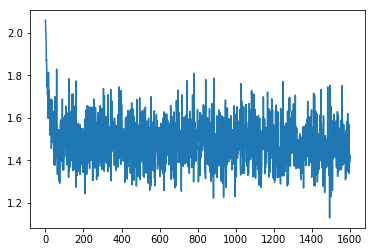

1000 12.5% (1.0m 16.17280626296997s) 1.519 / Physics X Mathematics
2000 25.0% (2.0m 32.39597845077515s) 2.106 / Physics X Computer Science
3000 37.5% (3.0m 49.2723069190979s) 1.783 / Physics X Quantitative Finance
4000 50.0% (5.0m 6.1631622314453125s) 1.573 / Physics V
5000 62.5% (6.0m 23.940733671188354s) 1.349 / Physics V
6000 75.0% (7.0m 41.62969088554382s) 1.623 / Physics X Computer Science
7000 87.5% (8.0m 59.260170459747314s) 1.35 / Physics X Computer Science
8000 100.0% (10.0m 16.453017473220825s) 1.767 / Physics X Mathematics
learning rate and characters used: 0.005 300


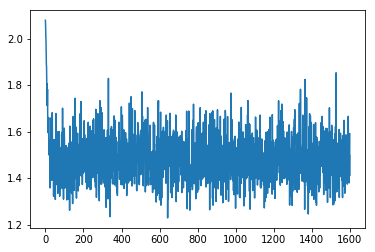

1000 12.5% (1.0m 30.680997133255005s) 1.393 / Physics V
2000 25.0% (3.0m 0.26521968841552734s) 1.703 / Physics V
3000 37.5% (4.0m 29.435808420181274s) 1.637 / Physics X Mathematics
4000 50.0% (5.0m 59.56901168823242s) 1.714 / Physics V
5000 62.5% (7.0m 29.09105157852173s) 1.582 / Physics X Mathematics
6000 75.0% (8.0m 59.06728911399841s) 1.516 / Physics V
7000 87.5% (10.0m 29.376165628433228s) 1.208 / Physics X Mathematics
8000 100.0% (11.0m 58.6393928527832s) 1.827 / Physics V
learning rate and characters used: 0.005 350


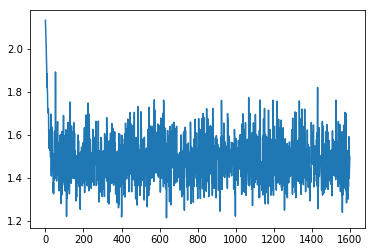

1000 12.5% (1.0m 42.51127886772156s) 1.639 / Physics X Mathematics
2000 25.0% (3.0m 25.649775505065918s) 1.457 / Physics X Mathematics
3000 37.5% (5.0m 8.639638423919678s) 1.693 / Physics V
4000 50.0% (6.0m 51.105340003967285s) 1.446 / Physics V
5000 62.5% (8.0m 33.94682335853577s) 1.262 / Physics X Mathematics
6000 75.0% (10.0m 16.6901695728302s) 1.451 / Physics X Mathematics
7000 87.5% (11.0m 59.74262309074402s) 1.478 / Physics X Computer Science
8000 100.0% (13.0m 41.62510585784912s) 1.37 / Physics X Computer Science
learning rate and characters used: 0.005 400


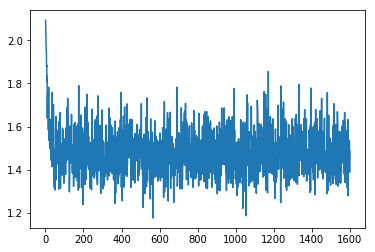

1000 12.5% (1.0m 54.8202691078186s) 1.316 / Physics V
2000 25.0% (3.0m 49.57197070121765s) 2.031 / Physics X Computer Science
3000 37.5% (5.0m 45.14485263824463s) 1.852 / Physics X Mathematics
4000 50.0% (7.0m 39.48620867729187s) 1.589 / Physics X Mathematics
5000 62.5% (9.0m 33.015214920043945s) 1.217 / Physics V
6000 75.0% (11.0m 27.423354864120483s) 1.527 / Physics X Computer Science
7000 87.5% (13.0m 20.921281814575195s) 1.776 / Physics V
8000 100.0% (15.0m 16.8691668510437s) 1.361 / Physics X Mathematics
learning rate and characters used: 0.005 450


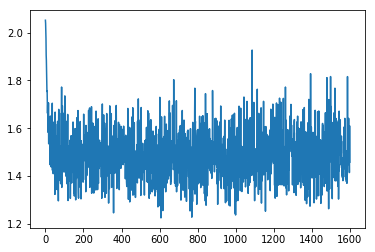

1000 12.5% (2.0m 10.048423051834106s) 1.547 / Physics X Computer Science
2000 25.0% (4.0m 19.545162677764893s) 1.358 / Physics X Computer Science
3000 37.5% (6.0m 29.052006721496582s) 1.439 / Physics V
4000 50.0% (8.0m 37.51285243034363s) 1.74 / Physics X Mathematics
5000 62.5% (10.0m 44.84768581390381s) 1.498 / Physics V
6000 75.0% (12.0m 53.39295935630798s) 1.661 / Physics V
7000 87.5% (15.0m 3.329024314880371s) 2.042 / Physics X Statistics
8000 100.0% (17.0m 13.853044509887695s) 1.715 / Physics X Quantitative Finance
learning rate and characters used: 0.005 500


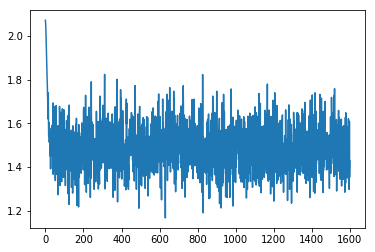

1000 12.5% (2.0m 27.07578182220459s) 1.321 / Physics X Computer Science
2000 25.0% (4.0m 53.41769623756409s) 1.644 / Physics X Computer Science
3000 37.5% (7.0m 17.575294494628906s) 1.382 / Physics V
4000 50.0% (9.0m 42.126096963882446s) 1.416 / Physics X Computer Science
5000 62.5% (12.0m 9.119263887405396s) 1.249 / Physics V
6000 75.0% (14.0m 32.42338418960571s) 1.281 / Physics X Computer Science
7000 87.5% (16.0m 55.74779510498047s) 1.206 / Physics X Mathematics
8000 100.0% (19.0m 18.475990772247314s) 1.119 / Physics X Computer Science
learning rate and characters used: 0.005 550


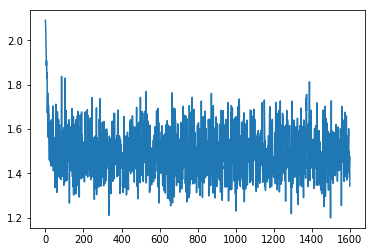

1000 12.5% (2.0m 38.317169427871704s) 1.137 / Physics V
2000 25.0% (5.0m 17.038100481033325s) 1.554 / Physics X Computer Science
3000 37.5% (7.0m 55.97747588157654s) 1.445 / Physics X Mathematics
4000 50.0% (10.0m 34.89777874946594s) 1.102 / Physics X Mathematics
5000 62.5% (13.0m 13.663678646087646s) 1.171 / Physics V
6000 75.0% (15.0m 51.69500184059143s) 1.844 / Physics X Quantitative Biology
7000 87.5% (18.0m 30.57764959335327s) 1.18 / Physics X Computer Science
8000 100.0% (21.0m 8.744479179382324s) 1.971 / Physics X Mathematics
learning rate and characters used: 0.005 600


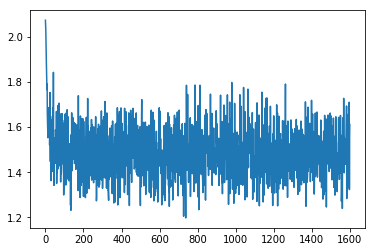

1000 12.5% (2.0m 56.874735593795776s) 1.338 / Physics X Computer Science
2000 25.0% (5.0m 53.04240536689758s) 1.411 / Physics V
3000 37.5% (8.0m 48.24172043800354s) 1.403 / Physics X Computer Science
4000 50.0% (11.0m 43.151904344558716s) 1.172 / Physics X Mathematics
5000 62.5% (14.0m 38.7569420337677s) 1.281 / Computer Science X Mathematics
6000 75.0% (17.0m 37.38020634651184s) 1.682 / Physics X Quantitative Biology
7000 87.5% (20.0m 37.31609320640564s) 1.498 / Physics X Mathematics
8000 100.0% (23.0m 37.43501830101013s) 1.518 / Physics X Mathematics
learning rate and characters used: 0.005 650


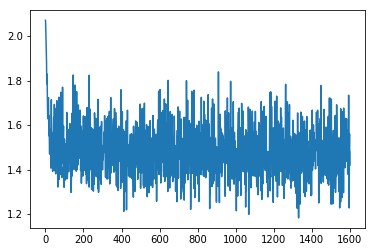

1000 12.5% (0.0m 16.315561771392822s) 1.716 / Physics X Computer Science
2000 25.0% (0.0m 32.64964056015015s) 1.504 / Physics X Mathematics
3000 37.5% (0.0m 49.013012647628784s) 1.859 / Physics X Statistics
4000 50.0% (1.0m 5.214989423751831s) 1.621 / Physics X Computer Science
5000 62.5% (1.0m 21.444502592086792s) 1.868 / Physics X Statistics
6000 75.0% (1.0m 37.582685470581055s) 1.501 / Physics X Quantitative Biology
7000 87.5% (1.0m 53.66611409187317s) 1.609 / Physics X Mathematics
8000 100.0% (2.0m 9.982074499130249s) 2.022 / Physics X Mathematics
learning rate and characters used: 0.01 50


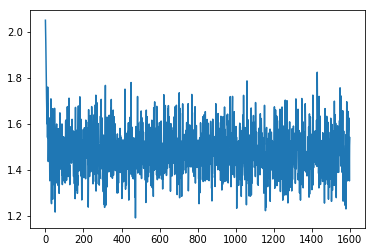

1000 12.5% (0.0m 28.03075337409973s) 1.383 / Physics X Mathematics
2000 25.0% (0.0m 55.84776425361633s) 1.58 / Physics V
3000 37.5% (1.0m 23.677075147628784s) 1.593 / Physics V
4000 50.0% (1.0m 51.368651390075684s) 1.431 / Physics X Mathematics
5000 62.5% (2.0m 19.095276355743408s) 1.499 / Physics V
6000 75.0% (2.0m 47.100035667419434s) 1.588 / Physics V
7000 87.5% (3.0m 15.086905479431152s) 1.865 / Physics X Mathematics
8000 100.0% (3.0m 43.10983681678772s) 1.76 / Physics X Quantitative Finance
learning rate and characters used: 0.01 100


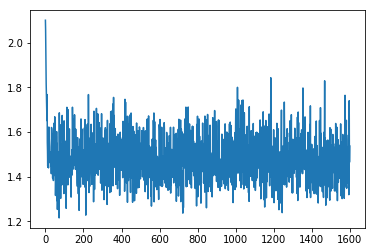

1000 12.5% (0.0m 39.99769949913025s) 1.388 / Physics X Mathematics
2000 25.0% (1.0m 20.034392595291138s) 1.304 / Physics V
3000 37.5% (2.0m 0.49347805976867676s) 1.367 / Physics X Mathematics
4000 50.0% (2.0m 40.13231897354126s) 1.513 / Physics X Computer Science
5000 62.5% (3.0m 19.80224609375s) 1.225 / Computer Science V
6000 75.0% (3.0m 59.119717597961426s) 1.143 / Physics V
7000 87.5% (4.0m 38.45729446411133s) 1.401 / Physics X Statistics
8000 100.0% (5.0m 17.92476463317871s) 1.352 / Physics V
learning rate and characters used: 0.01 150


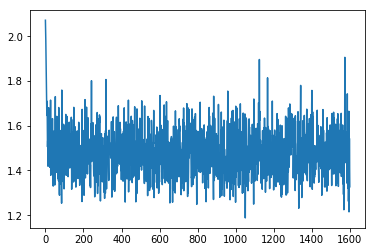

1000 12.5% (0.0m 51.53490662574768s) 1.843 / Physics X Mathematics
2000 25.0% (1.0m 43.22060942649841s) 1.154 / Physics V
3000 37.5% (2.0m 34.45813965797424s) 1.446 / Physics X Mathematics
4000 50.0% (3.0m 25.818805694580078s) 1.631 / Physics X Computer Science
5000 62.5% (4.0m 17.49993348121643s) 1.257 / Physics V
6000 75.0% (5.0m 9.459485530853271s) 1.581 / Physics X Computer Science
7000 87.5% (6.0m 1.1576035022735596s) 1.38 / Physics X Computer Science
8000 100.0% (6.0m 53.05923128128052s) 1.269 / Physics X Computer Science
learning rate and characters used: 0.01 200


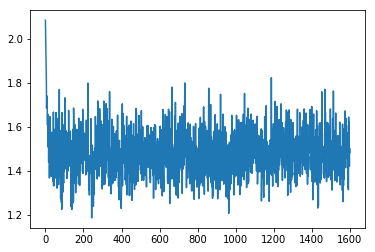

1000 12.5% (1.0m 4.071898698806763s) 1.263 / Physics V
2000 25.0% (2.0m 7.955141544342041s) 1.454 / Physics X Computer Science
3000 37.5% (3.0m 12.210286855697632s) 1.696 / Physics V
4000 50.0% (4.0m 16.564559936523438s) 1.251 / Physics V
5000 62.5% (5.0m 20.679627895355225s) 1.562 / Physics V
6000 75.0% (6.0m 23.866368770599365s) 1.538 / Computer Science V
7000 87.5% (7.0m 27.28547477722168s) 1.359 / Physics V
8000 100.0% (8.0m 30.592609643936157s) 1.504 / Physics V
learning rate and characters used: 0.01 250


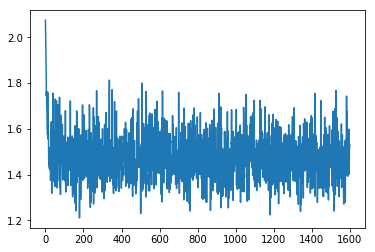

1000 12.5% (1.0m 15.73918890953064s) 1.136 / Physics V
2000 25.0% (2.0m 31.681041717529297s) 1.385 / Physics V
3000 37.5% (3.0m 47.20169997215271s) 1.527 / Physics X Mathematics
4000 50.0% (5.0m 3.425358533859253s) 1.451 / Physics X Mathematics
5000 62.5% (6.0m 19.23706865310669s) 1.643 / Physics X Computer Science
6000 75.0% (7.0m 35.25266695022583s) 1.418 / Physics X Mathematics
7000 87.5% (8.0m 50.9222297668457s) 1.595 / Physics X Computer Science
8000 100.0% (10.0m 6.849485397338867s) 1.264 / Physics X Mathematics
learning rate and characters used: 0.01 300


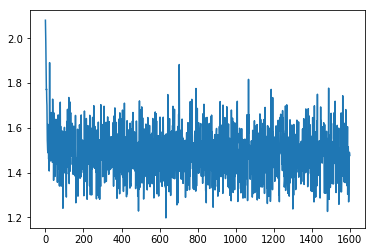

1000 12.5% (1.0m 28.590452432632446s) 1.419 / Physics V
2000 25.0% (2.0m 57.70308065414429s) 1.556 / Physics V
3000 37.5% (4.0m 26.8221333026886s) 1.194 / Physics V
4000 50.0% (5.0m 55.21582746505737s) 1.558 / Physics X Computer Science
5000 62.5% (7.0m 23.857040643692017s) 1.465 / Physics V
6000 75.0% (8.0m 51.98010015487671s) 1.487 / Physics X Mathematics
7000 87.5% (10.0m 20.054418563842773s) 1.763 / Physics X Mathematics
8000 100.0% (11.0m 48.068933963775635s) 1.727 / Physics X Mathematics
learning rate and characters used: 0.01 350


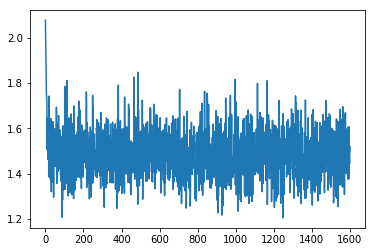

1000 12.5% (1.0m 41.89081382751465s) 1.216 / Physics X Mathematics
2000 25.0% (3.0m 24.9634690284729s) 1.386 / Physics V
3000 37.5% (5.0m 7.048945188522339s) 1.255 / Physics V
4000 50.0% (6.0m 49.746949195861816s) 1.856 / Physics V
5000 62.5% (8.0m 31.162601232528687s) 1.626 / Physics V
6000 75.0% (10.0m 12.108178615570068s) 1.932 / Physics X Statistics
7000 87.5% (11.0m 52.67087912559509s) 1.588 / Physics V
8000 100.0% (13.0m 33.330665588378906s) 1.654 / Physics V
learning rate and characters used: 0.01 400


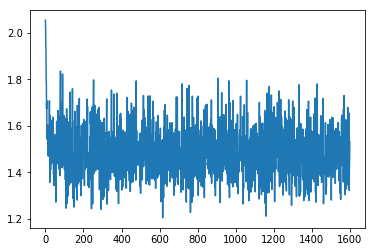

1000 12.5% (1.0m 53.68432283401489s) 1.347 / Physics X Mathematics
2000 25.0% (3.0m 47.28523635864258s) 1.737 / Physics X Computer Science
3000 37.5% (5.0m 40.48816466331482s) 1.343 / Physics X Mathematics
4000 50.0% (7.0m 33.58596086502075s) 1.669 / Physics V
5000 62.5% (9.0m 26.558024644851685s) 1.371 / Physics V
6000 75.0% (11.0m 19.23868227005005s) 1.712 / Physics V
7000 87.5% (13.0m 12.039050102233887s) 1.269 / Physics V
8000 100.0% (15.0m 4.223095417022705s) 1.487 / Physics X Computer Science
learning rate and characters used: 0.01 450


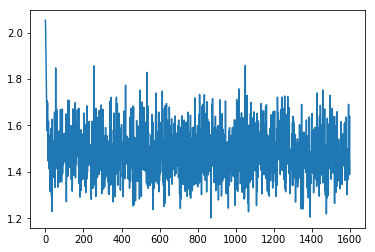

1000 12.5% (2.0m 6.0964837074279785s) 1.409 / Physics V
2000 25.0% (4.0m 12.430775165557861s) 1.865 / Physics X Computer Science
3000 37.5% (6.0m 17.996267318725586s) 1.452 / Physics X Computer Science
4000 50.0% (8.0m 23.74634552001953s) 1.652 / Physics X Computer Science
5000 62.5% (10.0m 29.552698135375977s) 1.191 / Physics V
6000 75.0% (12.0m 35.19800519943237s) 1.438 / Physics V
7000 87.5% (14.0m 41.14798021316528s) 1.74 / Physics X Quantitative Biology
8000 100.0% (16.0m 46.97215747833252s) 1.793 / Physics X Mathematics
learning rate and characters used: 0.01 500


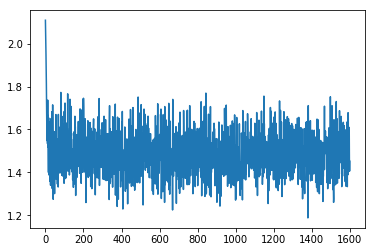

1000 12.5% (2.0m 20.60293436050415s) 1.257 / Physics X Mathematics
2000 25.0% (4.0m 40.874446392059326s) 1.399 / Physics X Computer Science
3000 37.5% (7.0m 0.45020532608032227s) 2.111 / Physics X Computer Science
4000 50.0% (9.0m 20.39435839653015s) 1.557 / Physics V
5000 62.5% (11.0m 40.34235882759094s) 1.505 / Physics X Quantitative Biology
6000 75.0% (14.0m 0.7890980243682861s) 2.222 / Physics X Mathematics
7000 87.5% (16.0m 20.556735038757324s) 1.78 / Physics V
8000 100.0% (18.0m 40.83307099342346s) 1.362 / Physics X Computer Science
learning rate and characters used: 0.01 550


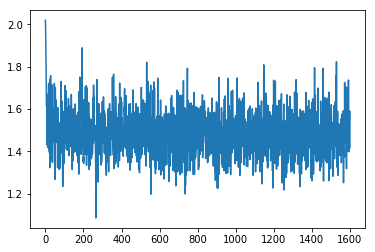

1000 12.5% (2.0m 35.35675358772278s) 1.751 / Physics X Quantitative Biology
2000 25.0% (5.0m 11.319676876068115s) 1.592 / Physics X Computer Science
3000 37.5% (7.0m 47.16136813163757s) 1.356 / Physics V
4000 50.0% (10.0m 22.806822776794434s) 1.099 / Physics X Mathematics
5000 62.5% (12.0m 57.82489633560181s) 1.62 / Physics V
6000 75.0% (15.0m 33.063947916030884s) 1.239 / Physics X Computer Science
7000 87.5% (18.0m 7.697737455368042s) 1.821 / Physics V
8000 100.0% (20.0m 43.213096141815186s) 2.027 / Physics V
learning rate and characters used: 0.01 600


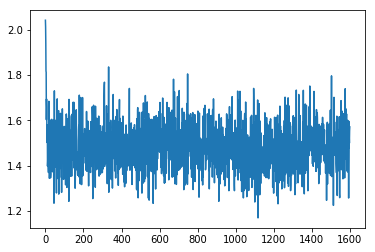

1000 12.5% (2.0m 53.009350538253784s) 1.531 / Physics X Computer Science
2000 25.0% (5.0m 44.82900261878967s) 1.065 / Physics V
3000 37.5% (8.0m 35.61596894264221s) 1.271 / Physics X Computer Science
4000 50.0% (11.0m 27.537955045700073s) 1.176 / Physics X Statistics
5000 62.5% (14.0m 18.9095938205719s) 1.085 / Physics X Computer Science
6000 75.0% (17.0m 11.039751768112183s) 1.496 / Physics X Quantitative Biology
7000 87.5% (20.0m 2.648921251296997s) 1.575 / Physics X Computer Science
8000 100.0% (22.0m 54.54865527153015s) 1.444 / Physics X Computer Science
learning rate and characters used: 0.01 650


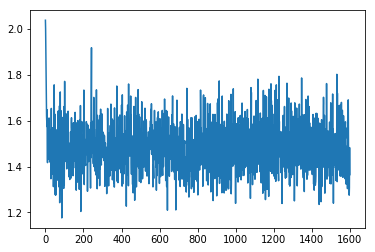

1000 12.5% (0.0m 15.6919584274292s) 1.668 / Physics X Electrical Engineering and Systems Science
2000 25.0% (0.0m 31.36358642578125s) 1.44 / Physics X Mathematics
3000 37.5% (0.0m 47.02848196029663s) 1.615 / Physics X Quantitative Biology
4000 50.0% (1.0m 2.6808228492736816s) 1.338 / Physics V
5000 62.5% (1.0m 18.375391960144043s) 2.033 / Physics V
6000 75.0% (1.0m 34.25346398353577s) 1.479 / Physics X Computer Science
7000 87.5% (1.0m 50.07000732421875s) 1.352 / Physics V
8000 100.0% (2.0m 5.725292682647705s) 1.595 / Physics X Quantitative Finance
learning rate and characters used: 0.05 50


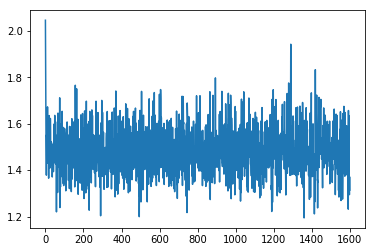

1000 12.5% (0.0m 26.95990777015686s) 1.524 / Physics X Computer Science
2000 25.0% (0.0m 53.956106185913086s) 1.686 / Physics V
3000 37.5% (1.0m 20.849481105804443s) 1.429 / Mathematics X Physics
4000 50.0% (1.0m 47.717005491256714s) 1.875 / Physics X Mathematics
5000 62.5% (2.0m 14.725637674331665s) 1.501 / Physics V
6000 75.0% (2.0m 41.614449977874756s) 1.641 / Physics V
7000 87.5% (3.0m 8.625690221786499s) 1.794 / Physics X Computer Science
8000 100.0% (3.0m 35.63877081871033s) 1.477 / Physics V
learning rate and characters used: 0.05 100


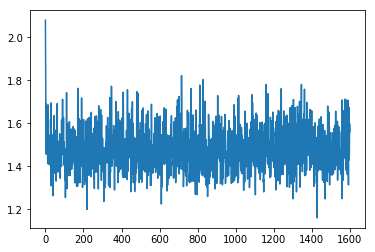

1000 12.5% (0.0m 38.087220668792725s) 1.505 / Mathematics X Physics
2000 25.0% (1.0m 16.386415719985962s) 1.463 / Physics X Computer Science
3000 37.5% (1.0m 54.40006947517395s) 1.253 / Physics V
4000 50.0% (2.0m 32.50961232185364s) 1.385 / Mathematics X Physics
5000 62.5% (3.0m 10.4998619556427s) 1.773 / Physics X Mathematics
6000 75.0% (3.0m 48.62943887710571s) 1.202 / Physics X Mathematics
7000 87.5% (4.0m 26.686190366744995s) 1.516 / Physics V
8000 100.0% (5.0m 4.892814636230469s) 1.546 / Physics X Computer Science
learning rate and characters used: 0.05 150


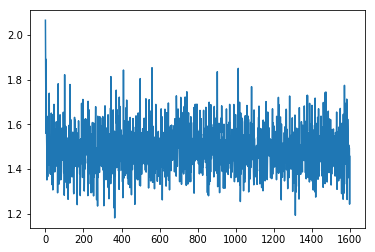

1000 12.5% (0.0m 49.550710916519165s) 1.486 / Physics V
2000 25.0% (1.0m 39.392207622528076s) 1.689 / Physics V
3000 37.5% (2.0m 28.866953372955322s) 1.178 / Physics X Computer Science
4000 50.0% (3.0m 18.55738925933838s) 1.42 / Physics V
5000 62.5% (4.0m 8.318071603775024s) 1.866 / Physics V
6000 75.0% (4.0m 57.969826459884644s) 1.721 / Physics X Mathematics
7000 87.5% (5.0m 47.66230797767639s) 1.342 / Mathematics X Computer Science
8000 100.0% (6.0m 37.46611166000366s) 1.199 / Physics V
learning rate and characters used: 0.05 200


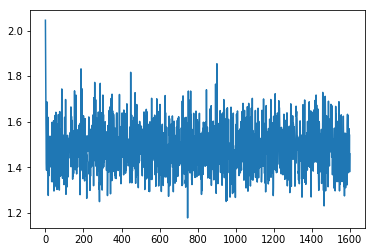

1000 12.5% (1.0m 1.0611634254455566s) 1.892 / Physics X Mathematics
2000 25.0% (2.0m 2.1880879402160645s) 1.623 / Physics X Computer Science
3000 37.5% (3.0m 3.37050199508667s) 1.287 / Physics X Mathematics
4000 50.0% (4.0m 4.3723671436309814s) 1.601 / Physics X Mathematics
5000 62.5% (5.0m 5.649883508682251s) 1.315 / Physics X Computer Science
6000 75.0% (6.0m 6.801336765289307s) 1.368 / Physics X Computer Science
7000 87.5% (7.0m 8.000390529632568s) 1.477 / Physics V
8000 100.0% (8.0m 9.136668682098389s) 1.461 / Physics X Mathematics
learning rate and characters used: 0.05 250


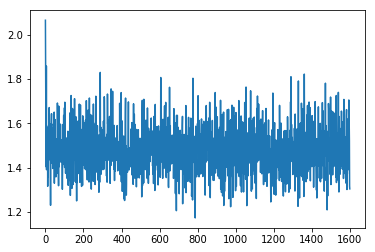

1000 12.5% (1.0m 13.04569673538208s) 1.417 / Physics X Statistics
2000 25.0% (2.0m 26.339975118637085s) 1.48 / Physics V
3000 37.5% (3.0m 39.452566385269165s) 1.642 / Physics V
4000 50.0% (4.0m 52.52901315689087s) 1.322 / Physics X Computer Science
5000 62.5% (6.0m 5.7290120124816895s) 1.38 / Physics V
6000 75.0% (7.0m 19.22006607055664s) 1.789 / Physics X Computer Science
7000 87.5% (8.0m 32.45912051200867s) 1.493 / Physics V
8000 100.0% (9.0m 45.588483572006226s) 1.479 / Physics X Computer Science
learning rate and characters used: 0.05 300


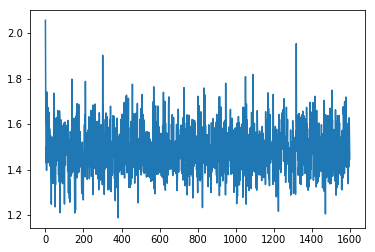

1000 12.5% (1.0m 25.124006509780884s) 1.441 / Physics V
2000 25.0% (2.0m 50.33983635902405s) 1.132 / Physics X Mathematics
3000 37.5% (4.0m 15.328610897064209s) 1.516 / Physics X Computer Science
4000 50.0% (5.0m 40.71909999847412s) 1.309 / Computer Science X Mathematics
5000 62.5% (7.0m 5.62900185585022s) 1.611 / Physics V
6000 75.0% (8.0m 30.915461778640747s) 1.263 / Physics V
7000 87.5% (9.0m 55.88062572479248s) 1.662 / Physics V
8000 100.0% (11.0m 20.96637463569641s) 1.105 / Physics X Mathematics
learning rate and characters used: 0.05 350


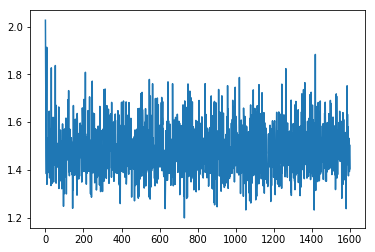

1000 12.5% (1.0m 38.420106410980225s) 1.246 / Physics X Mathematics
2000 25.0% (3.0m 16.23593044281006s) 1.191 / Physics X Computer Science
3000 37.5% (4.0m 54.172985553741455s) 1.61 / Physics X Computer Science
4000 50.0% (6.0m 32.08390212059021s) 1.343 / Physics X Computer Science
5000 62.5% (8.0m 10.347166061401367s) 1.365 / Physics X Mathematics


In [0]:
#DO NOT RUN



#EXPERIMENT CHANGING INPUT SIZE AND LEARNING RATE, and weighted data (4 layers LSTM)


learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=50;               #this is the minimum abstract length we are testing our model on
max_length=700
print_every = 1000
plot_every = 5

for learning_rate in (0.0001, 0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in range (minimum, max_length, 50):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


This is a ultimate try, adding a linear layer iin between 4 LSTM layers. Then I also change the optimizer to be Adam, I introduced dropout in the net as well as transforming it into a bidirectional LSTM. I also added a sigmoid layer at the end of my net, and set 512 as the number of the hidden nodes in each LSTM net


1000 1.25% (0.0m 20.817811727523804s) 1.209 / Physics V
2000 2.5% (0.0m 41.78201413154602s) 1.543 / Physics V
3000 3.75% (1.0m 2.580613613128662s) 1.57 / Physics V
4000 5.0% (1.0m 23.649675846099854s) 1.508 / Physics X Mathematics
5000 6.25% (1.0m 44.46425700187683s) 1.529 / Mathematics V
6000 7.5% (2.0m 5.375566005706787s) 1.327 / Computer Science X Mathematics
7000 8.75% (2.0m 26.07309079170227s) 1.42 / Physics X Computer Science
8000 10.0% (2.0m 46.78512620925903s) 1.436 / Physics X Computer Science
9000 11.25% (3.0m 7.591822147369385s) 1.411 / Physics V
10000 12.5% (3.0m 28.471110343933105s) 1.568 / Physics V
11000 13.75% (3.0m 49.16913652420044s) 1.626 / Mathematics V
12000 15.0% (4.0m 9.798675060272217s) 1.289 / Computer Science X Quantitative Biology
13000 16.25% (4.0m 30.470218658447266s) 1.205 / Physics X Computer Science
14000 17.5% (4.0m 51.27534508705139s) 1.289 / Computer Science X Mathematics
15000 18.75% (5.0m 11.83719778060913s) 1.006 / Computer Science X Mathematics
16

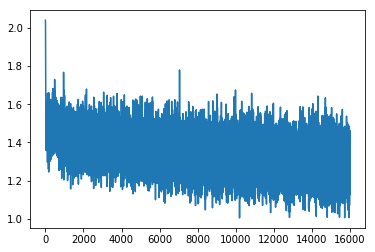

1000 1.25% (1.0m 7.816346168518066s) 1.233 / Physics X Mathematics
2000 2.5% (2.0m 15.789968967437744s) 1.429 / Physics V
3000 3.75% (3.0m 24.144681692123413s) 1.527 / Physics V
4000 5.0% (4.0m 32.07673096656799s) 1.674 / Physics V
5000 6.25% (5.0m 39.71090245246887s) 1.522 / Physics X Mathematics
6000 7.5% (6.0m 47.43736529350281s) 1.709 / Physics X Quantitative Biology
7000 8.75% (7.0m 55.27099919319153s) 1.248 / Physics X Computer Science
8000 10.0% (9.0m 3.0262064933776855s) 1.475 / Physics X Computer Science
9000 11.25% (10.0m 10.85690450668335s) 1.493 / Physics V
10000 12.5% (11.0m 18.648468494415283s) 1.342 / Physics V
11000 13.75% (12.0m 26.28228235244751s) 1.692 / Physics X Economics
12000 15.0% (13.0m 34.039414405822754s) 1.533 / Physics V
13000 16.25% (14.0m 41.84189796447754s) 1.451 / Physics X Mathematics
14000 17.5% (15.0m 49.79818296432495s) 1.634 / Physics V
15000 18.75% (16.0m 57.328031063079834s) 1.51 / Physics V
16000 20.0% (18.0m 4.557305574417114s) 1.349 / Physics 

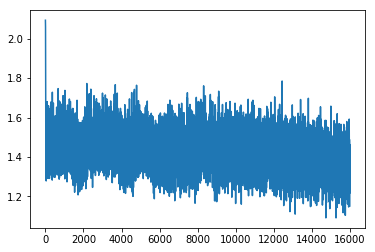

1000 1.25% (2.0m 48.93935441970825s) 1.564 / Physics V
2000 2.5% (5.0m 37.032641887664795s) 1.306 / Physics X Mathematics
3000 3.75% (8.0m 24.699321746826172s) 1.518 / Physics X Computer Science
4000 5.0% (11.0m 12.465759038925171s) 1.475 / Physics V
5000 6.25% (13.0m 59.68605399131775s) 1.418 / Physics X Computer Science
6000 7.5% (16.0m 47.62112283706665s) 1.495 / Physics X Mathematics
7000 8.75% (19.0m 36.0334312915802s) 1.408 / Physics X Computer Science
8000 10.0% (22.0m 23.038621187210083s) 1.357 / Physics V
9000 11.25% (25.0m 12.002381801605225s) 1.224 / Physics V
10000 12.5% (27.0m 59.75977349281311s) 1.534 / Physics X Computer Science
11000 13.75% (30.0m 46.99745583534241s) 1.525 / Physics X Quantitative Biology
12000 15.0% (33.0m 35.47592067718506s) 1.369 / Physics X Mathematics
13000 16.25% (36.0m 24.551371574401855s) 1.455 / Physics X Mathematics
14000 17.5% (39.0m 11.712138414382935s) 1.05 / Physics V
15000 18.75% (41.0m 58.16431665420532s) 1.272 / Physics V
16000 20.0% (4

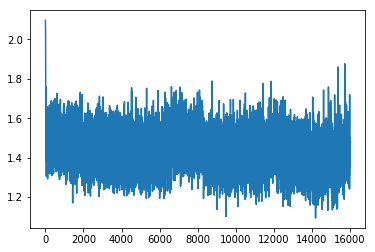

1000 1.25% (4.0m 13.121577024459839s) 1.528 / Physics V
2000 2.5% (8.0m 25.120911836624146s) 1.498 / Physics X Computer Science
3000 3.75% (12.0m 37.331639766693115s) 1.419 / Physics V
4000 5.0% (16.0m 49.1355676651001s) 1.325 / Physics X Computer Science
5000 6.25% (21.0m 0.9058434963226318s) 1.645 / Physics X Computer Science
6000 7.5% (25.0m 13.579246282577515s) 1.541 / Physics X Quantitative Biology
7000 8.75% (29.0m 27.30006718635559s) 1.553 / Physics X Computer Science
8000 10.0% (33.0m 40.393507957458496s) 1.346 / Physics V
9000 11.25% (37.0m 53.44797420501709s) 1.129 / Physics V
10000 12.5% (42.0m 4.8648200035095215s) 1.48 / Physics V
11000 13.75% (46.0m 16.207587480545044s) 1.386 / Physics V
12000 15.0% (50.0m 29.12692427635193s) 1.529 / Physics X Computer Science
13000 16.25% (54.0m 41.42649698257446s) 1.674 / Physics V
14000 17.5% (58.0m 53.34842801094055s) 1.284 / Physics V
15000 18.75% (63.0m 5.829427242279053s) 1.431 / Physics V
16000 20.0% (67.0m 18.11459970474243s) 1.91

In [0]:
criterion = nn.CrossEntropyLoss()

n_iters = 80000
batch_size = 20
print_every = 1000
plot_every = 5

for learning_rate in (0.0001, 0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in (50, 200, 500, 700):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
   plot_losses(all_losses)


1000 5.0% (0.0m 19.49675965309143s) 1.283 / Physics X Computer Science
2000 10.0% (0.0m 38.79970192909241s) 1.566 / Physics V
3000 15.0% (0.0m 58.12937259674072s) 1.529 / Physics X Computer Science
4000 20.0% (1.0m 17.52089500427246s) 1.627 / Mathematics X Quantitative Finance
5000 25.0% (1.0m 36.88435411453247s) 1.257 / Physics V
6000 30.0% (1.0m 56.27718901634216s) 1.277 / Physics V
7000 35.0% (2.0m 15.635230779647827s) 1.25 / Physics X Mathematics
8000 40.0% (2.0m 34.974660873413086s) 1.47 / Mathematics X Computer Science
9000 45.0% (2.0m 54.346553802490234s) 1.66 / Physics X Computer Science
10000 50.0% (3.0m 13.839191913604736s) 1.296 / Physics X Computer Science
11000 55.0% (3.0m 33.20259356498718s) 1.399 / Mathematics X Computer Science
12000 60.0% (3.0m 52.629252672195435s) 1.296 / Physics X Computer Science
13000 65.0% (4.0m 12.00366759300232s) 1.823 / Physics V
14000 70.0% (4.0m 31.512614965438843s) 1.11 / Physics X Computer Science
15000 75.0% (4.0m 51.055379152297974s) 1.19

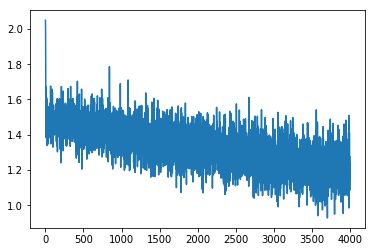

1000 5.0% (1.0m 4.258066654205322s) 1.348 / Physics X Computer Science
2000 10.0% (2.0m 8.68533205986023s) 1.745 / Physics X Quantitative Biology
3000 15.0% (3.0m 13.11208963394165s) 1.441 / Physics X Mathematics
4000 20.0% (4.0m 17.502596616744995s) 1.555 / Physics X Mathematics
5000 25.0% (5.0m 21.860441207885742s) 1.206 / Physics V
6000 30.0% (6.0m 26.222042083740234s) 1.468 / Physics X Economics
7000 35.0% (7.0m 30.727503299713135s) 1.509 / Physics V
8000 40.0% (8.0m 35.25126552581787s) 1.639 / Physics X Statistics
9000 45.0% (9.0m 39.82063627243042s) 1.413 / Physics X Mathematics
10000 50.0% (10.0m 44.399752140045166s) 1.359 / Physics V
11000 55.0% (11.0m 48.93677020072937s) 1.53 / Physics V
12000 60.0% (12.0m 53.39434361457825s) 1.479 / Physics V
13000 65.0% (13.0m 58.05885672569275s) 1.588 / Physics X Statistics
14000 70.0% (15.0m 2.485177516937256s) 1.307 / Physics X Quantitative Biology
15000 75.0% (16.0m 7.081182956695557s) 1.324 / Physics X Computer Science
16000 80.0% (17.0

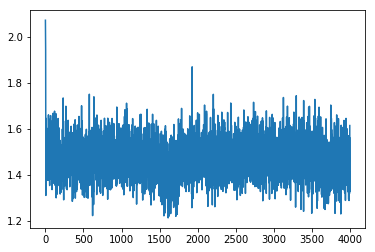

1000 5.0% (2.0m 42.472779989242554s) 1.511 / Physics V
2000 10.0% (5.0m 26.17174196243286s) 1.435 / Physics X Mathematics
3000 15.0% (8.0m 10.010866641998291s) 1.582 / Physics X Quantitative Biology
4000 20.0% (10.0m 54.18159317970276s) 1.597 / Mathematics V
5000 25.0% (13.0m 38.88267636299133s) 1.359 / Physics X Mathematics
6000 30.0% (16.0m 23.241447687149048s) 1.492 / Physics X Quantitative Biology
7000 35.0% (19.0m 7.048671722412109s) 1.46 / Physics V
8000 40.0% (21.0m 51.76047682762146s) 1.517 / Physics V
9000 45.0% (24.0m 36.36404037475586s) 1.522 / Physics X Computer Science
10000 50.0% (27.0m 21.154787063598633s) 1.728 / Physics V
11000 55.0% (30.0m 5.327197074890137s) 1.209 / Mathematics X Computer Science
12000 60.0% (32.0m 49.17500305175781s) 1.51 / Physics V
13000 65.0% (35.0m 33.24700736999512s) 1.493 / Physics X Mathematics
14000 70.0% (38.0m 17.95758605003357s) 1.507 / Physics V
15000 75.0% (41.0m 1.572486400604248s) 1.655 / Physics V
16000 80.0% (43.0m 45.7964448928833s

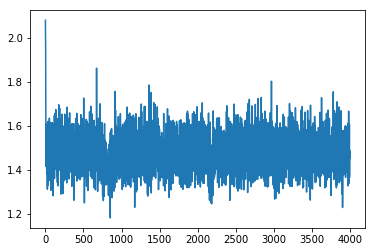

1000 5.0% (4.0m 16.056771993637085s) 1.46 / Physics X Mathematics
2000 10.0% (8.0m 33.9495210647583s) 1.264 / Physics V
3000 15.0% (12.0m 51.6437349319458s) 1.598 / Computer Science X Mathematics
4000 20.0% (17.0m 7.956590890884399s) 1.269 / Physics X Computer Science
5000 25.0% (21.0m 24.871837615966797s) 1.375 / Physics V
6000 30.0% (25.0m 41.57510542869568s) 1.287 / Physics X Computer Science
7000 35.0% (29.0m 58.96572995185852s) 1.214 / Physics X Mathematics
8000 40.0% (34.0m 15.666138172149658s) 1.373 / Computer Science X Physics
9000 45.0% (38.0m 32.41980051994324s) 1.418 / Physics X Statistics
10000 50.0% (42.0m 49.315993309020996s) 1.348 / Physics X Mathematics
11000 55.0% (47.0m 5.9144606590271s) 1.529 / Physics X Statistics
12000 60.0% (51.0m 24.153671741485596s) 1.554 / Physics X Mathematics
13000 65.0% (55.0m 40.56788945198059s) 1.523 / Physics X Statistics
14000 70.0% (59.0m 57.240676164627075s) 1.348 / Physics X Computer Science
15000 75.0% (64.0m 13.475016593933105s) 1.4

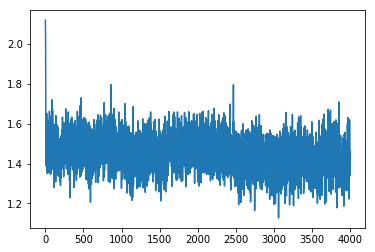

1000 5.0% (0.0m 19.606964111328125s) 1.245 / Physics V
2000 10.0% (0.0m 39.23480296134949s) 1.694 / Physics X Mathematics
3000 15.0% (0.0m 58.87246036529541s) 1.442 / Physics X Mathematics
4000 20.0% (1.0m 18.50662350654602s) 1.34 / Mathematics X Computer Science
5000 25.0% (1.0m 38.129209756851196s) 1.557 / Physics X Mathematics
6000 30.0% (1.0m 57.75557613372803s) 1.672 / Physics X Computer Science
7000 35.0% (2.0m 17.472320795059204s) 1.529 / Physics V
8000 40.0% (2.0m 37.14868092536926s) 1.311 / Physics X Mathematics
9000 45.0% (2.0m 56.78679037094116s) 1.221 / Physics V
10000 50.0% (3.0m 16.400949716567993s) 1.372 / Physics X Mathematics
11000 55.0% (3.0m 36.080342054367065s) 1.541 / Physics V
12000 60.0% (3.0m 55.76089334487915s) 1.592 / Physics X Statistics
13000 65.0% (4.0m 15.369655132293701s) 1.377 / Physics V
14000 70.0% (4.0m 35.01351594924927s) 1.643 / Physics X Mathematics
15000 75.0% (4.0m 54.62341833114624s) 1.359 / Physics X Mathematics
16000 80.0% (5.0m 14.29637527465

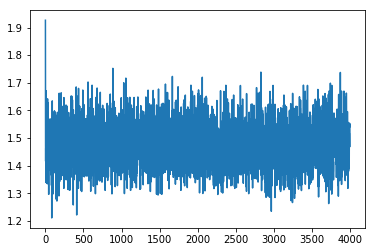

1000 5.0% (1.0m 4.836057901382446s) 1.538 / Mathematics V
2000 10.0% (2.0m 9.680975914001465s) 1.812 / Physics V
3000 15.0% (3.0m 14.48330569267273s) 1.247 / Physics X Mathematics
4000 20.0% (4.0m 19.236730337142944s) 1.623 / Physics X Computer Science
5000 25.0% (5.0m 24.024930477142334s) 1.21 / Physics X Mathematics
6000 30.0% (6.0m 28.96277379989624s) 1.425 / Physics V
7000 35.0% (7.0m 33.79459071159363s) 1.769 / Physics X Mathematics
8000 40.0% (8.0m 38.523221492767334s) 1.373 / Physics V
9000 45.0% (9.0m 43.36630892753601s) 1.765 / Physics X Computer Science
10000 50.0% (10.0m 48.25914549827576s) 1.428 / Physics X Mathematics
11000 55.0% (11.0m 53.17345309257507s) 1.498 / Physics V
12000 60.0% (12.0m 57.914785385131836s) 1.278 / Physics X Mathematics
13000 65.0% (14.0m 2.677813768386841s) 1.342 / Physics X Computer Science
14000 70.0% (15.0m 7.515131711959839s) 1.555 / Physics X Statistics
15000 75.0% (16.0m 12.32346487045288s) 1.636 / Physics V
16000 80.0% (17.0m 17.2954950332641

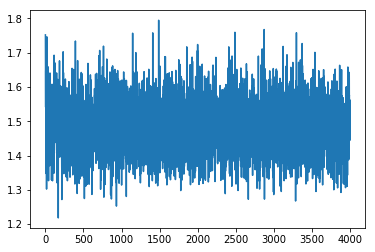

1000 5.0% (2.0m 45.20942950248718s) 1.651 / Physics V
2000 10.0% (5.0m 30.11849808692932s) 1.559 / Physics V
3000 15.0% (8.0m 14.690639019012451s) 1.182 / Physics V
4000 20.0% (10.0m 59.114113569259644s) 1.555 / Physics X Computer Science


KeyboardInterrupt: ignored

In [0]:
#again, as it didn't test everything....

criterion = nn.CrossEntropyLoss()

n_iters = 20000
batch_size = 20
print_every = 1000
plot_every = 5

for learning_rate in (0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in (50, 200, 500, 700):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 5.0% (0.0m 19.40567946434021s) 2.09 / Electrical Engineering and Systems Science X Economics
2000 10.0% (0.0m 38.70429611206055s) 2.075 / Quantitative Biology V
3000 15.0% (0.0m 58.02663254737854s) 2.101 / Quantitative Finance X Computer Science
4000 20.0% (1.0m 17.382603883743286s) 2.051 / Economics X Statistics
5000 25.0% (1.0m 36.74073648452759s) 2.007 / Quantitative Finance V
6000 30.0% (1.0m 56.12874889373779s) 2.067 / Economics X Quantitative Finance
7000 35.0% (2.0m 15.47306776046753s) 1.807 / Electrical Engineering and Systems Science X Quantitative Biology
8000 40.0% (2.0m 34.83416414260864s) 2.022 / Electrical Engineering and Systems Science X Quantitative Finance
9000 45.0% (2.0m 54.200443744659424s) 2.028 / Quantitative Biology X Computer Science
10000 50.0% (3.0m 13.56806230545044s) 2.073 / Quantitative Finance X Economics
11000 55.0% (3.0m 32.910168170928955s) 2.018 / Economics X Statistics
12000 60.0% (3.0m 52.3584418296814s) 2.079 / Mathematics X Economics
13000 65

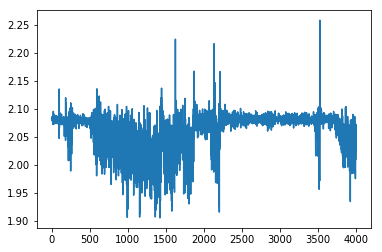

1000 5.0% (1.0m 4.075231313705444s) 1.996 / Economics X Computer Science
2000 10.0% (2.0m 8.079965353012085s) 2.069 / Quantitative Finance X Quantitative Biology
3000 15.0% (3.0m 12.290510892868042s) 2.018 / Quantitative Finance X Electrical Engineering and Systems Science
4000 20.0% (4.0m 16.360042810440063s) 2.014 / Quantitative Biology X Computer Science
5000 25.0% (5.0m 20.44991111755371s) 2.082 / Quantitative Finance X Physics
6000 30.0% (6.0m 24.527312994003296s) 2.099 / Economics X Statistics
7000 35.0% (7.0m 28.575275182724s) 2.077 / Statistics X Mathematics
8000 40.0% (8.0m 32.82552480697632s) 2.076 / Statistics X Quantitative Biology
9000 45.0% (9.0m 36.83273911476135s) 2.073 / Quantitative Biology V
10000 50.0% (10.0m 40.930760622024536s) 2.078 / Physics X Quantitative Biology
11000 55.0% (11.0m 45.12354898452759s) 2.067 / Statistics X Electrical Engineering and Systems Science
12000 60.0% (12.0m 49.460124492645264s) 2.507 / Mathematics X Electrical Engineering and Systems S

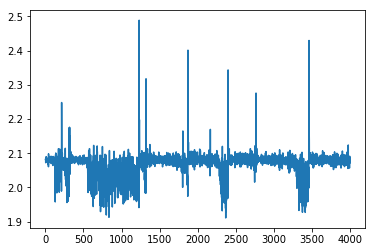

1000 5.0% (2.0m 39.47705936431885s) 2.132 / Electrical Engineering and Systems Science X Quantitative Biology
2000 10.0% (5.0m 18.570802211761475s) 2.239 / Economics X Physics
3000 15.0% (7.0m 57.59490609169006s) 1.942 / Economics X Electrical Engineering and Systems Science
4000 20.0% (10.0m 35.566017866134644s) 2.004 / Electrical Engineering and Systems Science X Physics
5000 25.0% (13.0m 13.729882955551147s) 2.076 / Statistics X Electrical Engineering and Systems Science
6000 30.0% (15.0m 52.51754283905029s) 2.096 / Economics X Computer Science
7000 35.0% (18.0m 30.70706033706665s) 2.075 / Quantitative Biology X Electrical Engineering and Systems Science
8000 40.0% (21.0m 8.897775888442993s) 1.998 / Economics V
9000 45.0% (23.0m 47.43059158325195s) 2.016 / Electrical Engineering and Systems Science X Computer Science
10000 50.0% (26.0m 25.950343370437622s) 2.119 / Quantitative Biology X Physics
11000 55.0% (29.0m 7.151423931121826s) 1.932 / Economics X Electrical Engineering and Sys

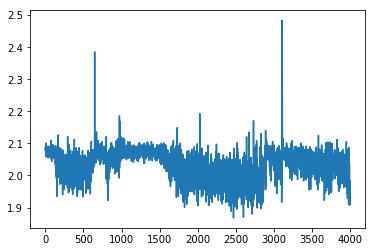

1000 5.0% (4.0m 7.175626277923584s) 1.93 / Electrical Engineering and Systems Science X Quantitative Biology
2000 10.0% (8.0m 13.800795555114746s) 2.054 / Economics V
3000 15.0% (12.0m 20.791127920150757s) 2.136 / Quantitative Biology X Physics
4000 20.0% (16.0m 27.914655447006226s) 2.086 / Computer Science X Economics
5000 25.0% (20.0m 33.56298065185547s) 2.051 / Electrical Engineering and Systems Science X Physics
6000 30.0% (24.0m 39.396764278411865s) 2.113 / Electrical Engineering and Systems Science X Physics
7000 35.0% (28.0m 44.9806227684021s) 2.068 / Quantitative Biology X Economics
8000 40.0% (32.0m 49.76445698738098s) 2.023 / Statistics X Electrical Engineering and Systems Science
9000 45.0% (36.0m 56.98982119560242s) 2.019 / Quantitative Biology X Statistics
10000 50.0% (41.0m 3.28385066986084s) 2.064 / Electrical Engineering and Systems Science X Mathematics
11000 55.0% (45.0m 10.192557334899902s) 2.05 / Electrical Engineering and Systems Science X Computer Science
12000 60

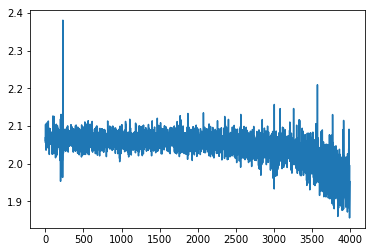

1000 5.0% (0.0m 19.263222694396973s) 2.076 / Economics X Statistics
2000 10.0% (0.0m 38.61230683326721s) 2.087 / Economics X Computer Science
3000 15.0% (0.0m 58.2614221572876s) 2.082 / Quantitative Finance X Mathematics
4000 20.0% (1.0m 17.66495108604431s) 2.076 / Computer Science X Quantitative Biology
5000 25.0% (1.0m 37.091007709503174s) 2.068 / Quantitative Finance X Computer Science
6000 30.0% (1.0m 56.49859046936035s) 2.069 / Mathematics X Physics
7000 35.0% (2.0m 16.06135368347168s) 2.09 / Quantitative Biology X Physics
8000 40.0% (2.0m 35.488940477371216s) 2.088 / Computer Science X Economics
9000 45.0% (2.0m 54.973628520965576s) 2.07 / Mathematics X Quantitative Biology
10000 50.0% (3.0m 14.37918734550476s) 2.07 / Mathematics V
11000 55.0% (3.0m 33.98289394378662s) 2.075 / Physics X Computer Science
12000 60.0% (3.0m 53.46288228034973s) 2.097 / Computer Science X Economics
13000 65.0% (4.0m 13.003500699996948s) 2.076 / Economics X Electrical Engineering and Systems Science
14

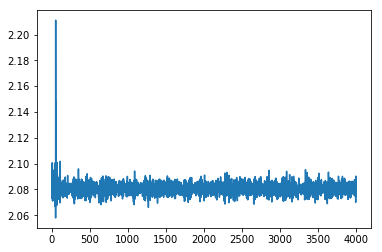

1000 5.0% (1.0m 4.7177040576934814s) 2.045 / Quantitative Biology X Economics
2000 10.0% (2.0m 9.033416986465454s) 2.087 / Quantitative Finance X Physics
3000 15.0% (3.0m 13.866874694824219s) 2.076 / Quantitative Biology X Computer Science
4000 20.0% (4.0m 18.50776433944702s) 2.112 / Physics X Quantitative Finance
5000 25.0% (5.0m 23.626264095306396s) 2.086 / Computer Science X Quantitative Finance
6000 30.0% (6.0m 28.458186388015747s) 2.072 / Economics X Quantitative Biology
7000 35.0% (7.0m 33.15550518035889s) 2.097 / Statistics X Quantitative Finance
8000 40.0% (8.0m 37.95979380607605s) 2.086 / Statistics V
9000 45.0% (9.0m 42.546329975128174s) 2.1 / Economics X Physics
10000 50.0% (10.0m 49.48506736755371s) 2.093 / Economics X Mathematics
11000 55.0% (11.0m 54.472127199172974s) 2.044 / Economics X Statistics
12000 60.0% (12.0m 59.42268204689026s) 2.083 / Quantitative Biology X Electrical Engineering and Systems Science
13000 65.0% (14.0m 4.173603057861328s) 2.087 / Quantitative Bio

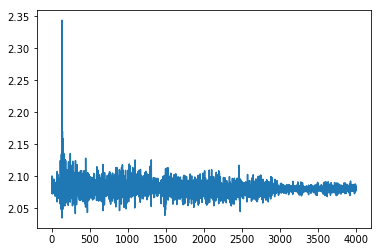

1000 5.0% (2.0m 40.88387370109558s) 2.069 / Electrical Engineering and Systems Science X Physics
2000 10.0% (5.0m 21.186583518981934s) 2.014 / Quantitative Biology X Electrical Engineering and Systems Science
3000 15.0% (8.0m 0.36901283264160156s) 2.062 / Physics X Statistics
4000 20.0% (10.0m 39.504963397979736s) 2.06 / Electrical Engineering and Systems Science X Economics
5000 25.0% (13.0m 20.403218984603882s) 2.088 / Statistics X Quantitative Finance
6000 30.0% (15.0m 59.708388328552246s) 2.036 / Economics X Statistics
7000 35.0% (18.0m 37.685235261917114s) 2.088 / Quantitative Biology X Mathematics
8000 40.0% (21.0m 16.532986640930176s) 2.08 / Quantitative Biology X Statistics
9000 45.0% (23.0m 56.33922791481018s) 2.02 / Statistics X Computer Science
10000 50.0% (26.0m 36.59030723571777s) 2.067 / Electrical Engineering and Systems Science X Physics
11000 55.0% (29.0m 15.496264219284058s) 2.044 / Statistics X Electrical Engineering and Systems Science
12000 60.0% (31.0m 55.80684995

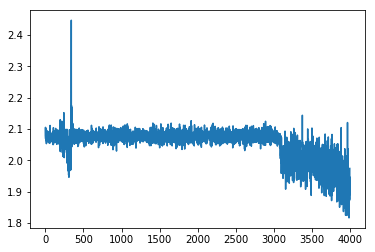

1000 5.0% (4.0m 9.842580556869507s) 2.06 / Electrical Engineering and Systems Science X Statistics
2000 10.0% (8.0m 20.785421133041382s) 2.009 / Electrical Engineering and Systems Science X Computer Science
3000 15.0% (12.0m 31.245585203170776s) 2.139 / Statistics X Computer Science
4000 20.0% (16.0m 40.37457728385925s) 2.086 / Economics X Statistics
5000 25.0% (20.0m 50.261967182159424s) 1.977 / Electrical Engineering and Systems Science V
6000 30.0% (24.0m 59.75992155075073s) 2.065 / Electrical Engineering and Systems Science V
7000 35.0% (29.0m 8.262245178222656s) 2.05 / Economics X Quantitative Finance
8000 40.0% (33.0m 17.804601192474365s) 2.146 / Physics X Quantitative Biology
9000 45.0% (37.0m 25.756699562072754s) 2.023 / Electrical Engineering and Systems Science X Quantitative Biology
10000 50.0% (41.0m 34.57748055458069s) 2.041 / Economics X Quantitative Finance
11000 55.0% (45.0m 43.44558262825012s) 2.048 / Economics V
12000 60.0% (49.0m 53.39159607887268s) 2.053 / Electrica

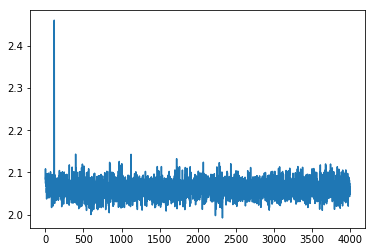

1000 5.0% (0.0m 19.40464687347412s) 2.07 / Physics V
2000 10.0% (0.0m 38.737467765808105s) 2.064 / Quantitative Biology X Economics
3000 15.0% (0.0m 58.05142784118652s) 2.085 / Quantitative Biology X Mathematics
4000 20.0% (1.0m 17.393463611602783s) 2.081 / Statistics X Quantitative Finance
5000 25.0% (1.0m 37.01681041717529s) 2.079 / Computer Science V
6000 30.0% (1.0m 56.414336919784546s) 2.077 / Physics X Electrical Engineering and Systems Science
7000 35.0% (2.0m 16.115333795547485s) 2.102 / Quantitative Finance X Statistics
8000 40.0% (2.0m 35.677549839019775s) 2.074 / Statistics X Economics
9000 45.0% (2.0m 55.29402017593384s) 2.082 / Quantitative Finance X Physics
10000 50.0% (3.0m 14.73106861114502s) 2.079 / Statistics V
11000 55.0% (3.0m 34.11286425590515s) 2.08 / Mathematics X Quantitative Biology
12000 60.0% (3.0m 53.47177863121033s) 2.057 / Economics X Computer Science
13000 65.0% (4.0m 12.999050617218018s) 2.062 / Economics V
14000 70.0% (4.0m 32.36579632759094s) 2.081 / E

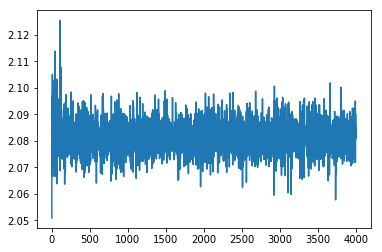

1000 5.0% (1.0m 4.688726186752319s) 2.105 / Quantitative Finance X Electrical Engineering and Systems Science
2000 10.0% (2.0m 9.23527216911316s) 2.076 / Computer Science V
3000 15.0% (3.0m 13.84539008140564s) 2.081 / Electrical Engineering and Systems Science X Quantitative Finance
4000 20.0% (4.0m 18.301144123077393s) 2.085 / Economics X Physics
5000 25.0% (5.0m 22.750051736831665s) 2.097 / Physics X Economics
6000 30.0% (6.0m 27.61075472831726s) 2.078 / Statistics X Physics
7000 35.0% (7.0m 32.198559045791626s) 2.088 / Quantitative Finance X Economics
8000 40.0% (8.0m 36.716883182525635s) 2.08 / Quantitative Biology X Electrical Engineering and Systems Science
9000 45.0% (9.0m 41.240899085998535s) 2.082 / Quantitative Biology V
10000 50.0% (10.0m 45.66301774978638s) 2.066 / Quantitative Finance X Quantitative Biology
11000 55.0% (11.0m 50.337287187576294s) 2.091 / Quantitative Biology X Quantitative Finance
12000 60.0% (12.0m 54.921751260757446s) 2.089 / Quantitative Biology X Mathe

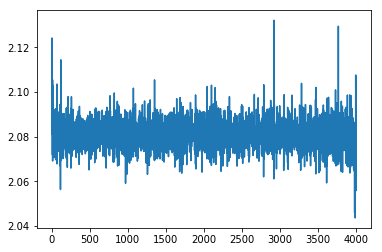

1000 5.0% (2.0m 40.02192425727844s) 2.032 / Economics X Statistics
2000 10.0% (5.0m 21.24160861968994s) 1.947 / Economics X Physics
3000 15.0% (8.0m 2.3997535705566406s) 2.106 / Electrical Engineering and Systems Science V
4000 20.0% (10.0m 42.60228204727173s) 1.775 / Electrical Engineering and Systems Science X Statistics
5000 25.0% (13.0m 22.538667678833008s) 1.818 / Physics X Electrical Engineering and Systems Science
6000 30.0% (16.0m 3.378025531768799s) 1.21 / Quantitative Biology X Computer Science
7000 35.0% (18.0m 45.38480305671692s) 1.259 / Quantitative Biology X Computer Science
8000 40.0% (21.0m 27.60359477996826s) 1.22 / Economics X Computer Science
9000 45.0% (24.0m 8.304871082305908s) 1.08 / Mathematics X Computer Science
10000 50.0% (26.0m 52.81318402290344s) 0.8055 / Quantitative Finance X Mathematics
11000 55.0% (29.0m 35.16723585128784s) 0.9927 / Physics X Statistics
12000 60.0% (32.0m 16.71347737312317s) 1.17 / Electrical Engineering and Systems Science V
13000 65.0%

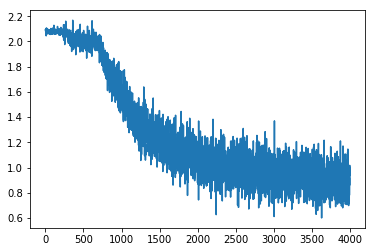

1000 5.0% (4.0m 7.588069677352905s) 1.938 / Quantitative Biology X Physics
2000 10.0% (8.0m 15.501343488693237s) 2.178 / Quantitative Biology X Mathematics
3000 15.0% (12.0m 22.817556858062744s) 2.089 / Quantitative Biology X Mathematics
4000 20.0% (16.0m 30.055962562561035s) 2.142 / Quantitative Finance X Electrical Engineering and Systems Science
5000 25.0% (20.0m 38.9565155506134s) 2.132 / Economics X Electrical Engineering and Systems Science
6000 30.0% (24.0m 48.878029584884644s) 2.139 / Quantitative Biology X Electrical Engineering and Systems Science
7000 35.0% (28.0m 57.764469385147095s) 1.877 / Electrical Engineering and Systems Science X Physics
8000 40.0% (33.0m 7.155250549316406s) 2.036 / Electrical Engineering and Systems Science X Quantitative Biology
9000 45.0% (37.0m 17.17058753967285s) 2.069 / Electrical Engineering and Systems Science V
10000 50.0% (41.0m 27.06233263015747s) 1.82 / Electrical Engineering and Systems Science V
11000 55.0% (45.0m 36.65808320045471s) 1.9

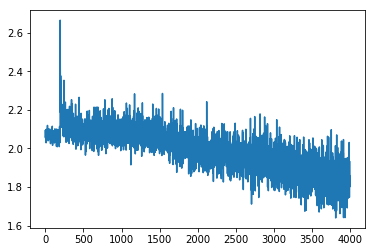

1000 5.0% (0.0m 19.326504230499268s) 2.079 / Computer Science V
2000 10.0% (0.0m 38.80441427230835s) 2.087 / Physics X Mathematics
3000 15.0% (0.0m 58.154606342315674s) 2.079 / Quantitative Finance X Electrical Engineering and Systems Science
4000 20.0% (1.0m 17.51275944709778s) 2.092 / Statistics X Economics
5000 25.0% (1.0m 36.867607831954956s) 2.079 / Computer Science X Statistics
6000 30.0% (1.0m 56.63894772529602s) 2.097 / Physics X Computer Science
7000 35.0% (2.0m 15.997481346130371s) 2.063 / Computer Science V
8000 40.0% (2.0m 35.39149522781372s) 2.007 / Electrical Engineering and Systems Science X Computer Science
9000 45.0% (2.0m 54.863311767578125s) 2.089 / Quantitative Biology X Economics
10000 50.0% (3.0m 14.595470190048218s) 2.111 / Quantitative Finance V
11000 55.0% (3.0m 34.03682518005371s) 2.054 / Economics X Physics
12000 60.0% (3.0m 53.49045968055725s) 2.089 / Computer Science X Physics
13000 65.0% (4.0m 12.918006420135498s) 2.023 / Quantitative Finance X Electrical 

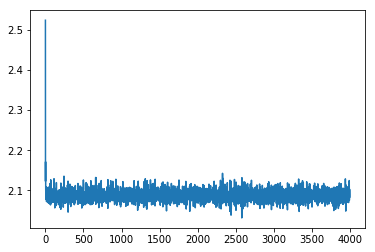

1000 5.0% (1.0m 4.973050832748413s) 2.047 / Quantitative Biology X Computer Science
2000 10.0% (2.0m 10.092684507369995s) 2.068 / Mathematics X Quantitative Finance
3000 15.0% (3.0m 14.899508237838745s) 2.051 / Quantitative Biology X Statistics
4000 20.0% (4.0m 19.739588499069214s) 2.107 / Physics X Electrical Engineering and Systems Science
5000 25.0% (5.0m 24.48626971244812s) 2.09 / Physics X Economics
6000 30.0% (6.0m 29.224335432052612s) 2.134 / Statistics X Quantitative Biology
7000 35.0% (7.0m 34.30531311035156s) 2.102 / Quantitative Finance X Computer Science
8000 40.0% (8.0m 39.08825135231018s) 2.169 / Quantitative Biology X Mathematics
9000 45.0% (9.0m 44.08855128288269s) 2.086 / Economics X Quantitative Biology
10000 50.0% (10.0m 48.97727823257446s) 2.048 / Mathematics X Electrical Engineering and Systems Science
11000 55.0% (11.0m 53.927048206329346s) 2.167 / Statistics X Quantitative Finance


In [0]:
#again, with randomTrainingExample now


criterion = nn.CrossEntropyLoss()

n_iters = 20000
batch_size = 20
print_every = 1000
plot_every = 5

for learning_rate in (0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in (50, 200, 500, 700):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 5.0% (0.0m 19.23849582672119s) 2.157 / Statistics X Electrical Engineering and Systems Science
2000 10.0% (0.0m 38.389299631118774s) 2.025 / Computer Science X Economics
3000 15.0% (0.0m 57.645495653152466s) 2.188 / Computer Science X Physics
4000 20.0% (1.0m 16.79692029953003s) 2.146 / Physics X Statistics
5000 25.0% (1.0m 36.0214102268219s) 2.054 / Statistics X Economics
6000 30.0% (1.0m 55.18158841133118s) 2.104 / Electrical Engineering and Systems Science X Physics
7000 35.0% (2.0m 14.36929202079773s) 2.092 / Economics X Statistics
8000 40.0% (2.0m 33.501909017562866s) 2.11 / Quantitative Biology V
9000 45.0% (2.0m 52.71430587768555s) 2.18 / Mathematics X Quantitative Finance
10000 50.0% (3.0m 11.918349266052246s) 2.031 / Physics X Computer Science
11000 55.0% (3.0m 31.141060829162598s) 2.086 / Economics X Physics
12000 60.0% (3.0m 50.3889524936676s) 2.019 / Quantitative Biology X Quantitative Finance
13000 65.0% (4.0m 9.542925357818604s) 2.066 / Quantitative Biology X Compute

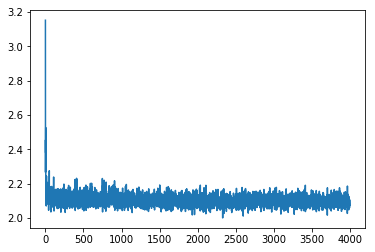

1000 5.0% (1.0m 3.7293784618377686s) 2.103 / Quantitative Biology X Electrical Engineering and Systems Science
2000 10.0% (2.0m 7.497410535812378s) 2.12 / Quantitative Finance X Quantitative Biology
3000 15.0% (3.0m 11.242409706115723s) 2.136 / Statistics X Mathematics
4000 20.0% (4.0m 15.207666873931885s) 2.058 / Quantitative Biology X Electrical Engineering and Systems Science
5000 25.0% (5.0m 18.98443627357483s) 2.144 / Statistics X Mathematics
6000 30.0% (6.0m 22.750911235809326s) 2.061 / Economics X Electrical Engineering and Systems Science
7000 35.0% (7.0m 26.604106664657593s) 2.052 / Computer Science X Physics
8000 40.0% (8.0m 30.52713108062744s) 2.067 / Computer Science X Quantitative Finance
9000 45.0% (9.0m 34.38999557495117s) 2.159 / Statistics X Electrical Engineering and Systems Science
10000 50.0% (10.0m 38.256365060806274s) 2.066 / Quantitative Biology X Electrical Engineering and Systems Science
11000 55.0% (11.0m 41.9786639213562s) 2.05 / Quantitative Biology V
12000 

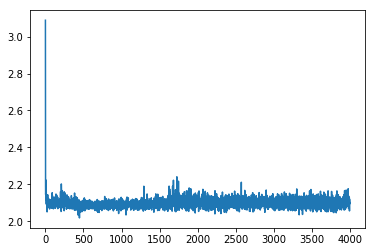

1000 5.0% (2.0m 35.85071134567261s) 2.11 / Mathematics V
2000 10.0% (5.0m 12.784258127212524s) 2.248 / Quantitative Biology X Physics
3000 15.0% (7.0m 48.56994390487671s) 2.091 / Quantitative Biology X Quantitative Finance
4000 20.0% (10.0m 25.370884895324707s) 2.006 / Statistics V
5000 25.0% (13.0m 1.7039158344268799s) 2.089 / Physics X Electrical Engineering and Systems Science
6000 30.0% (15.0m 40.05841612815857s) 2.063 / Quantitative Biology X Statistics
7000 35.0% (18.0m 17.811643600463867s) 2.094 / Economics X Statistics
8000 40.0% (20.0m 55.973456382751465s) 2.02 / Statistics V
9000 45.0% (23.0m 34.13365292549133s) 2.024 / Quantitative Biology X Quantitative Finance
10000 50.0% (26.0m 11.388231992721558s) 2.153 / Quantitative Finance X Quantitative Biology
11000 55.0% (28.0m 49.16774010658264s) 2.213 / Economics X Quantitative Biology
12000 60.0% (31.0m 26.98502492904663s) 2.111 / Economics X Physics
13000 65.0% (34.0m 4.5019211769104s) 2.23 / Quantitative Finance X Statistics
1

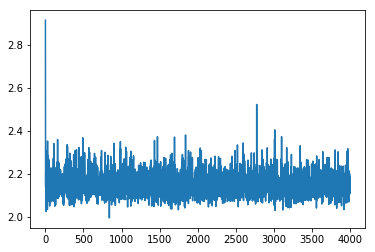

1000 5.0% (4.0m 4.9018166065216064s) 2.299 / Computer Science X Quantitative Biology
2000 10.0% (8.0m 10.47449016571045s) 2.355 / Quantitative Finance X Quantitative Biology
3000 15.0% (12.0m 14.795494079589844s) 2.139 / Quantitative Biology X Mathematics
4000 20.0% (16.0m 18.95011878013611s) 2.163 / Statistics X Mathematics
5000 25.0% (20.0m 22.8025484085083s) 2.252 / Economics X Electrical Engineering and Systems Science
6000 30.0% (24.0m 27.246896505355835s) 2.249 / Electrical Engineering and Systems Science X Mathematics
7000 35.0% (28.0m 33.51497554779053s) 2.169 / Electrical Engineering and Systems Science X Mathematics
8000 40.0% (32.0m 38.57465171813965s) 2.165 / Economics X Mathematics
9000 45.0% (36.0m 43.67091512680054s) 2.231 / Quantitative Biology X Mathematics
10000 50.0% (40.0m 47.56521034240723s) 2.297 / Electrical Engineering and Systems Science X Statistics
11000 55.0% (44.0m 50.99740648269653s) 2.088 / Computer Science X Statistics
12000 60.0% (48.0m 53.2985479831695

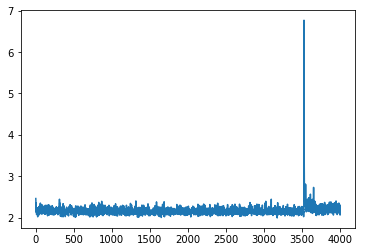

In [0]:
#again, with randomTrainingExample now (II)


criterion = nn.CrossEntropyLoss()

n_iters = 20000
batch_size = 20
print_every = 1000
plot_every = 5

learning_rate=0.05
for use_first_characters in (50, 200, 500, 700):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 12.5% (0.0m 12.945635318756104s) 2.065 / Physics X Computer Science
2000 25.0% (0.0m 25.88383150100708s) 2.105 / Physics X Computer Science
3000 37.5% (0.0m 38.7769935131073s) 2.082 / Mathematics X Computer Science
4000 50.0% (0.0m 51.68174648284912s) 2.088 / Economics V
5000 62.5% (1.0m 4.566839694976807s) 2.06 / Quantitative Biology X Computer Science
6000 75.0% (1.0m 17.627158880233765s) 2.09 / Mathematics X Computer Science
7000 87.5% (1.0m 30.624370098114014s) 2.108 / Electrical Engineering and Systems Science X Statistics
8000 100.0% (1.0m 43.562445402145386s) 2.1 / Quantitative Biology X Statistics
learning rate and characters used: 0.01 50


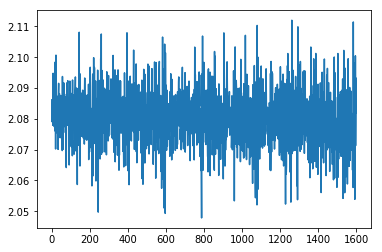

1000 12.5% (0.0m 23.59262204170227s) 2.093 / Economics X Physics
2000 25.0% (0.0m 47.071128845214844s) 2.091 / Quantitative Biology X Physics
3000 37.5% (1.0m 10.726557493209839s) 2.055 / Computer Science X Economics
4000 50.0% (1.0m 34.35130262374878s) 2.089 / Electrical Engineering and Systems Science X Computer Science
5000 62.5% (1.0m 57.844653606414795s) 2.073 / Quantitative Finance X Electrical Engineering and Systems Science
6000 75.0% (2.0m 21.440067291259766s) 2.096 / Quantitative Finance X Computer Science
7000 87.5% (2.0m 44.811187982559204s) 2.055 / Electrical Engineering and Systems Science V
8000 100.0% (3.0m 8.297607660293579s) 2.05 / Quantitative Finance X Electrical Engineering and Systems Science
learning rate and characters used: 0.01 100


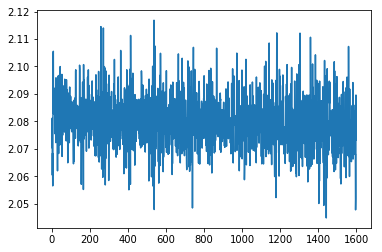

1000 12.5% (0.0m 34.34511661529541s) 2.068 / Electrical Engineering and Systems Science X Mathematics
2000 25.0% (1.0m 8.439978837966919s) 2.09 / Computer Science X Statistics
3000 37.5% (1.0m 42.70589065551758s) 2.087 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (2.0m 16.937114715576172s) 2.077 / Statistics V
5000 62.5% (2.0m 51.008856773376465s) 2.055 / Quantitative Finance X Quantitative Biology
6000 75.0% (3.0m 25.186760187149048s) 2.105 / Physics X Statistics
7000 87.5% (3.0m 59.37833309173584s) 2.081 / Electrical Engineering and Systems Science X Computer Science
8000 100.0% (4.0m 33.45580863952637s) 2.061 / Quantitative Biology X Mathematics
learning rate and characters used: 0.01 150


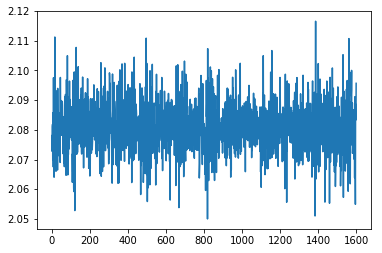

1000 12.5% (0.0m 44.60865116119385s) 2.114 / Quantitative Biology X Computer Science
2000 25.0% (1.0m 29.384790182113647s) 2.094 / Computer Science X Quantitative Biology
3000 37.5% (2.0m 13.799522399902344s) 2.057 / Quantitative Finance V
4000 50.0% (2.0m 58.33927249908447s) 2.064 / Quantitative Biology X Economics
5000 62.5% (3.0m 42.698771476745605s) 2.102 / Physics X Statistics
6000 75.0% (4.0m 27.666574716567993s) 2.087 / Electrical Engineering and Systems Science V
7000 87.5% (5.0m 12.14643931388855s) 2.106 / Physics X Statistics
8000 100.0% (5.0m 56.5129771232605s) 2.066 / Physics X Quantitative Biology
learning rate and characters used: 0.01 200


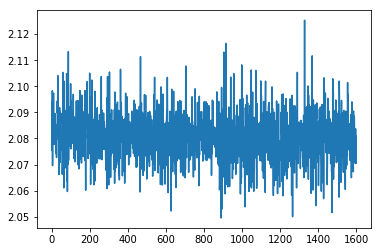

1000 12.5% (0.0m 54.78030204772949s) 2.074 / Statistics X Electrical Engineering and Systems Science
2000 25.0% (1.0m 49.37324523925781s) 2.099 / Statistics X Quantitative Biology
3000 37.5% (2.0m 44.231295347213745s) 2.039 / Quantitative Finance X Computer Science
4000 50.0% (3.0m 39.174765825271606s) 2.07 / Physics X Economics
5000 62.5% (4.0m 33.907028675079346s) 2.061 / Electrical Engineering and Systems Science X Mathematics
6000 75.0% (5.0m 28.46194338798523s) 2.079 / Quantitative Biology X Quantitative Finance
7000 87.5% (6.0m 22.955201387405396s) 2.083 / Electrical Engineering and Systems Science X Computer Science
8000 100.0% (7.0m 17.189578533172607s) 2.066 / Economics X Quantitative Biology
learning rate and characters used: 0.01 250


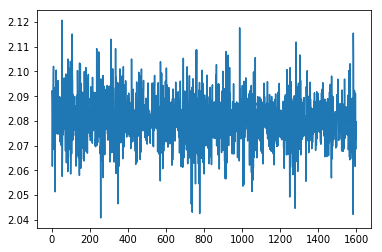

1000 12.5% (1.0m 6.154519081115723s) 2.056 / Economics X Quantitative Biology
2000 25.0% (2.0m 12.37068510055542s) 2.104 / Computer Science X Quantitative Finance
3000 37.5% (3.0m 18.217861890792847s) 2.09 / Economics X Physics
4000 50.0% (4.0m 24.14497399330139s) 2.021 / Economics X Quantitative Finance
5000 62.5% (5.0m 30.276041269302368s) 2.06 / Statistics V
6000 75.0% (6.0m 36.28460240364075s) 2.07 / Economics X Computer Science
7000 87.5% (7.0m 42.54280376434326s) 2.082 / Electrical Engineering and Systems Science X Economics
8000 100.0% (8.0m 48.475722789764404s) 2.08 / Physics X Electrical Engineering and Systems Science
learning rate and characters used: 0.01 300


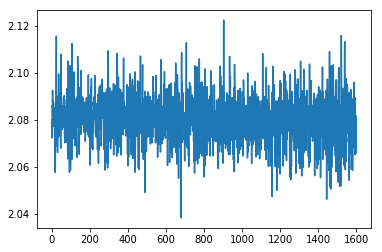

1000 12.5% (1.0m 14.207362413406372s) 2.098 / Electrical Engineering and Systems Science X Computer Science
2000 25.0% (2.0m 28.232130765914917s) 2.096 / Physics X Mathematics
3000 37.5% (3.0m 43.16625714302063s) 2.083 / Statistics X Quantitative Finance
4000 50.0% (4.0m 57.446146726608276s) 2.097 / Computer Science V
5000 62.5% (6.0m 11.746451616287231s) 2.083 / Quantitative Biology X Mathematics
6000 75.0% (7.0m 25.98096537590027s) 2.085 / Statistics X Quantitative Finance
7000 87.5% (8.0m 40.098252296447754s) 2.078 / Economics X Physics
8000 100.0% (9.0m 54.227736949920654s) 2.066 / Electrical Engineering and Systems Science X Quantitative Finance
learning rate and characters used: 0.01 350


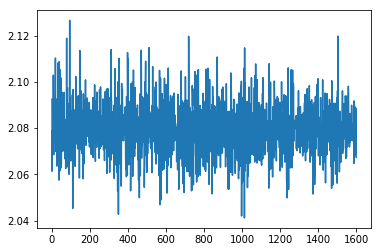

1000 12.5% (1.0m 24.32506012916565s) 2.104 / Computer Science X Mathematics
2000 25.0% (2.0m 47.93302941322327s) 2.073 / Electrical Engineering and Systems Science X Mathematics
3000 37.5% (4.0m 11.679775714874268s) 2.103 / Economics X Physics
4000 50.0% (5.0m 35.196547508239746s) 2.091 / Quantitative Finance X Quantitative Biology
5000 62.5% (6.0m 58.25873136520386s) 2.138 / Statistics X Quantitative Finance
6000 75.0% (8.0m 21.469672679901123s) 2.133 / Quantitative Biology X Mathematics
7000 87.5% (9.0m 44.85027194023132s) 2.087 / Statistics X Quantitative Biology
8000 100.0% (11.0m 8.032654523849487s) 2.071 / Computer Science X Statistics
learning rate and characters used: 0.01 400


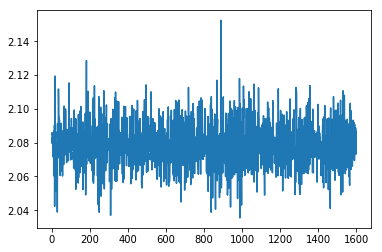

1000 12.5% (1.0m 37.5816867351532s) 2.078 / Statistics V
2000 25.0% (3.0m 15.677367448806763s) 2.105 / Statistics X Physics
3000 37.5% (4.0m 53.56083846092224s) 2.053 / Quantitative Biology X Computer Science
4000 50.0% (6.0m 32.44986128807068s) 2.126 / Electrical Engineering and Systems Science X Quantitative Finance
5000 62.5% (8.0m 10.725927591323853s) 2.107 / Quantitative Finance X Mathematics
6000 75.0% (9.0m 47.84972333908081s) 2.065 / Economics X Quantitative Finance
7000 87.5% (11.0m 26.500474214553833s) 2.059 / Computer Science X Physics
8000 100.0% (13.0m 4.511451005935669s) 2.074 / Quantitative Biology X Statistics
learning rate and characters used: 0.01 450


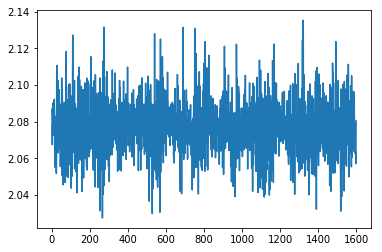

1000 12.5% (1.0m 50.708245038986206s) 2.075 / Physics X Mathematics
2000 25.0% (3.0m 41.394278049468994s) 2.129 / Statistics X Physics
3000 37.5% (5.0m 32.62368845939636s) 2.062 / Statistics X Quantitative Biology
4000 50.0% (7.0m 23.321460008621216s) 2.145 / Economics X Mathematics
5000 62.5% (9.0m 13.86893630027771s) 2.02 / Quantitative Biology X Physics
6000 75.0% (11.0m 5.014164209365845s) 2.088 / Electrical Engineering and Systems Science X Statistics
7000 87.5% (12.0m 55.803566217422485s) 2.094 / Physics X Quantitative Biology
8000 100.0% (14.0m 46.64661455154419s) 2.095 / Electrical Engineering and Systems Science X Quantitative Biology
learning rate and characters used: 0.01 500


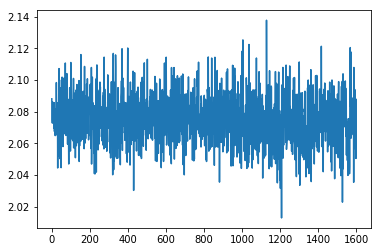

1000 12.5% (1.0m 58.535500049591064s) 2.069 / Statistics X Quantitative Biology
2000 25.0% (3.0m 56.50034189224243s) 2.029 / Statistics X Quantitative Finance
3000 37.5% (5.0m 54.72530221939087s) 2.09 / Electrical Engineering and Systems Science X Quantitative Finance
4000 50.0% (7.0m 52.64250588417053s) 2.042 / Economics X Mathematics
5000 62.5% (9.0m 51.25947880744934s) 2.062 / Electrical Engineering and Systems Science X Economics
6000 75.0% (11.0m 49.887622356414795s) 2.147 / Computer Science X Physics
7000 87.5% (13.0m 48.130414962768555s) 2.133 / Electrical Engineering and Systems Science X Mathematics
8000 100.0% (15.0m 46.56763529777527s) 2.023 / Electrical Engineering and Systems Science V
learning rate and characters used: 0.01 550


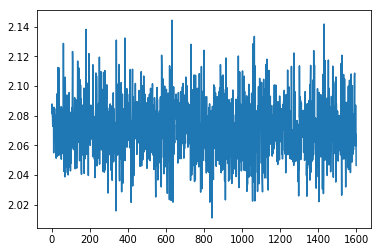

1000 12.5% (2.0m 11.360098838806152s) 2.138 / Quantitative Biology X Physics
2000 25.0% (4.0m 21.891178607940674s) 2.092 / Electrical Engineering and Systems Science X Statistics
3000 37.5% (6.0m 32.71527910232544s) 2.073 / Computer Science X Quantitative Finance
4000 50.0% (8.0m 42.94234228134155s) 2.017 / Statistics X Quantitative Finance
5000 62.5% (10.0m 55.059205293655396s) 2.042 / Quantitative Biology X Computer Science
6000 75.0% (13.0m 7.144406795501709s) 2.066 / Quantitative Biology X Computer Science
7000 87.5% (15.0m 20.204871892929077s) 2.084 / Economics X Physics
8000 100.0% (17.0m 32.28484630584717s) 2.113 / Economics X Computer Science
learning rate and characters used: 0.01 600


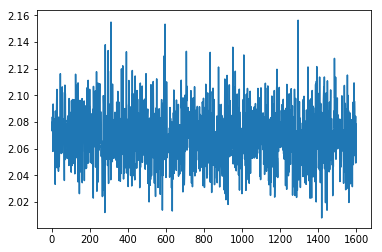

1000 12.5% (2.0m 25.572205066680908s) 2.06 / Statistics X Physics
2000 25.0% (4.0m 52.702295780181885s) 2.232 / Physics X Mathematics
3000 37.5% (7.0m 21.20860981941223s) 2.051 / Electrical Engineering and Systems Science X Physics
4000 50.0% (9.0m 49.63057899475098s) 2.1 / Quantitative Biology X Economics
5000 62.5% (12.0m 16.62706208229065s) 2.189 / Economics X Quantitative Biology
6000 75.0% (14.0m 44.081278562545776s) 2.082 / Economics X Electrical Engineering and Systems Science
7000 87.5% (17.0m 9.451258897781372s) 2.126 / Statistics X Quantitative Biology
8000 100.0% (19.0m 35.31805872917175s) 1.97 / Economics X Quantitative Biology
learning rate and characters used: 0.01 650


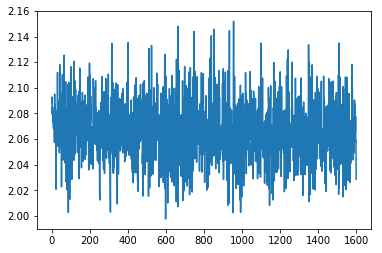

1000 12.5% (0.0m 12.754579067230225s) 2.075 / Physics X Computer Science
2000 25.0% (0.0m 25.449865341186523s) 2.104 / Computer Science X Mathematics
3000 37.5% (0.0m 38.093329429626465s) 2.192 / Mathematics X Statistics
4000 50.0% (0.0m 50.782991886138916s) 2.087 / Quantitative Finance X Computer Science
5000 62.5% (1.0m 3.473630905151367s) 2.107 / Physics X Computer Science
6000 75.0% (1.0m 16.08344268798828s) 2.13 / Economics V
7000 87.5% (1.0m 28.684271335601807s) 2.041 / Economics X Mathematics
8000 100.0% (1.0m 41.28675699234009s) 2.024 / Computer Science X Economics
learning rate and characters used: 0.05 50


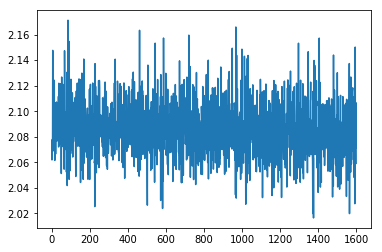

1000 12.5% (0.0m 23.084431648254395s) 2.098 / Physics X Computer Science
2000 25.0% (0.0m 46.36592936515808s) 2.035 / Statistics X Electrical Engineering and Systems Science
3000 37.5% (1.0m 9.423252582550049s) 2.08 / Electrical Engineering and Systems Science X Mathematics
4000 50.0% (1.0m 32.484050989151s) 2.03 / Quantitative Biology X Quantitative Finance
5000 62.5% (1.0m 55.71205234527588s) 2.106 / Computer Science X Quantitative Finance
6000 75.0% (2.0m 18.910632848739624s) 2.095 / Statistics X Quantitative Finance
7000 87.5% (2.0m 41.964669942855835s) 2.147 / Physics X Computer Science
8000 100.0% (3.0m 5.223733901977539s) 2.12 / Computer Science X Economics
learning rate and characters used: 0.05 100


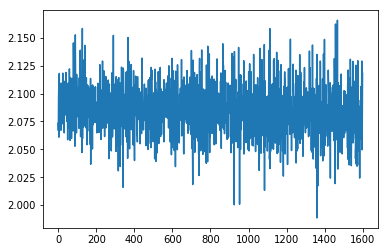

1000 12.5% (0.0m 33.54528737068176s) 2.055 / Mathematics X Computer Science
2000 25.0% (1.0m 6.894815444946289s) 2.102 / Quantitative Biology X Quantitative Finance
3000 37.5% (1.0m 40.461045026779175s) 2.071 / Statistics X Quantitative Finance
4000 50.0% (2.0m 13.782555103302002s) 2.073 / Quantitative Biology X Economics
5000 62.5% (2.0m 47.22179341316223s) 2.105 / Quantitative Biology X Physics
6000 75.0% (3.0m 20.619835376739502s) 1.985 / Economics X Mathematics
7000 87.5% (3.0m 54.06111979484558s) 2.028 / Computer Science X Quantitative Biology
8000 100.0% (4.0m 27.583236694335938s) 2.119 / Electrical Engineering and Systems Science X Computer Science
learning rate and characters used: 0.05 150


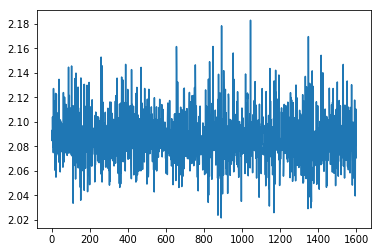

1000 12.5% (0.0m 43.68206715583801s) 2.118 / Computer Science X Physics
2000 25.0% (1.0m 27.383761644363403s) 2.138 / Quantitative Biology X Electrical Engineering and Systems Science
3000 37.5% (2.0m 10.78651237487793s) 2.031 / Economics X Mathematics
4000 50.0% (2.0m 54.29076170921326s) 2.067 / Statistics V
5000 62.5% (3.0m 37.68574643135071s) 2.13 / Mathematics X Computer Science
6000 75.0% (4.0m 21.384589672088623s) 2.062 / Economics X Computer Science
7000 87.5% (5.0m 5.201669692993164s) 2.113 / Quantitative Finance X Electrical Engineering and Systems Science
8000 100.0% (5.0m 49.040186643600464s) 2.227 / Quantitative Finance X Economics
learning rate and characters used: 0.05 200


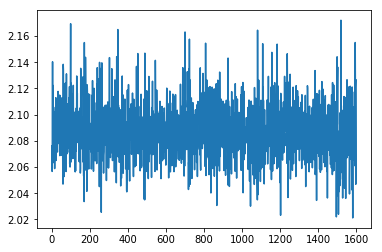

1000 12.5% (0.0m 53.99377179145813s) 2.158 / Mathematics X Quantitative Finance
2000 25.0% (1.0m 47.935184478759766s) 2.126 / Electrical Engineering and Systems Science X Mathematics
3000 37.5% (2.0m 41.8999285697937s) 2.052 / Computer Science X Economics
4000 50.0% (3.0m 35.79558205604553s) 2.057 / Computer Science X Quantitative Biology
5000 62.5% (4.0m 29.576571941375732s) 2.089 / Physics X Electrical Engineering and Systems Science
6000 75.0% (5.0m 23.552817821502686s) 2.066 / Electrical Engineering and Systems Science X Statistics
7000 87.5% (6.0m 17.326178073883057s) 2.156 / Electrical Engineering and Systems Science X Computer Science
8000 100.0% (7.0m 11.03783917427063s) 2.09 / Economics X Statistics
learning rate and characters used: 0.05 250


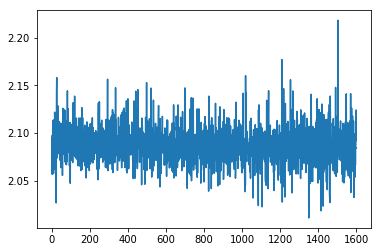

1000 12.5% (1.0m 3.1039912700653076s) 2.091 / Economics X Statistics
2000 25.0% (2.0m 7.158517599105835s) 2.027 / Economics X Quantitative Biology
3000 37.5% (3.0m 11.80772614479065s) 2.027 / Quantitative Finance X Computer Science
4000 50.0% (4.0m 16.180875062942505s) 2.108 / Mathematics X Computer Science
5000 62.5% (5.0m 21.599968433380127s) 2.069 / Quantitative Biology X Physics
6000 75.0% (6.0m 25.352663278579712s) 2.095 / Mathematics X Electrical Engineering and Systems Science
7000 87.5% (7.0m 30.882723331451416s) 2.093 / Economics X Statistics
8000 100.0% (8.0m 37.54199194908142s) 2.147 / Economics X Computer Science
learning rate and characters used: 0.05 300


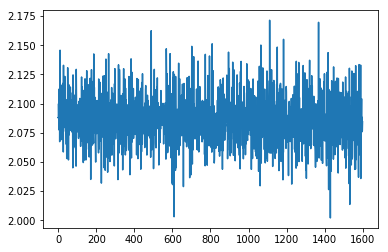

1000 12.5% (1.0m 14.707773208618164s) 2.079 / Statistics X Economics
2000 25.0% (2.0m 29.92434334754944s) 2.087 / Quantitative Finance X Statistics
3000 37.5% (3.0m 44.33635473251343s) 2.099 / Economics X Statistics
4000 50.0% (4.0m 58.67161440849304s) 2.093 / Electrical Engineering and Systems Science X Economics
5000 62.5% (6.0m 12.693591356277466s) 2.089 / Statistics X Quantitative Biology
6000 75.0% (7.0m 26.805609464645386s) 2.019 / Computer Science X Economics
7000 87.5% (8.0m 40.89880156517029s) 2.112 / Quantitative Biology X Statistics
8000 100.0% (9.0m 54.91692233085632s) 2.116 / Quantitative Finance X Statistics
learning rate and characters used: 0.05 350


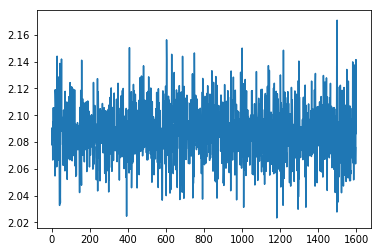

1000 12.5% (1.0m 23.667800664901733s) 2.084 / Statistics X Economics
2000 25.0% (2.0m 46.87351942062378s) 2.105 / Quantitative Biology X Quantitative Finance
3000 37.5% (4.0m 10.106069564819336s) 2.039 / Economics X Statistics
4000 50.0% (5.0m 33.21250343322754s) 2.072 / Statistics X Quantitative Biology
5000 62.5% (6.0m 56.33995962142944s) 2.128 / Statistics X Computer Science
6000 75.0% (8.0m 20.352269649505615s) 2.032 / Computer Science X Quantitative Biology
7000 87.5% (9.0m 45.375434160232544s) 2.14 / Electrical Engineering and Systems Science X Quantitative Biology
8000 100.0% (11.0m 9.986268281936646s) 2.117 / Quantitative Finance X Economics
learning rate and characters used: 0.05 400


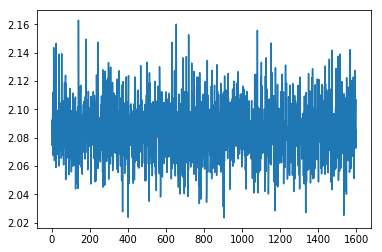

1000 12.5% (1.0m 38.9186372756958s) 2.207 / Computer Science X Quantitative Finance
2000 25.0% (3.0m 18.267728328704834s) 2.103 / Economics X Electrical Engineering and Systems Science
3000 37.5% (4.0m 58.012081146240234s) 2.084 / Electrical Engineering and Systems Science X Physics
4000 50.0% (6.0m 36.9042387008667s) 2.045 / Electrical Engineering and Systems Science V
5000 62.5% (8.0m 17.01397943496704s) 2.088 / Electrical Engineering and Systems Science X Statistics
6000 75.0% (9.0m 58.144545793533325s) 2.103 / Physics X Economics
7000 87.5% (11.0m 38.33414602279663s) 2.133 / Quantitative Biology X Statistics
8000 100.0% (13.0m 18.87764549255371s) 2.005 / Electrical Engineering and Systems Science X Physics
learning rate and characters used: 0.05 450


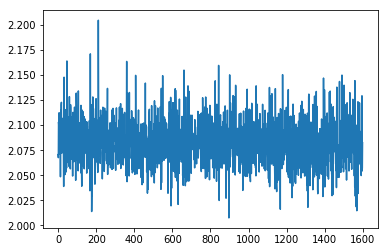

1000 12.5% (1.0m 53.30453848838806s) 2.1 / Electrical Engineering and Systems Science X Quantitative Biology
2000 25.0% (3.0m 45.91448926925659s) 2.088 / Electrical Engineering and Systems Science X Statistics
3000 37.5% (5.0m 38.82452440261841s) 2.071 / Quantitative Biology X Mathematics
4000 50.0% (7.0m 32.02875900268555s) 2.064 / Statistics X Physics


KeyboardInterrupt: ignored

In [0]:
#DO NOT RUN THIS


#EXPERIMENT WITH VARYING INPUT SIZE AND LEARNING RATE (2)

criterion = nn.CrossEntropyLoss()


n_iters = 8000
batch_size = 12
minimum=50;               #this is the minimum abstract length we are testing our model on
max_length=700
print_every = 1000
plot_every = 5

for learning_rate in (0.01, 0.05):
  for use_first_characters in range (minimum, max_length, 50):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


1000 0.67% (0.0m 57.12530016899109s) 2.073 / Electrical Engineering and Systems Science X Quantitative Biology
2000 1.33% (1.0m 54.19638013839722s) 2.091 / Electrical Engineering and Systems Science X Statistics
3000 2.0% (2.0m 51.39421010017395s) 2.085 / Electrical Engineering and Systems Science X Economics
4000 2.67% (3.0m 48.69830083847046s) 2.079 / Electrical Engineering and Systems Science X Quantitative Biology
5000 3.33% (4.0m 46.07417440414429s) 2.082 / Electrical Engineering and Systems Science X Computer Science
6000 4.0% (5.0m 43.40010452270508s) 2.082 / Electrical Engineering and Systems Science X Computer Science
7000 4.67% (6.0m 40.86122536659241s) 2.08 / Electrical Engineering and Systems Science X Quantitative Biology
8000 5.33% (7.0m 38.077396392822266s) 2.08 / Electrical Engineering and Systems Science X Computer Science
9000 6.0% (8.0m 35.450557470321655s) 2.081 / Electrical Engineering and Systems Science X Quantitative Finance
10000 6.67% (9.0m 32.70327925682068s)

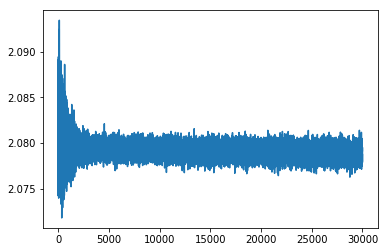

1000 0.67% (4.0m 3.0617525577545166s) 2.086 / Electrical Engineering and Systems Science X Statistics
2000 1.33% (8.0m 3.16970157623291s) 2.078 / Electrical Engineering and Systems Science X Quantitative Biology
3000 2.0% (12.0m 2.0971083641052246s) 2.081 / Electrical Engineering and Systems Science X Economics
4000 2.67% (16.0m 1.4622642993927002s) 2.082 / Electrical Engineering and Systems Science X Statistics
5000 3.33% (20.0m 5.244321823120117s) 2.086 / Electrical Engineering and Systems Science X Physics
6000 4.0% (24.0m 5.546168327331543s) 2.086 / Electrical Engineering and Systems Science X Mathematics
7000 4.67% (28.0m 8.411425828933716s) 2.077 / Electrical Engineering and Systems Science X Statistics
8000 5.33% (32.0m 11.492570638656616s) 2.081 / Electrical Engineering and Systems Science X Physics
9000 6.0% (36.0m 13.671565532684326s) 2.079 / Electrical Engineering and Systems Science X Economics
10000 6.67% (40.0m 16.035091638565063s) 2.081 / Electrical Engineering and Syste

In [0]:

criterion = nn.CrossEntropyLoss()

n_iters = 150000
batch_size = 50
print_every = 1000
plot_every = 5

for learning_rate in (0.0001, 0.0005, 0.005, 0.01, 0.05):
  for use_first_characters in (50, 250, 500):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)


## Best result so far

1000 1.11% (2.0m 38.65271973609924s) 2.11 / Quantitative Biology X Computer Science
2000 2.22% (5.0m 16.99624466896057s) 2.06 / Quantitative Biology X Economics
3000 3.33% (7.0m 56.86001229286194s) 2.047 / Economics X Quantitative Biology
4000 4.44% (10.0m 34.91282367706299s) 2.048 / Computer Science X Quantitative Biology
5000 5.56% (13.0m 12.909953117370605s) 2.133 / Electrical Engineering and Systems Science X Computer Science
6000 6.67% (15.0m 51.377143144607544s) 2.079 / Quantitative Biology X Quantitative Finance
7000 7.78% (18.0m 28.200444221496582s) 2.119 / Computer Science X Quantitative Biology
8000 8.89% (21.0m 5.8274829387664795s) 1.983 / Computer Science V
9000 10.0% (23.0m 42.6579384803772s) 2.07 / Physics X Quantitative Biology
10000 11.11% (26.0m 19.281241178512573s) 2.015 / Quantitative Biology X Computer Science
11000 12.22% (28.0m 56.0428683757782s) 2.101 / Economics X Physics
12000 13.33% (31.0m 32.577927112579346s) 2.125 / Statistics X Electrical Engineering and Sy

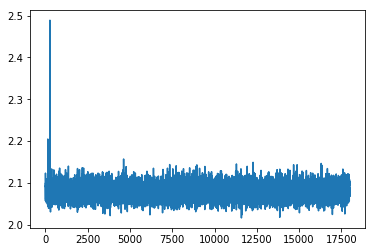

4.06 accuracy out of 10000 tests
Top 2 accuracy was 30.79


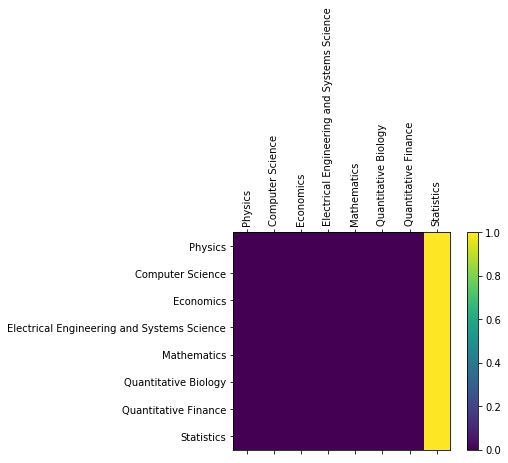

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]])


In [0]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
use_first_characters = 500
n_iters = 90000
batch_size = 20
print_every = 1000
plot_every = 5

model=LSTM(n_letters, n_hidden, n_categories).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_iters+1):

  optimizer.zero_grad()

  training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
  category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
  batch = 0
  while batch < batch_size:
    category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
    if len(abstract) < use_first_characters:
        # do this nasty "trick" to guarantee all the tensors have the same size
      continue

    training_batch[:, batch, :] = abstract_tensor[:, 0, :]
    category_batch[batch] = category_tensor[:]
    batch += 1

  output = model(training_batch)

  loss = criterion(output, category_batch)
  loss.backward()

  current_loss += loss.item()
  optimizer.step()


  if not (it % print_every):
    guess, guess_i = categoryFromOutput(output)
    correct = "V" if guess == category else "X {}".format(category)
    print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

  if not (it % plot_every):
    all_losses.append(current_loss / plot_every)
    current_loss = 0

print("learning rate and characters used:", learning_rate, use_first_characters)  
plot_losses(all_losses)


tests = 10000
rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for _ in range(tests):
    abstract = ""
    while len(abstract) < use_first_characters:
      category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
    cat_i = all_categories.index(category)
    """abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
    cat_i = all_categories.index(cat)
    category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()"""
    output = model(abstract_tensor)
    guess1, guess2 = topTwoFromOutput(output)
    if guess1 == cat_i:
      rights += 1
      top2rights += 1
    else:
      wrongs += 1
      if guess2 == cat_i:
        top2rights += 1
      else:
        top2wrongs +=1
    confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

1000 5.0% (2.0m 36.3346061706543s) 2.104 / Electrical Engineering and Systems Science X Quantitative Biology
2000 10.0% (5.0m 13.424152851104736s) 2.169 / Statistics X Quantitative Biology
3000 15.0% (7.0m 50.542410373687744s) 2.129 / Economics X Physics
4000 20.0% (10.0m 27.53575849533081s) 2.085 / Statistics X Electrical Engineering and Systems Science
5000 25.0% (13.0m 4.448992967605591s) 2.038 / Quantitative Biology X Electrical Engineering and Systems Science
6000 30.0% (15.0m 41.636085510253906s) 2.089 / Quantitative Biology X Economics
7000 35.0% (18.0m 18.808066606521606s) 2.091 / Statistics X Economics
8000 40.0% (20.0m 56.03467321395874s) 2.095 / Economics V
9000 45.0% (23.0m 33.349448442459106s) 2.061 / Economics X Computer Science
10000 50.0% (26.0m 10.872149229049683s) 2.009 / Quantitative Biology V
11000 55.0% (28.0m 47.96070098876953s) 2.077 / Physics X Computer Science
12000 60.0% (31.0m 25.108039140701294s) 2.054 / Quantitative Biology X Electrical Engineering and Syst

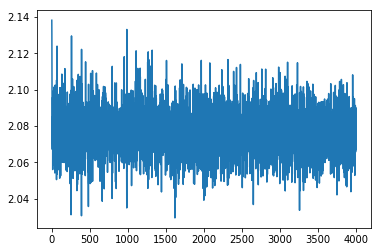

1.57 accuracy out of 10000 tests
Top 2 accuracy was 6.9


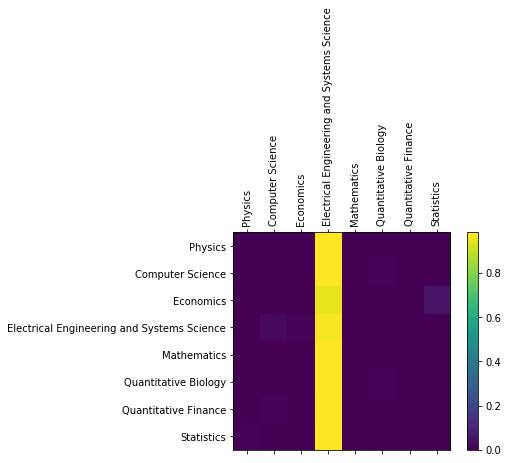

tensor([[ 0.,  0.,  0., 98.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 98.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 94.,  0.,  0.,  0.,  5.],
        [ 0.,  2.,  0., 96.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 98.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 97.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 98.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 98.,  0.,  0.,  0.,  0.]])


In [0]:
#with new net (dropout, 6 layers...)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
use_first_characters = 500
n_iters = 20000
batch_size = 20
print_every = 1000
plot_every = 5

model=LSTM(n_letters, n_hidden, n_categories).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_iters+1):

  optimizer.zero_grad()

  training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
  category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
  batch = 0
  while batch < batch_size:
    category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
    if len(abstract) < use_first_characters:
        # do this nasty "trick" to guarantee all the tensors have the same size
      continue

    training_batch[:, batch, :] = abstract_tensor[:, 0, :]
    category_batch[batch] = category_tensor[:]
    batch += 1

  output = model(training_batch)

  loss = criterion(output, category_batch)
  loss.backward()

  current_loss += loss.item()
  optimizer.step()


  if not (it % print_every):
    guess, guess_i = categoryFromOutput(output)
    correct = "V" if guess == category else "X {}".format(category)
    print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

  if not (it % plot_every):
    all_losses.append(current_loss / plot_every)
    current_loss = 0

print("learning rate and characters used:", learning_rate, use_first_characters)  
plot_losses(all_losses)


tests = 10000
rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for _ in range(tests):
    abstract = ""
    while len(abstract) < use_first_characters:
      category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
    cat_i = all_categories.index(category)
    """abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
    cat_i = all_categories.index(cat)
    category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()"""
    output = model(abstract_tensor)
    guess1, guess2 = topTwoFromOutput(output)
    if guess1 == cat_i:
      rights += 1
      top2rights += 1
    else:
      wrongs += 1
      if guess2 == cat_i:
        top2rights += 1
      else:
        top2wrongs +=1
    confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

1000 5.0% (1.0m 9.741064548492432s) 2.088 / Mathematics X Physics
2000 10.0% (2.0m 19.54027485847473s) 2.087 / Electrical Engineering and Systems Science X Quantitative Finance
3000 15.0% (3.0m 29.3113956451416s) 2.097 / Quantitative Finance X Quantitative Biology
4000 20.0% (4.0m 39.161940813064575s) 2.086 / Electrical Engineering and Systems Science V
5000 25.0% (5.0m 48.871307611465454s) 2.111 / Statistics X Mathematics
6000 30.0% (6.0m 58.81629753112793s) 2.076 / Mathematics X Quantitative Finance
7000 35.0% (8.0m 9.116609811782837s) 2.088 / Electrical Engineering and Systems Science X Mathematics
8000 40.0% (9.0m 19.271191120147705s) 2.102 / Electrical Engineering and Systems Science X Computer Science
9000 45.0% (10.0m 29.185529708862305s) 2.077 / Electrical Engineering and Systems Science X Statistics
10000 50.0% (11.0m 38.863261222839355s) 2.092 / Electrical Engineering and Systems Science X Economics
11000 55.0% (12.0m 48.60664176940918s) 2.068 / Quantitative Biology X Physics

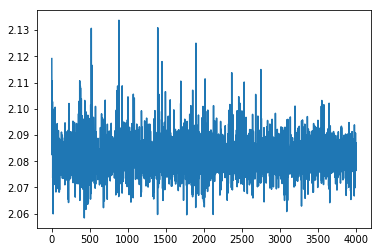

0.44 accuracy out of 10000 tests
Top 2 accuracy was 5.22


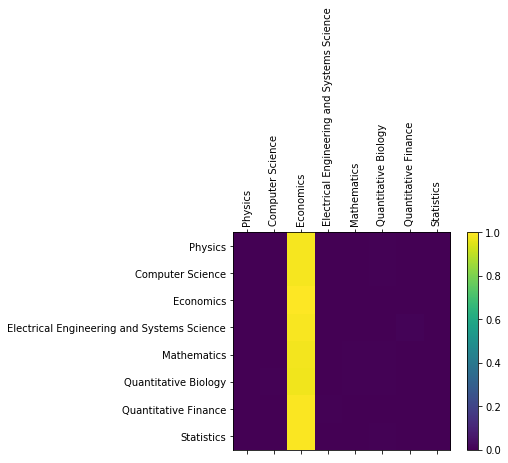

tensor([[  0.,   0.,  98.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  98.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  99.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  98.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  97.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  99.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  99.,   0.,   0.,   0.,   0.,   0.]])
1000 5.0% (2.0m 22.350576162338257s) 2.086 / Economics X Quantitative Biology
2000 10.0% (4.0m 44.607176542282104s) 2.083 / Statistics X Quantitative Finance
3000 15.0% (7.0m 6.011223316192627s) 2.094 / Electrical Engineering and Systems Science X Quantitative Finance
4000 20.0% (9.0m 28.107556104660034s) 2.035 / Statistics X Quantitative Biology
5000 25.0% (11.0m 49.02108716964722s) 2.078 / Economics X Statistics
6000 30.0% (14.0m 11.795165538787842s) 2.074 / Statistics X Economics
7000 35.0% (16.0m 34.49410915374756s) 2.08 / St

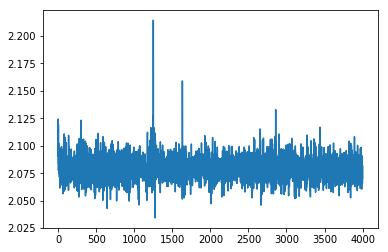

4.4 accuracy out of 10000 tests
Top 2 accuracy was 9.06


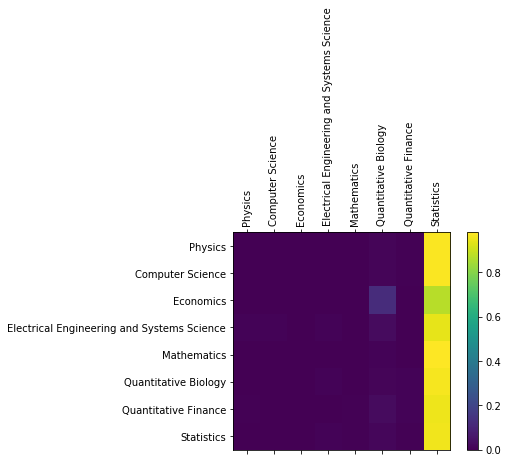

tensor([[ 0.,  0.,  0.,  0.,  0.,  1.,  0., 97.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 97.],
        [ 0.,  0.,  0.,  0.,  0., 12.,  0., 87.],
        [ 0.,  0.,  0.,  0.,  0.,  2.,  0., 94.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 98.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 96.],
        [ 0.,  0.,  0.,  0.,  0.,  2.,  0., 95.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 95.]])
1000 5.0% (4.0m 26.57101845741272s) 2.035 / Electrical Engineering and Systems Science X Economics
2000 10.0% (8.0m 53.71695041656494s) 2.033 / Electrical Engineering and Systems Science V
3000 15.0% (13.0m 20.82640790939331s) 2.044 / Physics X Economics
4000 20.0% (17.0m 47.17571520805359s) 2.084 / Computer Science X Mathematics
5000 25.0% (22.0m 12.85957956314087s) 2.077 / Economics X Quantitative Finance
6000 30.0% (26.0m 38.40650987625122s) 2.091 / Electrical Engineering and Systems Science X Statistics
7000 35.0% (31.0m 3.5595593452453613s) 2.15 / Quantitative Biology X Mathematics
8000 

In [0]:
criterion = nn.CrossEntropyLoss()

n_iters = 20000
batch_size = 20
print_every = 1000
plot_every = 5

for learning_rate in (0.01, 0.05):
  for use_first_characters in (140, 400, 700):

    rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for it in range(1, n_iters+1):

      optimizer.zero_grad()

      training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
      category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
      batch = 0
      while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
          continue

        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1

      output = rnn(training_batch)

      loss = criterion(output, category_batch)
      loss.backward()

      current_loss += loss.item()
      optimizer.step()


      if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))

      if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    print("learning rate and characters used:", learning_rate, use_first_characters)  
    plot_losses(all_losses)

    tests = 10000
    rights = 0
    wrongs = 0
    top2rights = 0
    top2wrongs = 0
    confusion = torch.zeros(n_categories, n_categories)
    with torch.no_grad():
      for _ in range(tests):
        abstract = ""
        while len(abstract) < use_first_characters:
          category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        cat_i = all_categories.index(category)
        """abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
        cat_i = all_categories.index(cat)
        category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()"""
        output = rnn(abstract_tensor)
        guess1, guess2 = topTwoFromOutput(output)
        if guess1 == cat_i:
          rights += 1
          top2rights += 1
        else:
          wrongs += 1
          if guess2 == cat_i:
            top2rights += 1
          else:
            top2wrongs +=1
        confusion[cat_i][guess1] += 1
    print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
    print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    import matplotlib.ticker as ticker

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

    print(confusion*1000//10)